# Movie genre classification based on IMDb descriptions
IMDb is an online database that stores information related to films, tv series, podcasts, home videos, video games and streaming content online, such as plot summaries, cast, ratings and reviews. As of December 2020 it had approximately 20 million titles and 83 million registered users. In this notebook an algorithm that determines the genre of a movie based on its summary on the IMDb database is fitted. The database that is used for training contains the description of 54214 movies of 27 different genres some of which are drama, comedy, thriller, crime, and scifi. To solve this task, a general vocabulary was formed out of the $n$ most used words in each genre's description. Then, each description was encoded using CountVectorizer according to this vocabulary. Finally, a multinomial naive bayes algorithm with $\alpha=0.7$ was chosen as the optimal classifier. The model achieved an accuracy of 0.53, a weighted average precision of 0.54 and a weighted average recall of 0.53.

# Data exploration and preprocessing

FIrst we import all the packages that might be used in this project and download the 
datasets that are going to be used. In this case, train_data is going to be used to develop the classifiers and test_data_solution will be used to test the final classifier we choose.

In [1]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import logging
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import re

train_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
movies=pd.read_csv(train_path,sep=':::', header=None, names=['title','genre','description'])

test_path="/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt"
movies_test=pd.read_csv(test_path,sep=':::', header=None, names=['title','genre','description'])


/tmp/ipykernel_18/350561349.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies=pd.read_csv(train_path,sep=':::', header=None, names=['title','genre','description'])
/tmp/ipykernel_18/350561349.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies_test=pd.read_csv(test_path,sep=':::', header=None, names=['title','genre','description'])


We explore the dataset, check for missing values and data types.

In [2]:
movies.head()

title       genre  \
1       Oscar et la dame rose (2009)       drama    
2                       Cupid (1997)    thriller    
3   Young, Wild and Wonderful (1980)       adult    
4              The Secret Sin (1915)       drama    
5             The Unrecovered (2007)       drama    

                                         description  
1   Listening in to a conversation between his do...  
2   A brother and sister with a past incestuous r...  
3   As the bus empties the students for their fie...  
4   To help their unemployed father make ends mee...  
5   The film's title refers not only to the un-re...

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


There are movies of 27 genres in the database
genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64


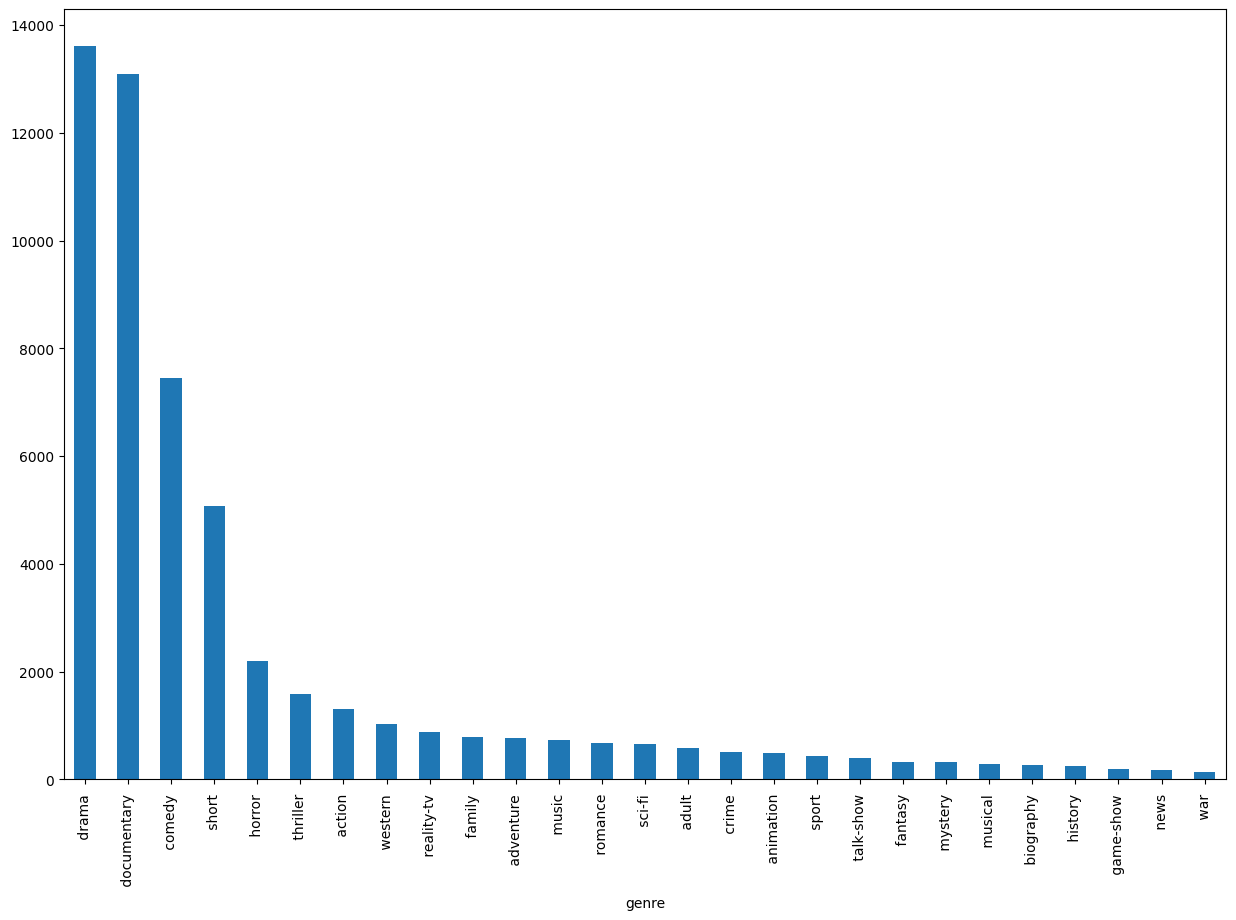

In [4]:
print("There are movies of {} genres in the database".format(movies.loc[:,"genre"].nunique()))
plt.figure(figsize=(15,10))
movies.loc[:,"genre"].value_counts().plot.bar()
print(movies.genre.value_counts())

There are no missing values in the dataset so we won't worry about that. However the data is unbalanced: there are significantly more "drama", "documentary", "comedy" and "short" movies in comparison to the remaining genres. Text augmentation is probably in order.

Now we clean the data: we make a function that lowercases all words in the descriptions and replaces non-alphabetical characters (like numbers and parentheses) for a space character " " or deletes them. English stopwords are deleted as well. Afterwards we apply it to the "description" column.

In [5]:
space = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = space.sub(' ', text) 
    text = symbols.sub('', text)  
    text = re.sub(r'[0-9]+','',text) #delete one or more digit ocurrences
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwords from text
    return text

In [6]:
#Check the amount of characters of all the original descriptions
movies['description'].apply(lambda x: len(x.split(' '))).sum()

5578969

In [7]:
#Clean descriptions of non-alphabetical characters
movies['description'] = movies['description'].apply(clean_text)

In [8]:
#Check the amount of characters of all the cleaned descriptions
movies['description'].apply(lambda x: len(x.split(' '))).sum()

3085742

We plot graph of the 25 most common words of each genre's descriptions to get a sense of how they are related to each genre


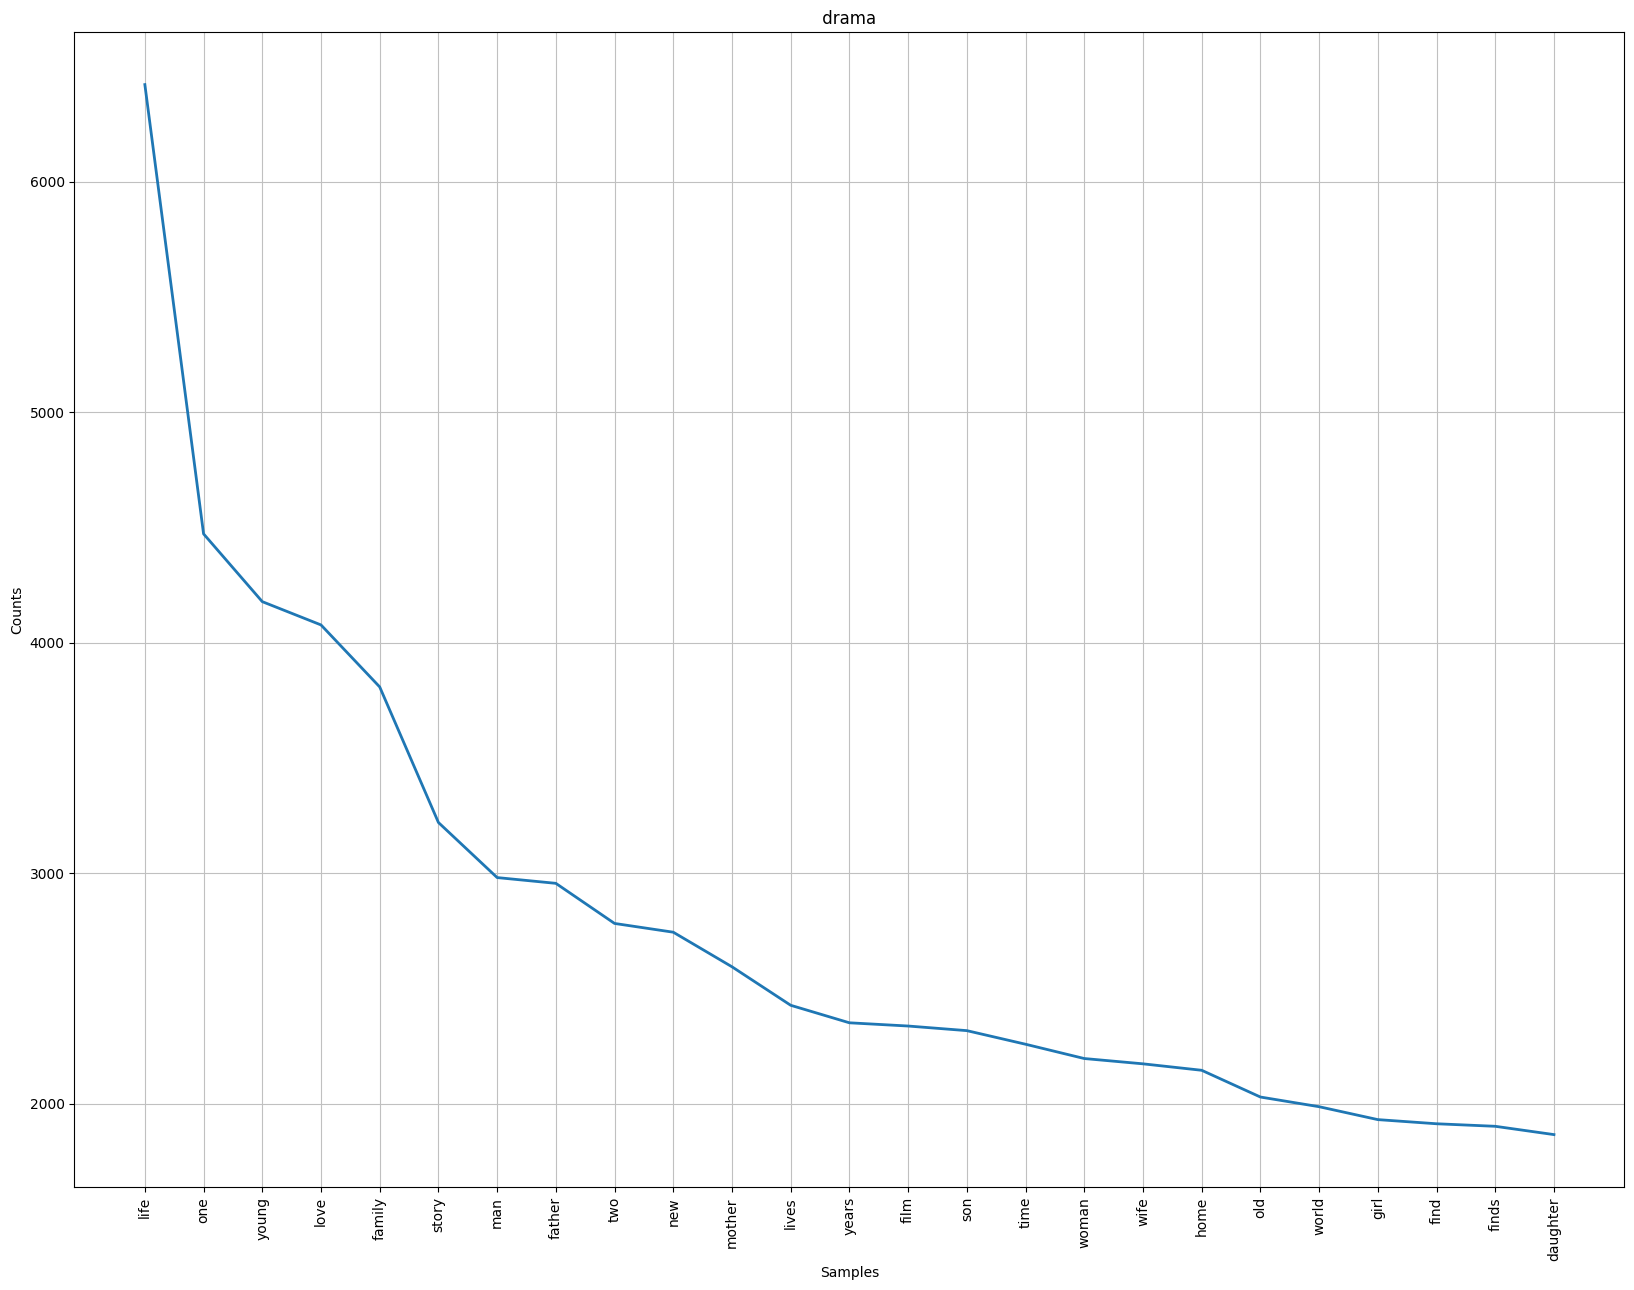

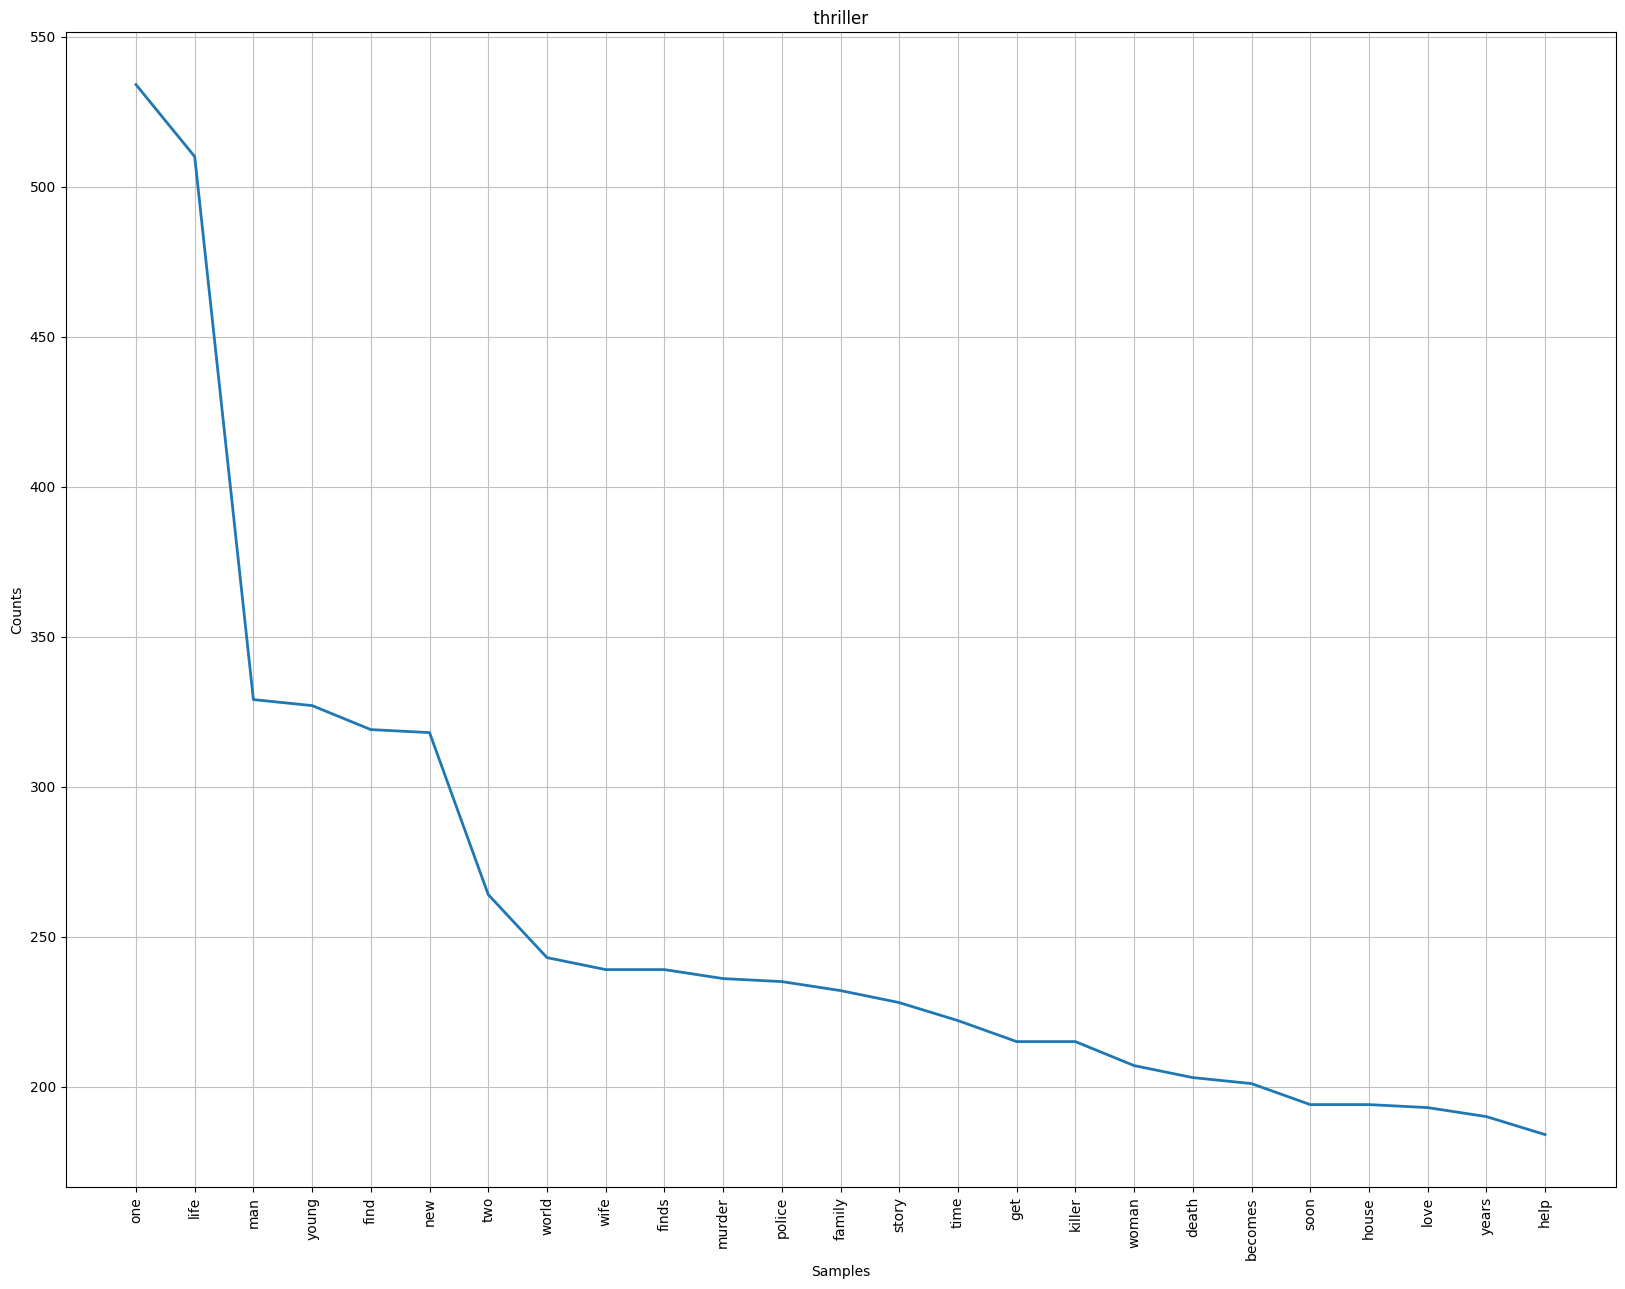

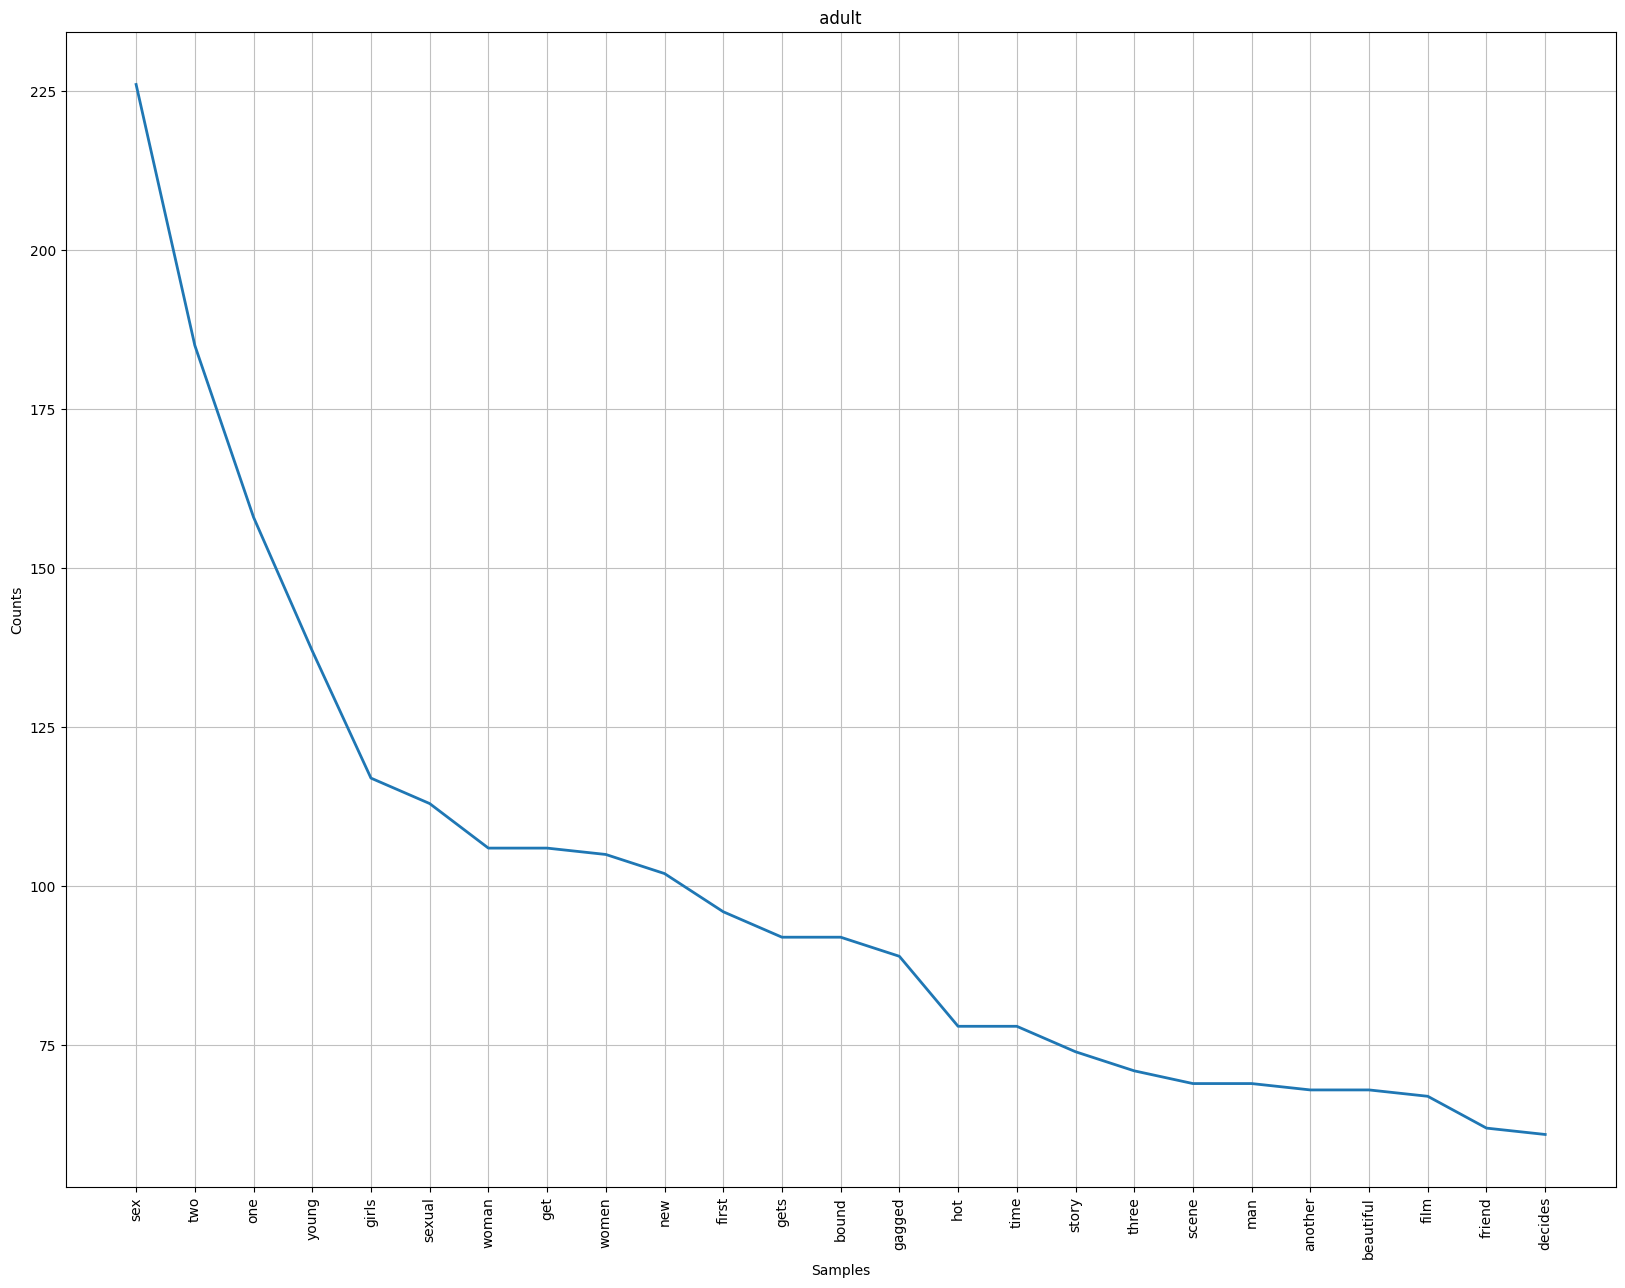

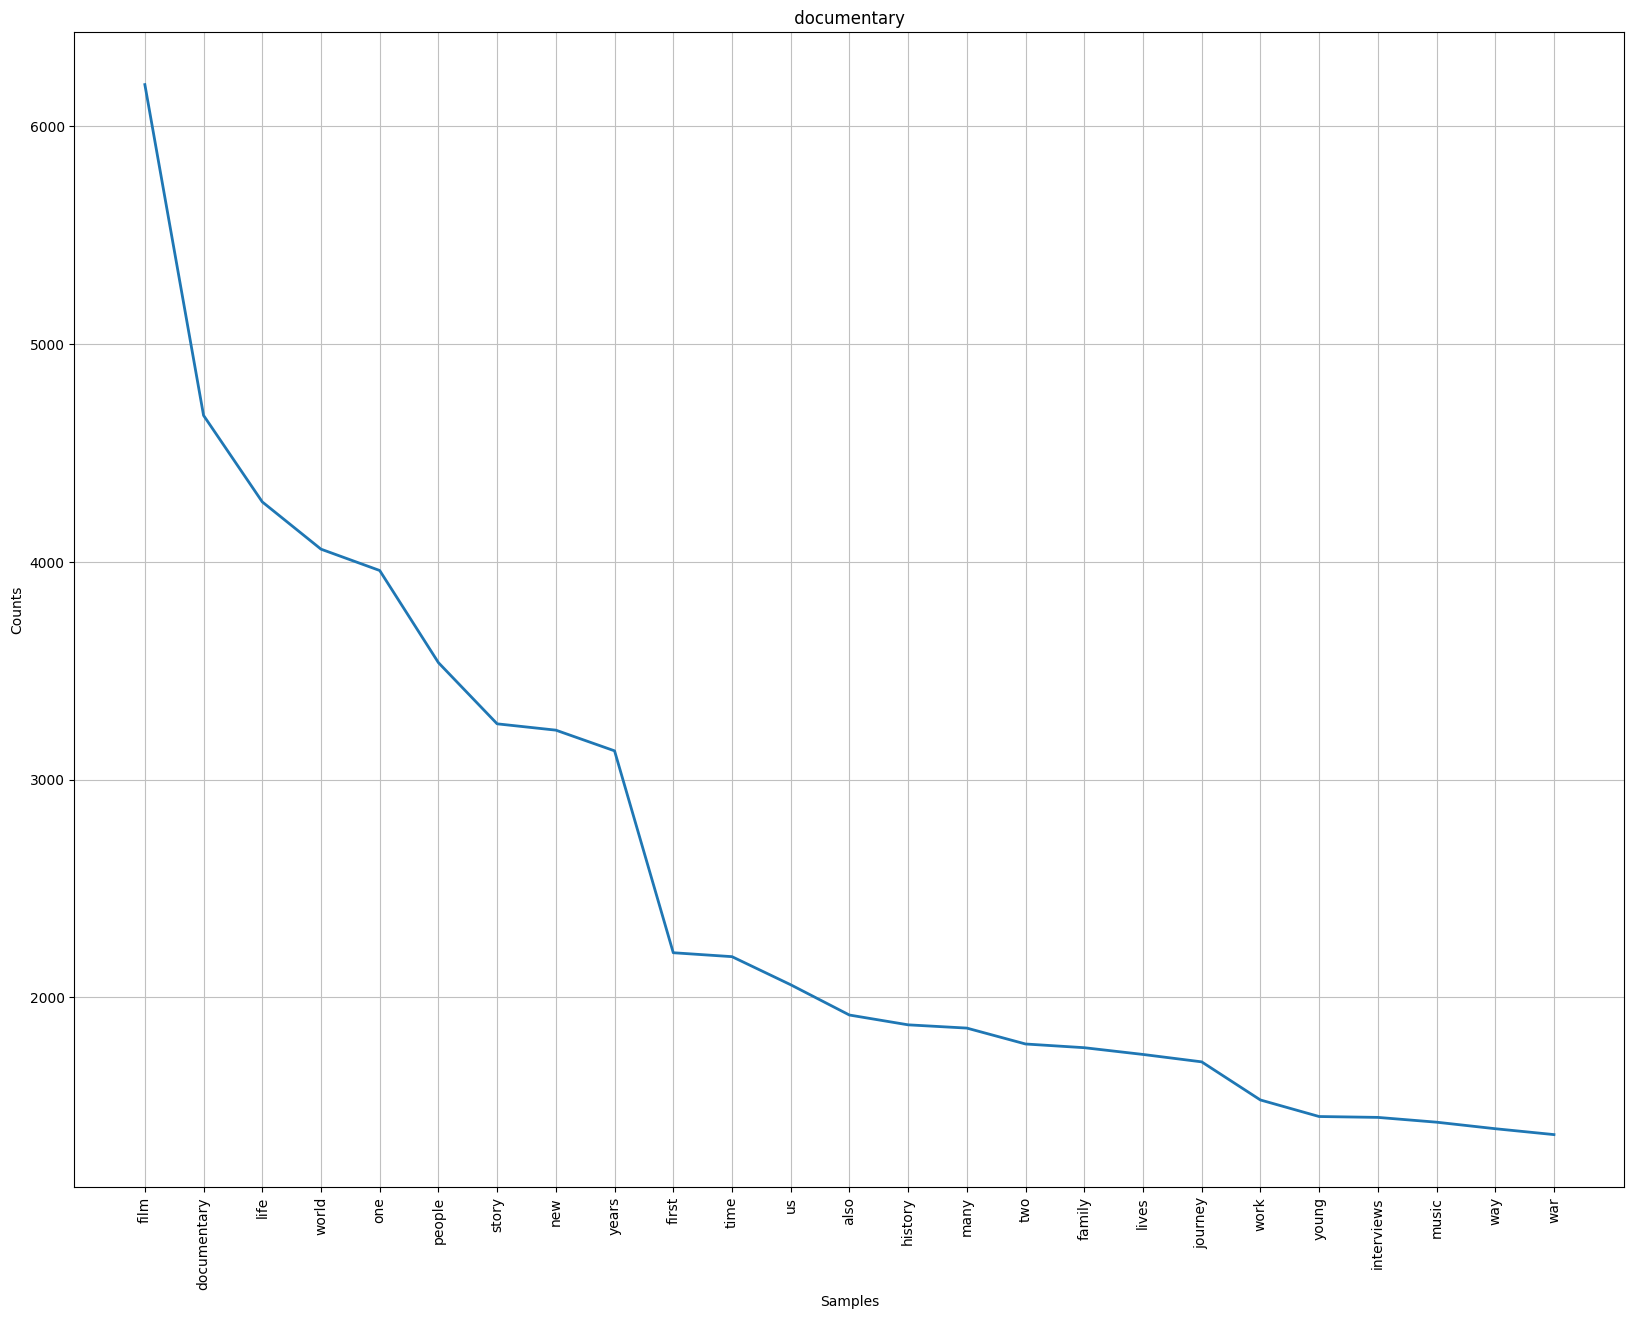

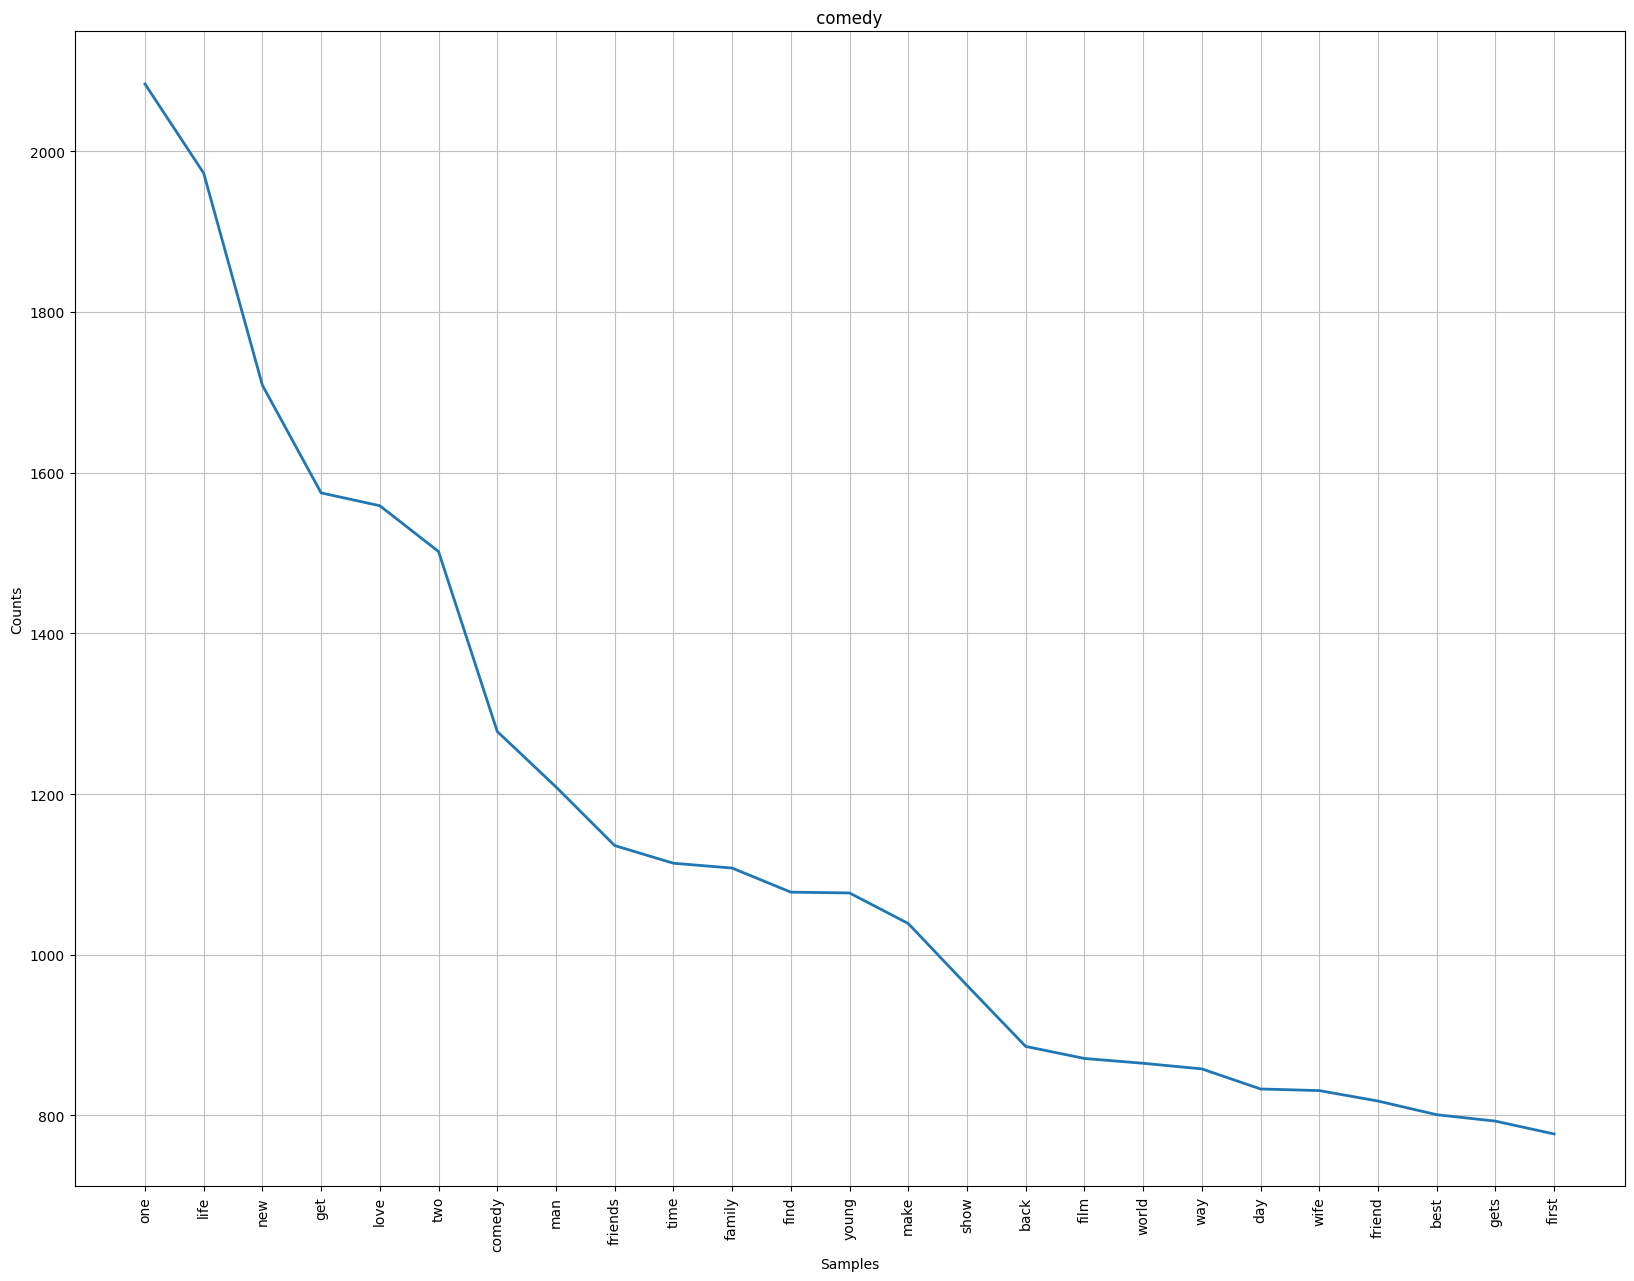

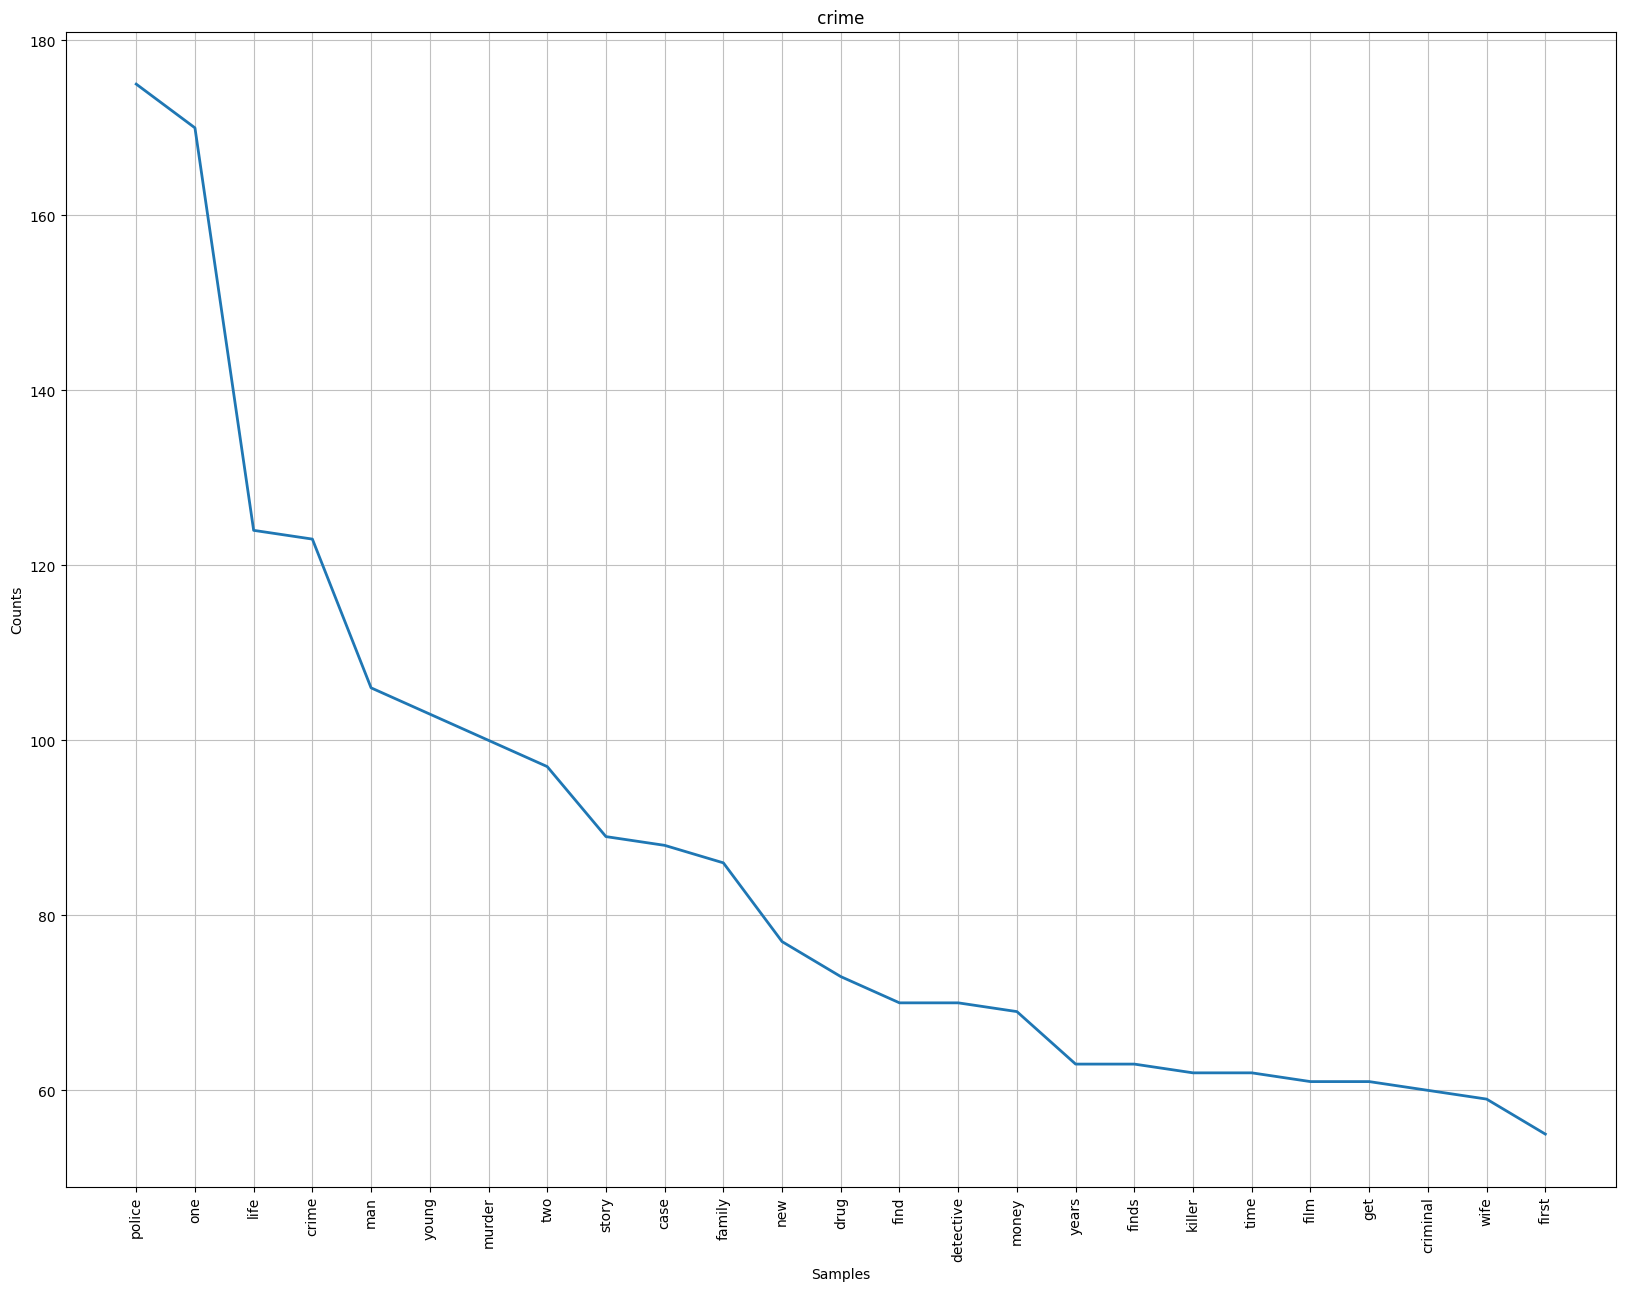

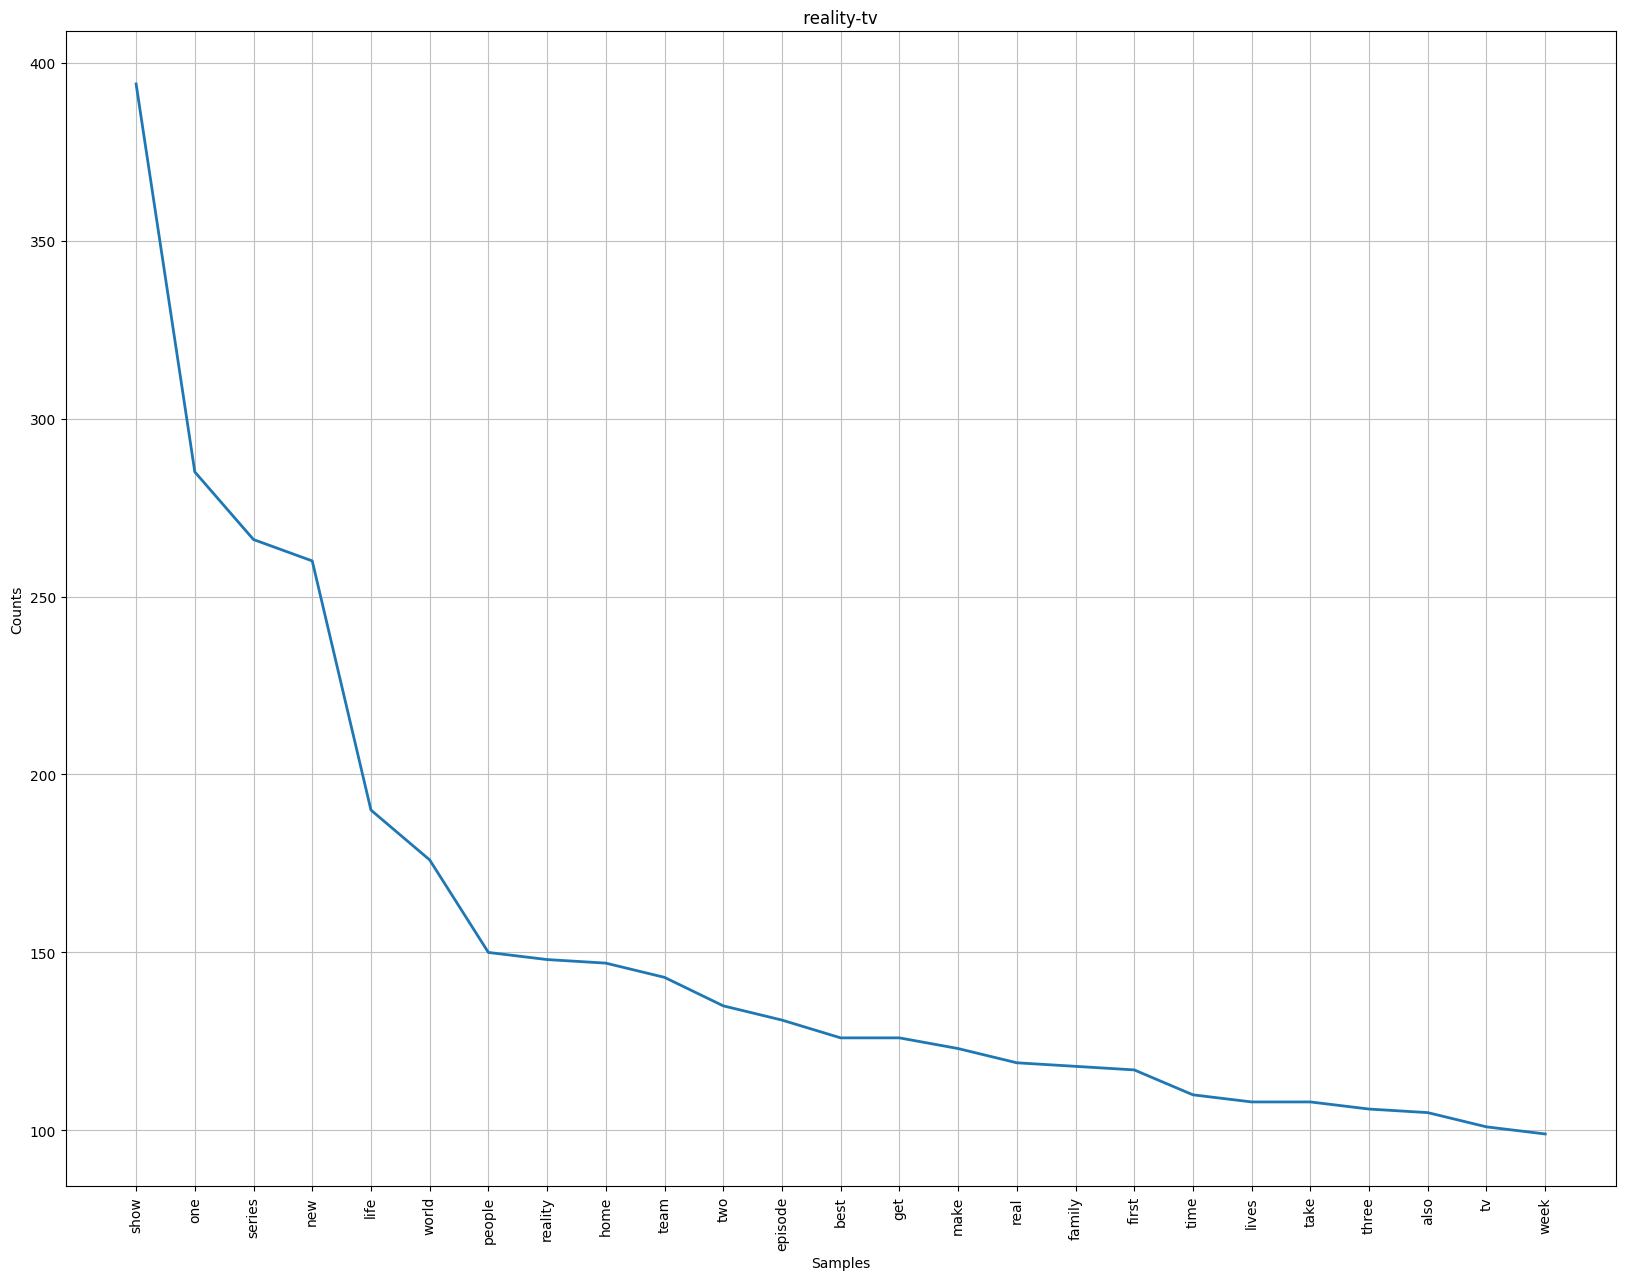

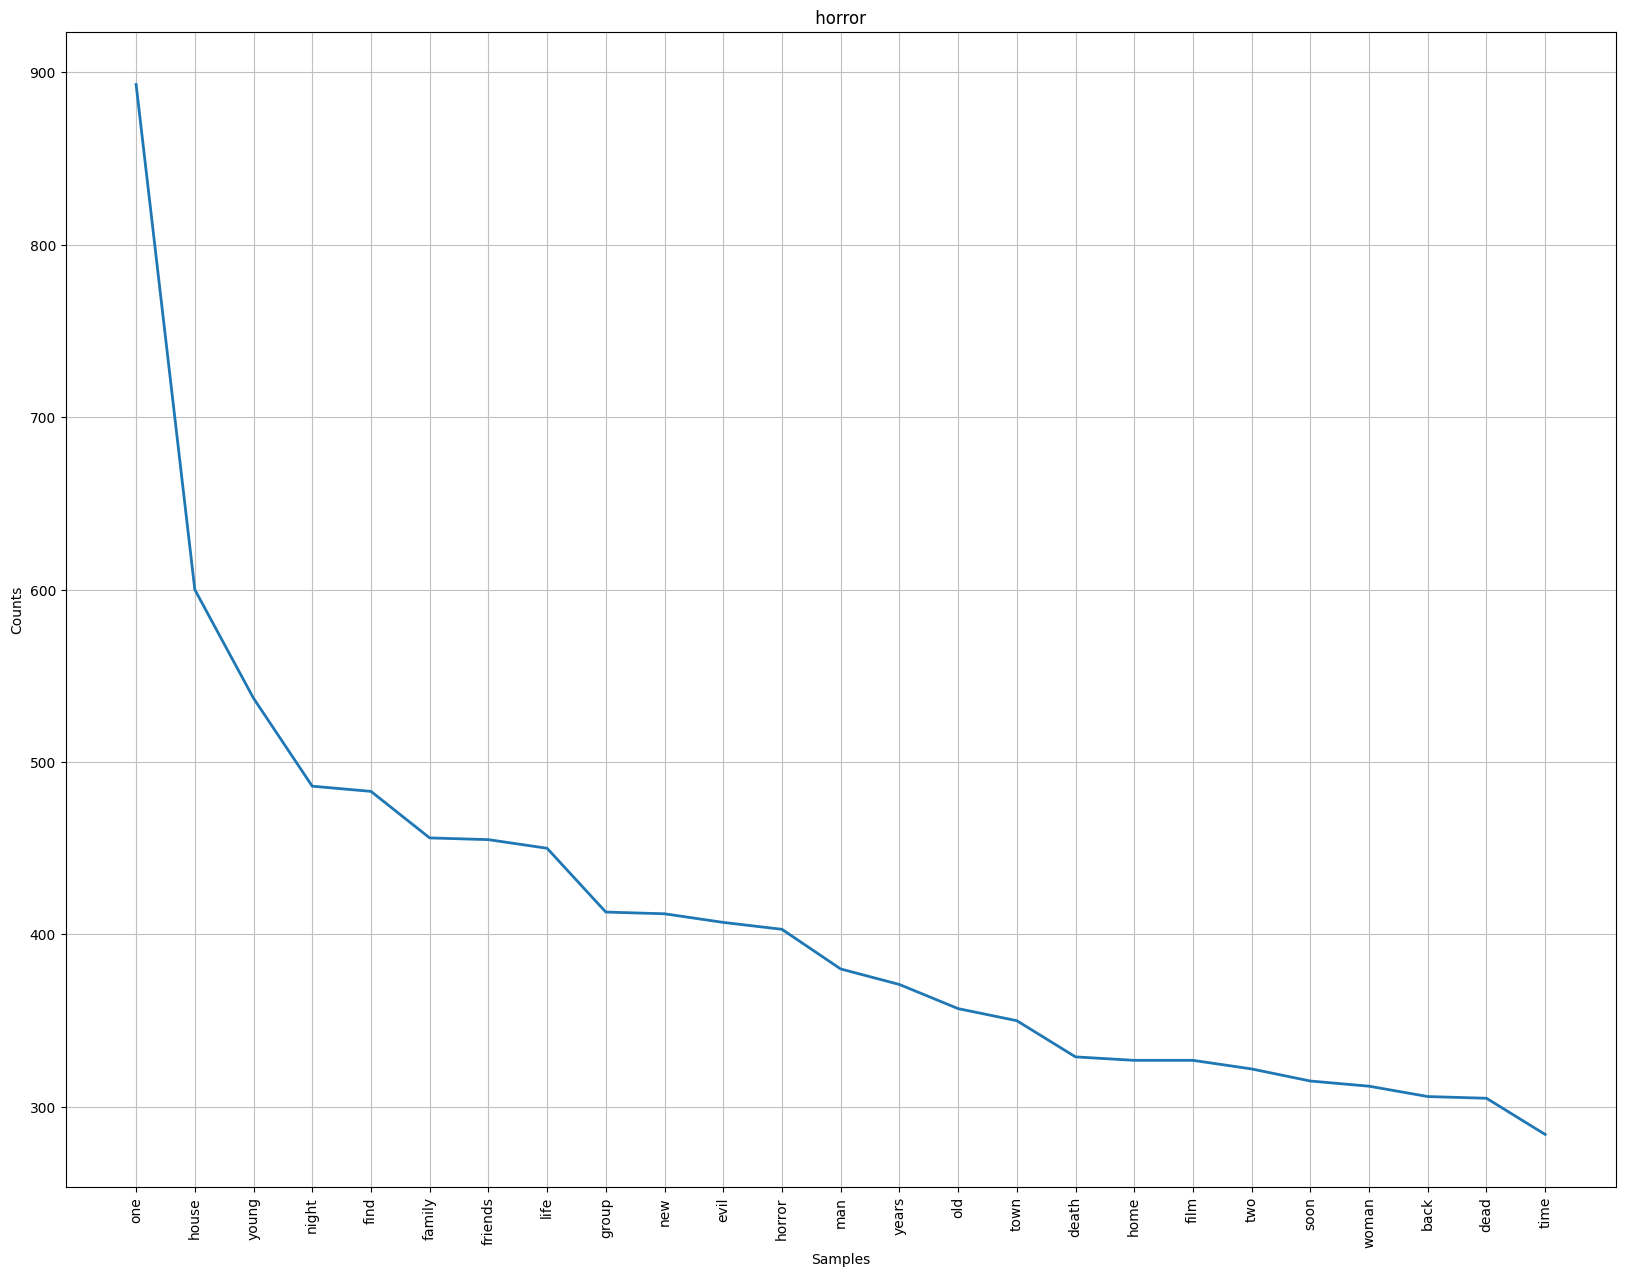

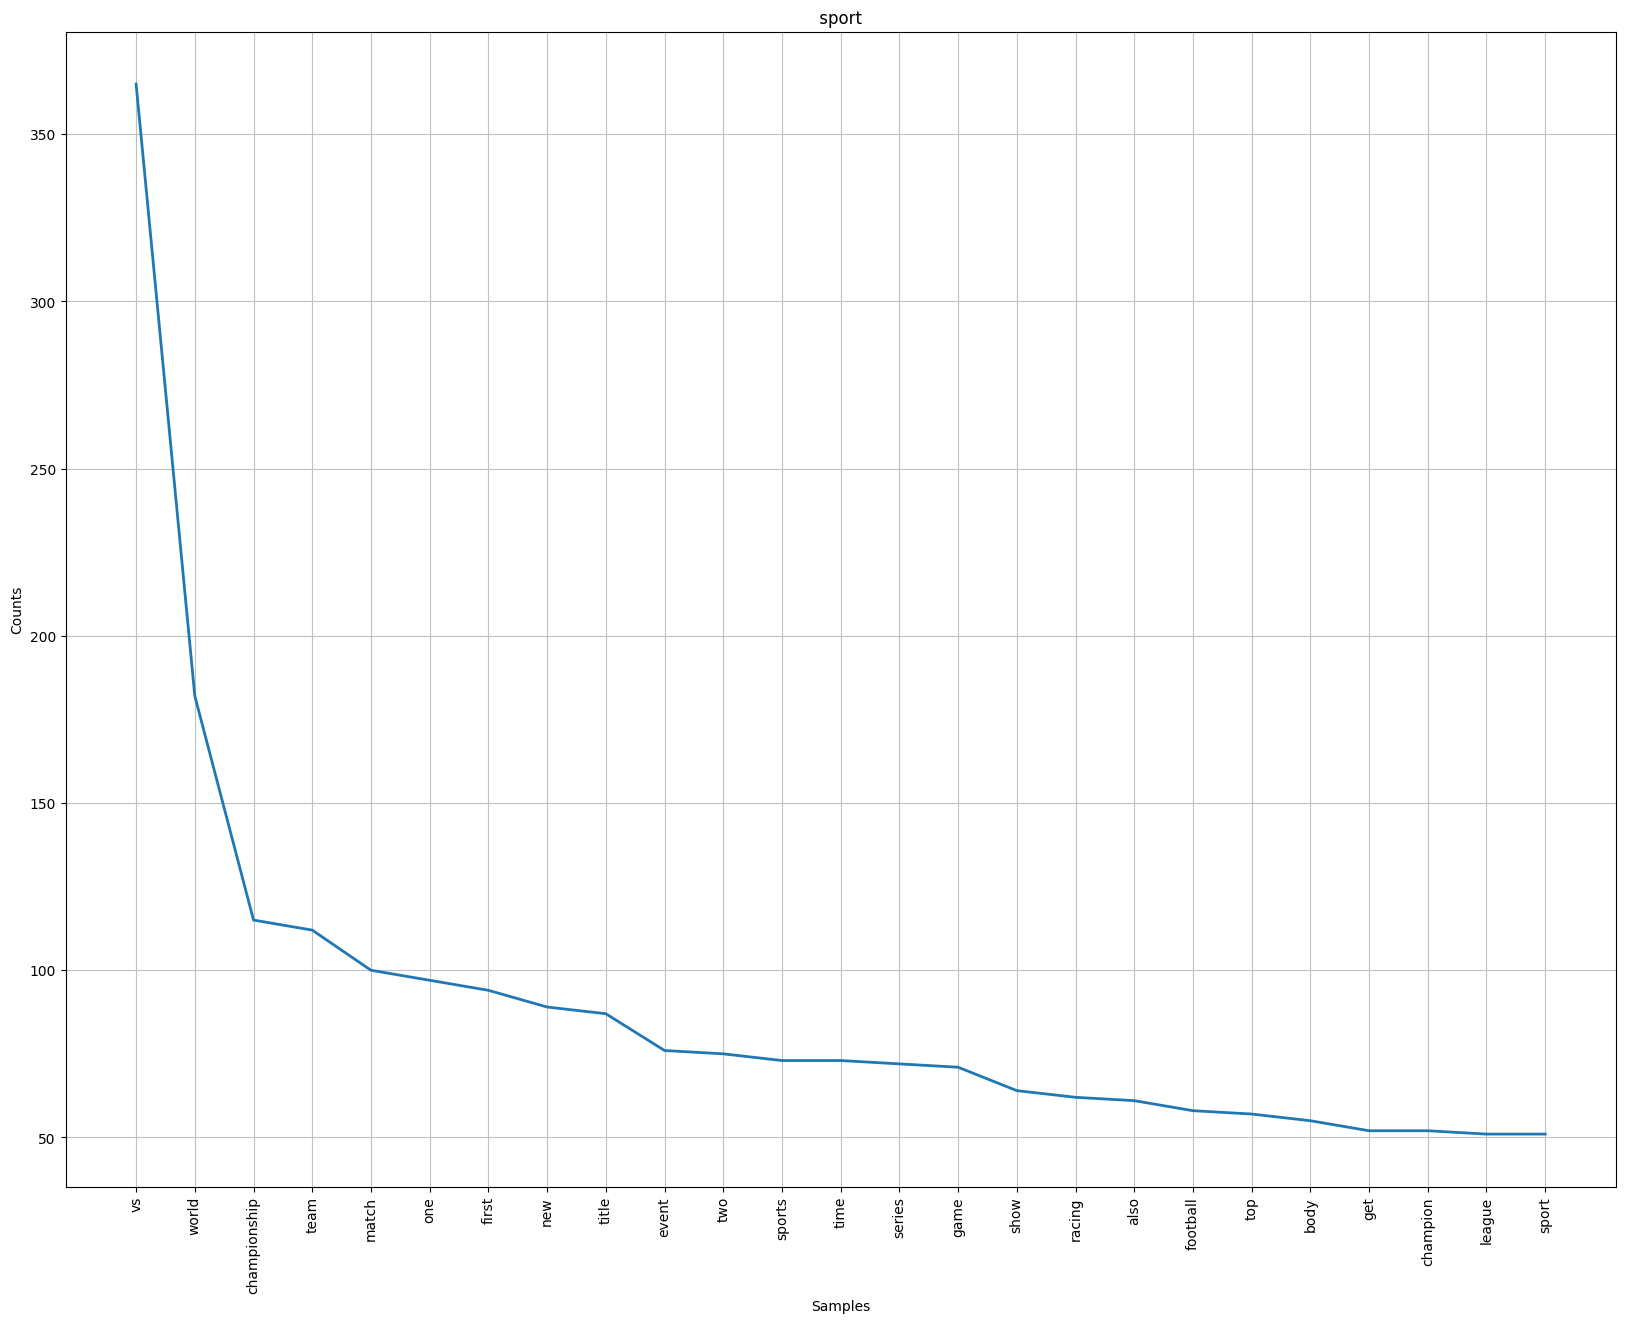

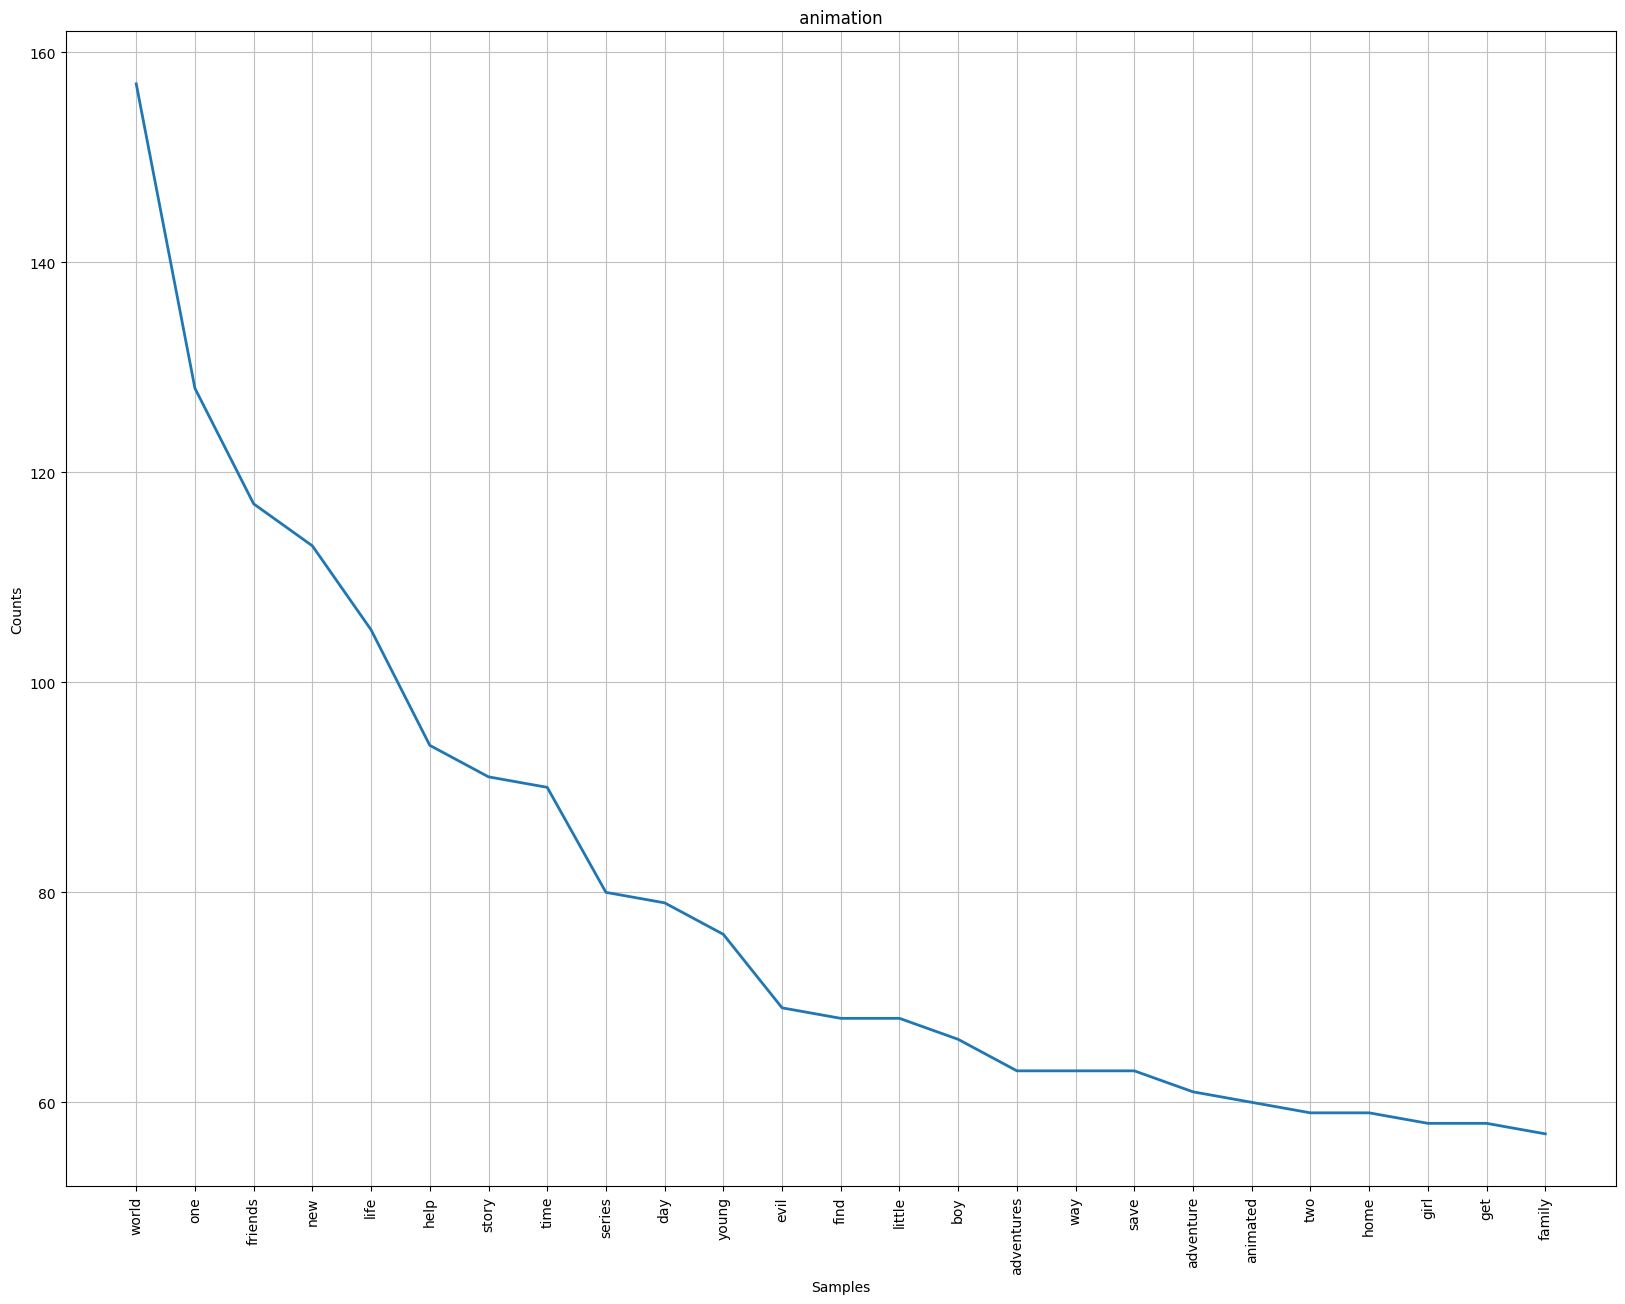

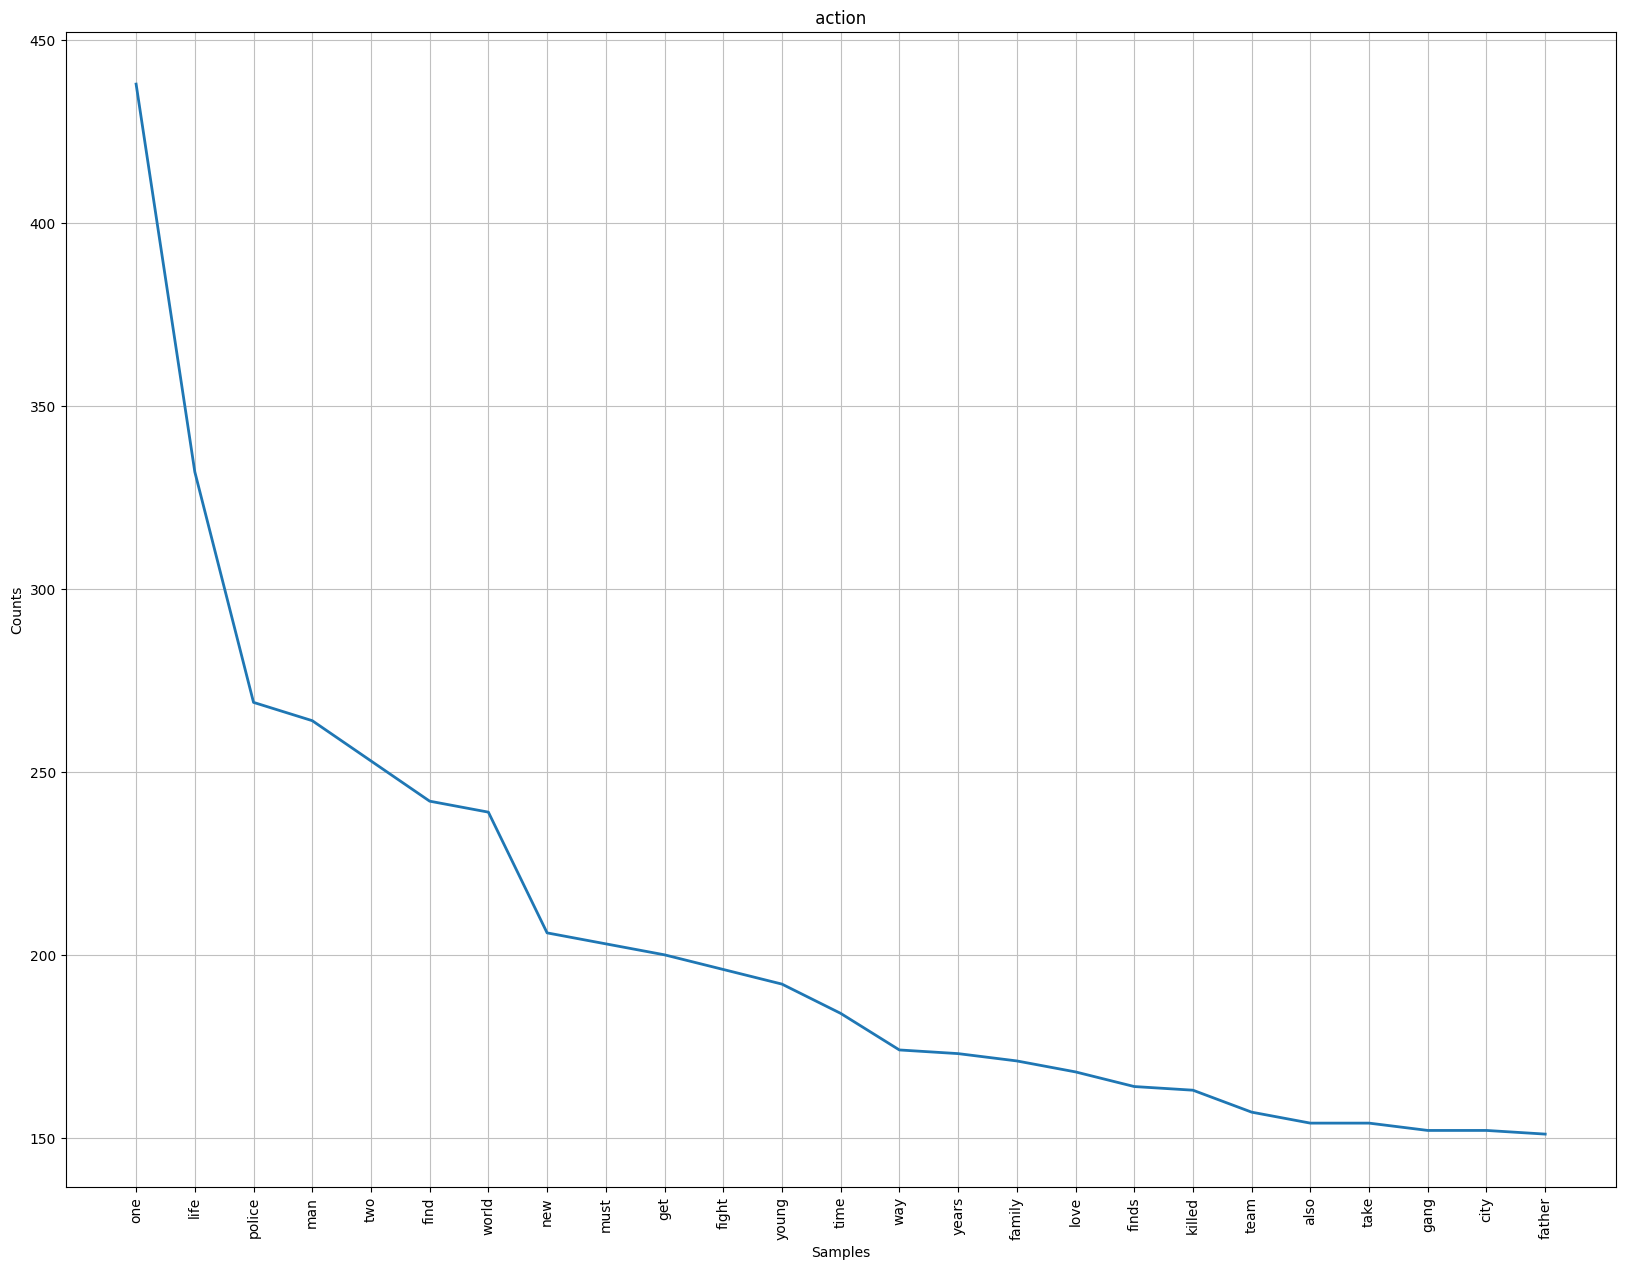

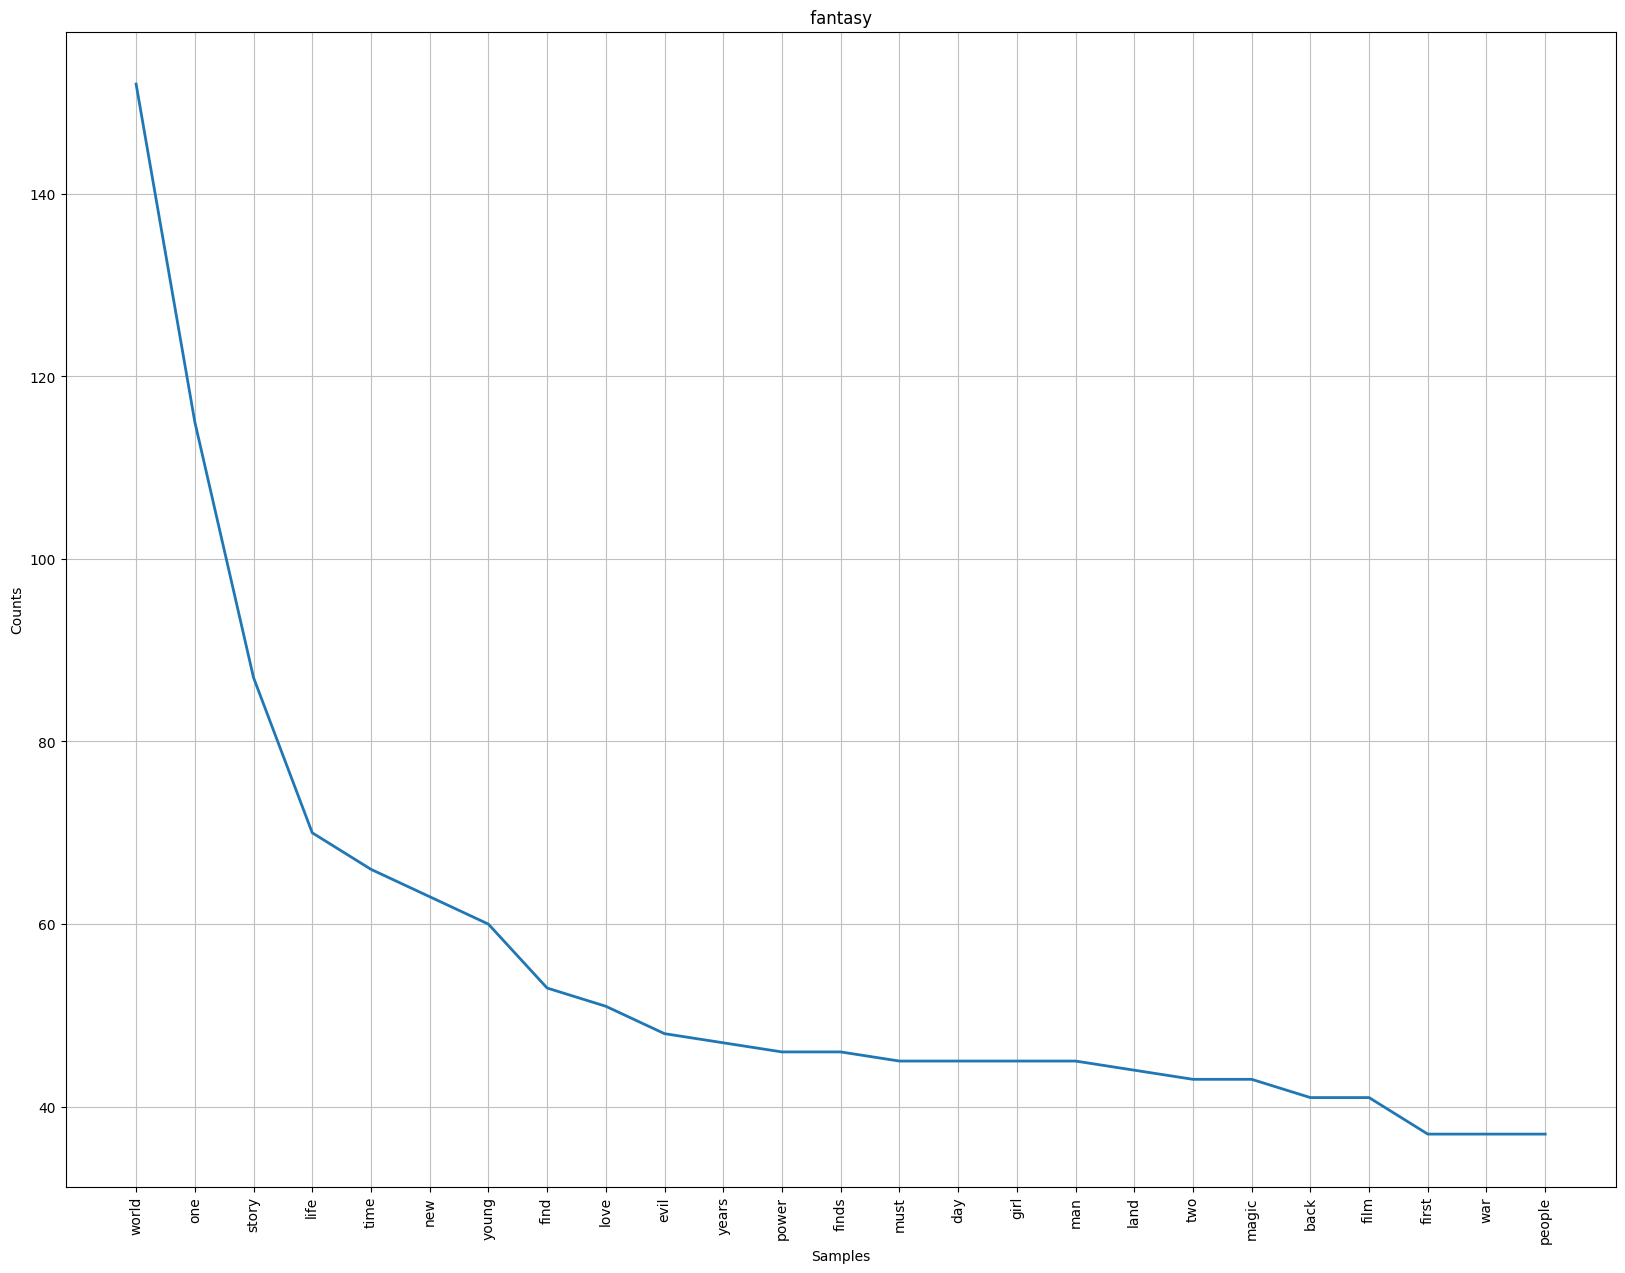

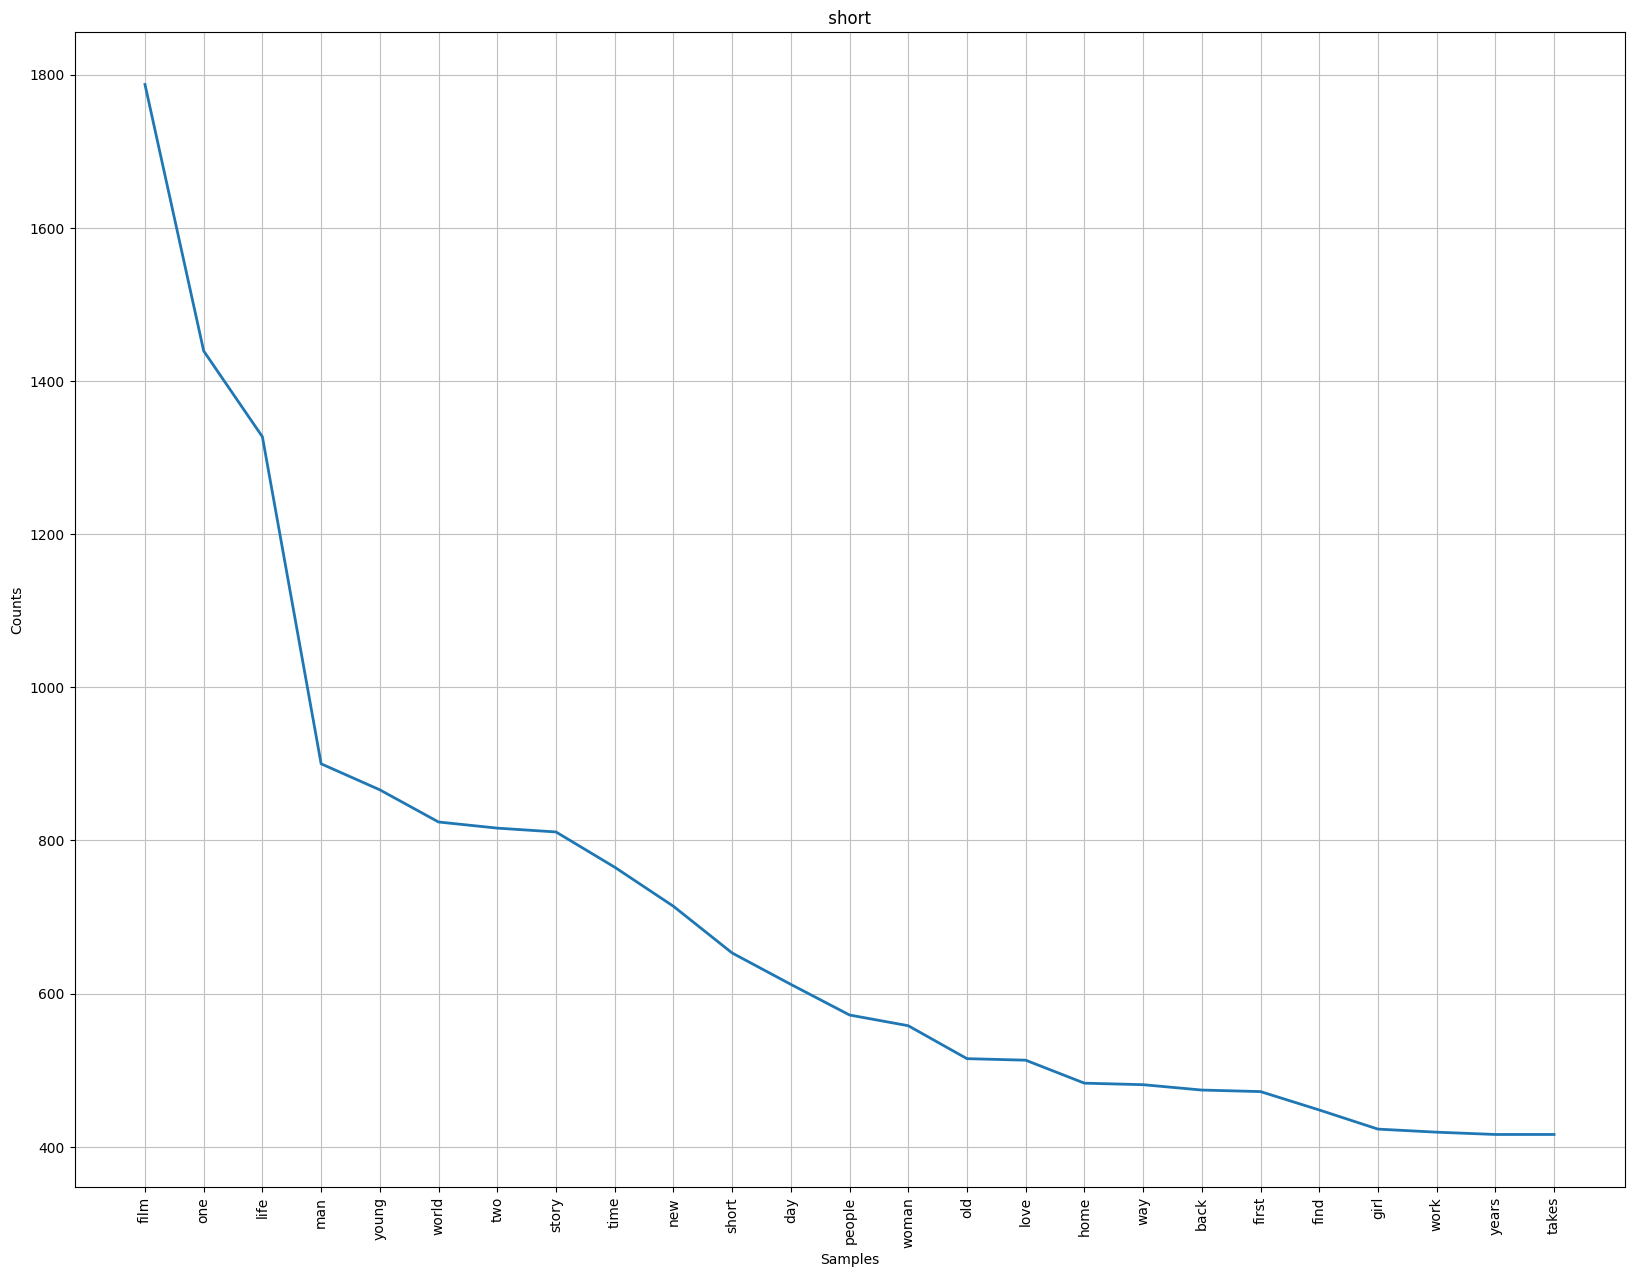

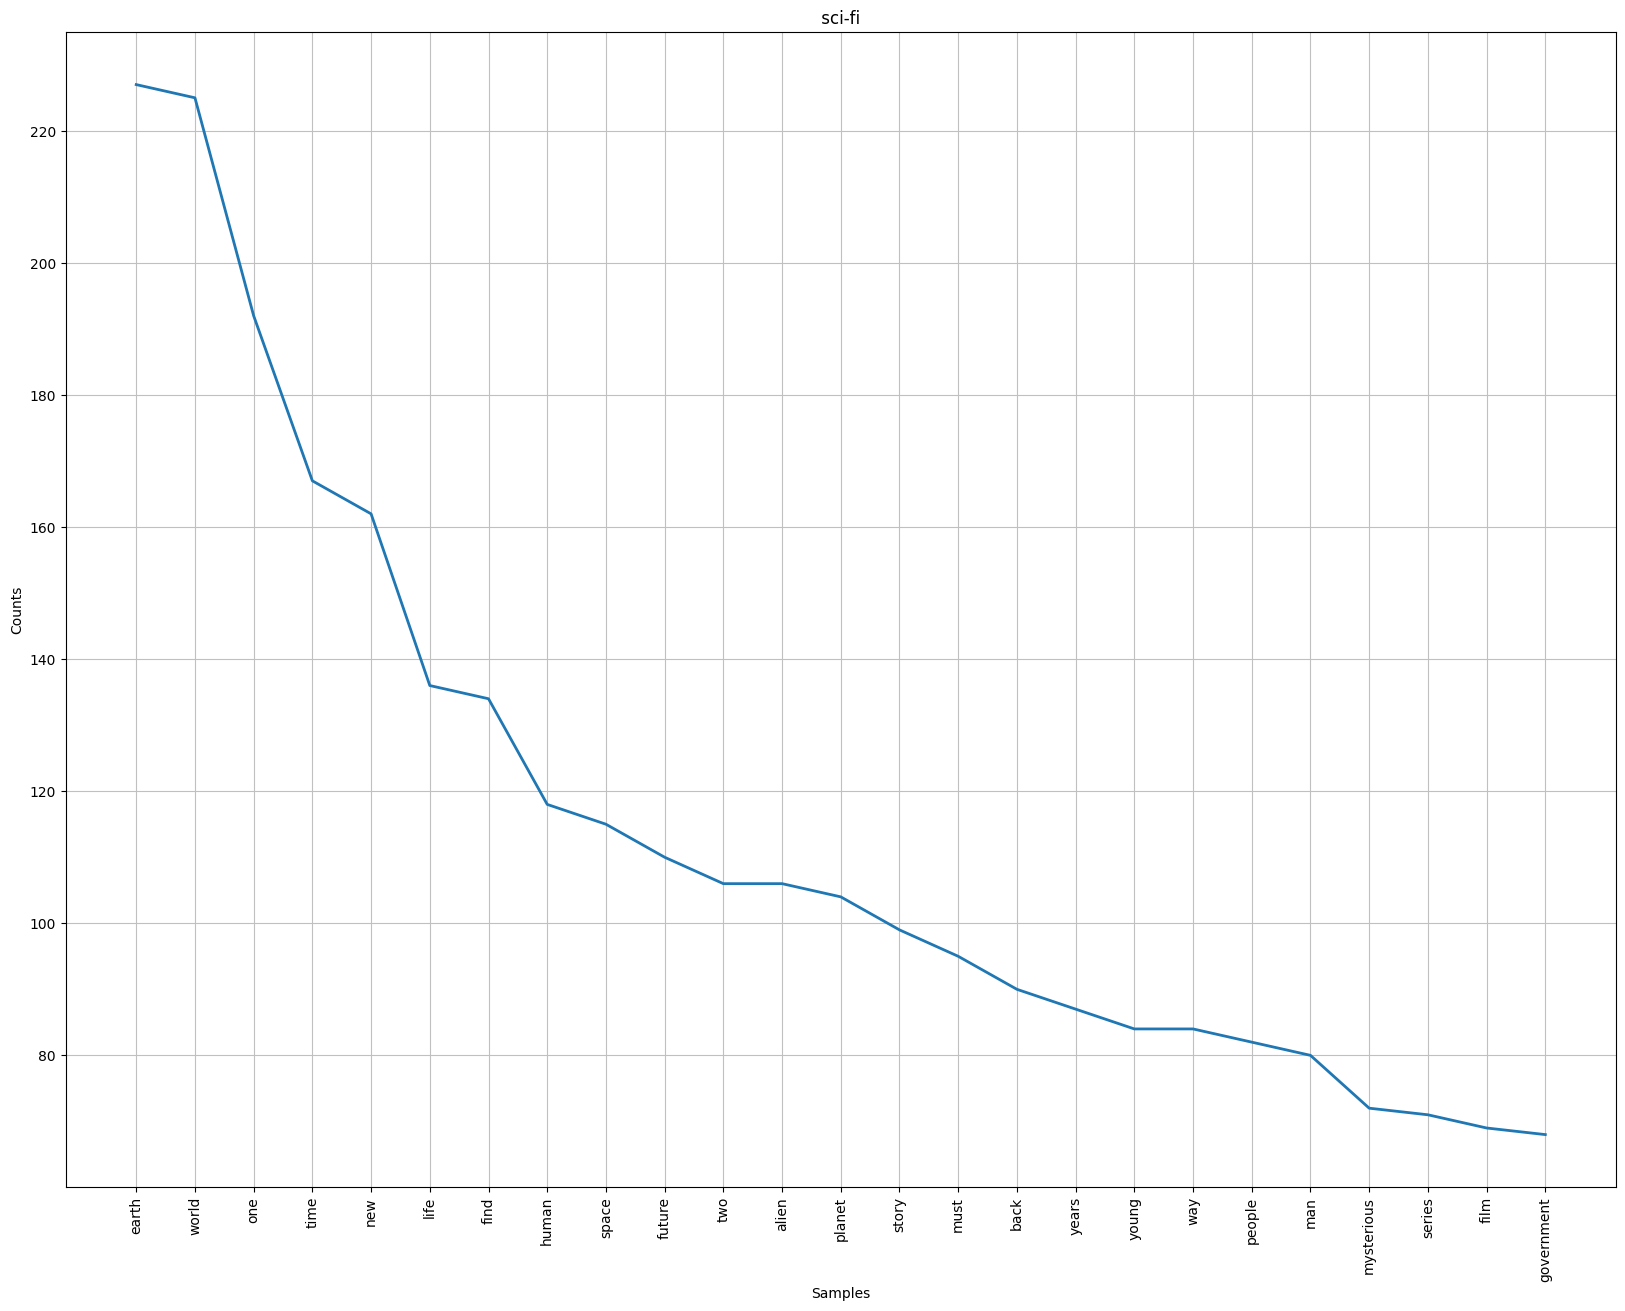

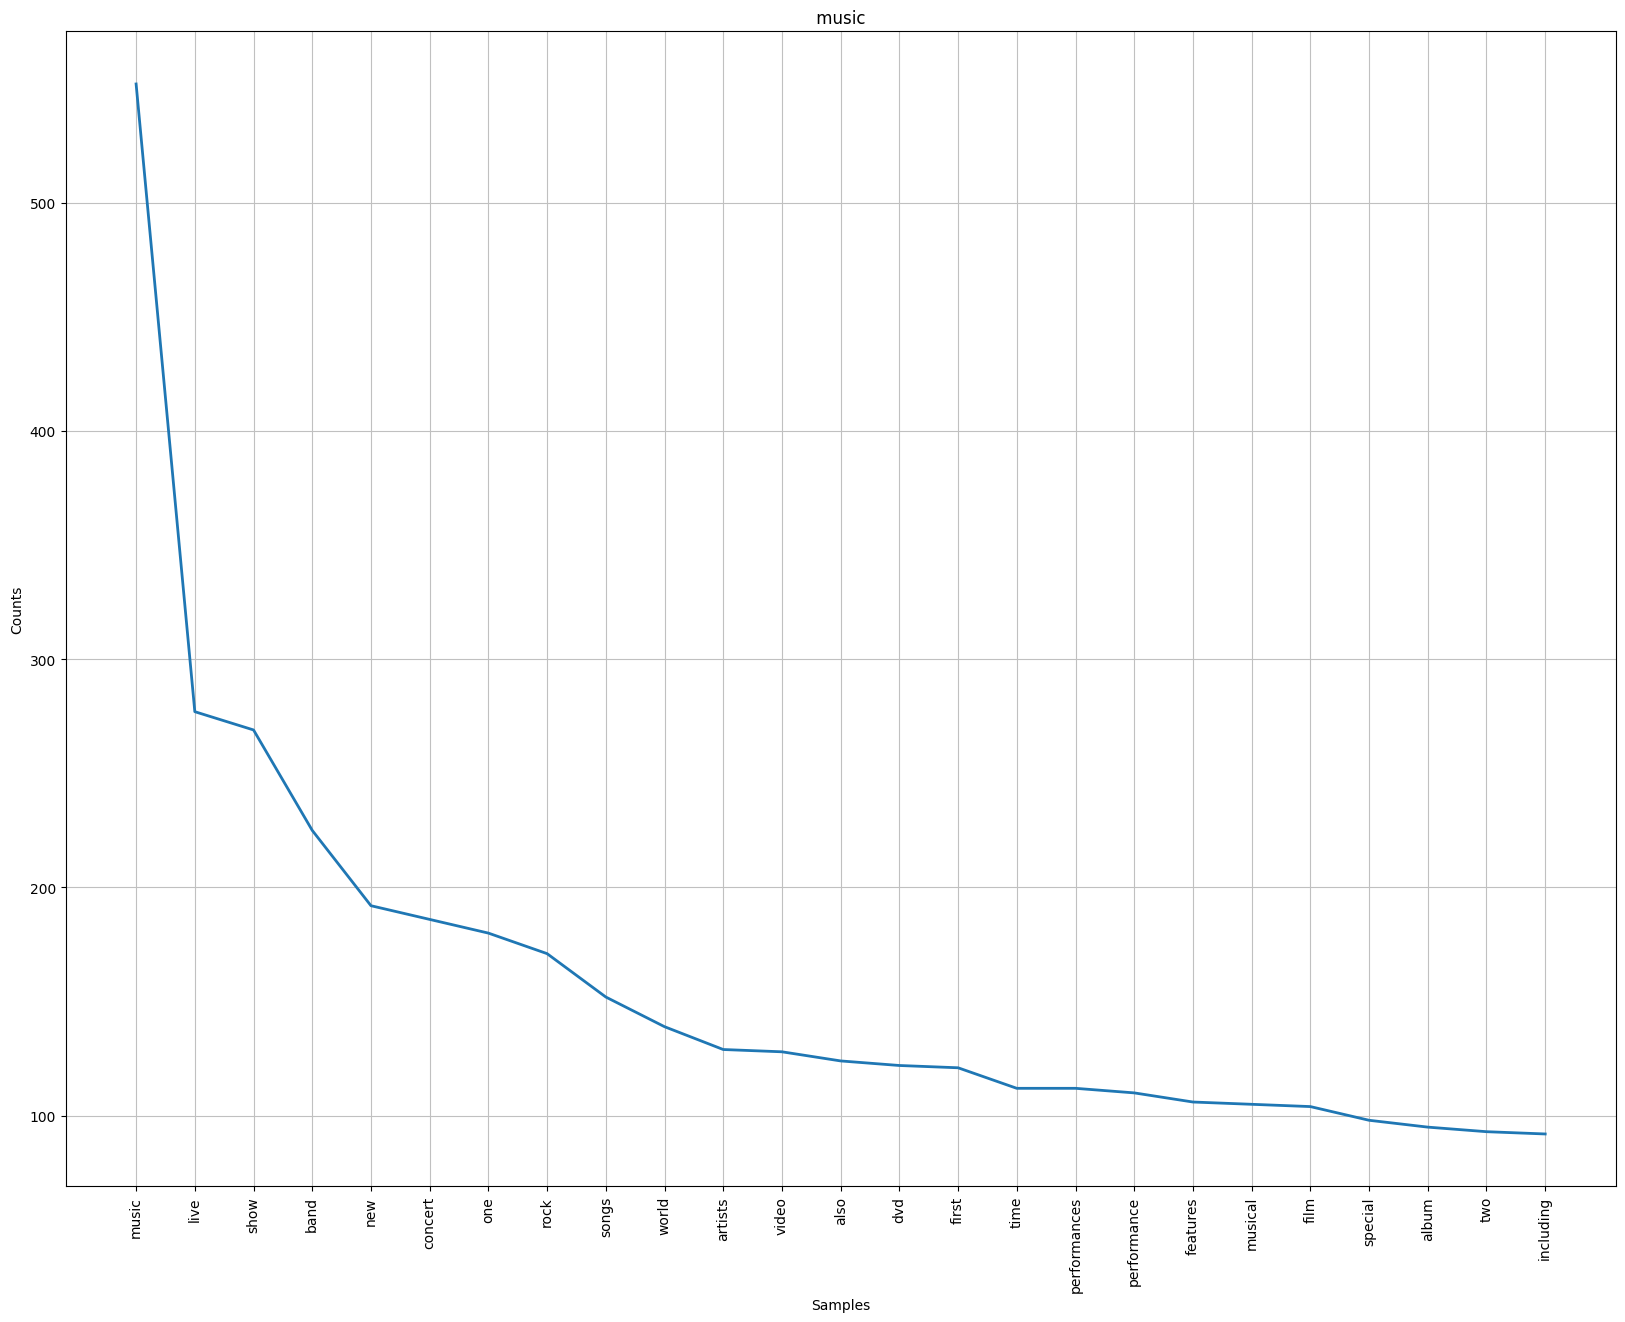

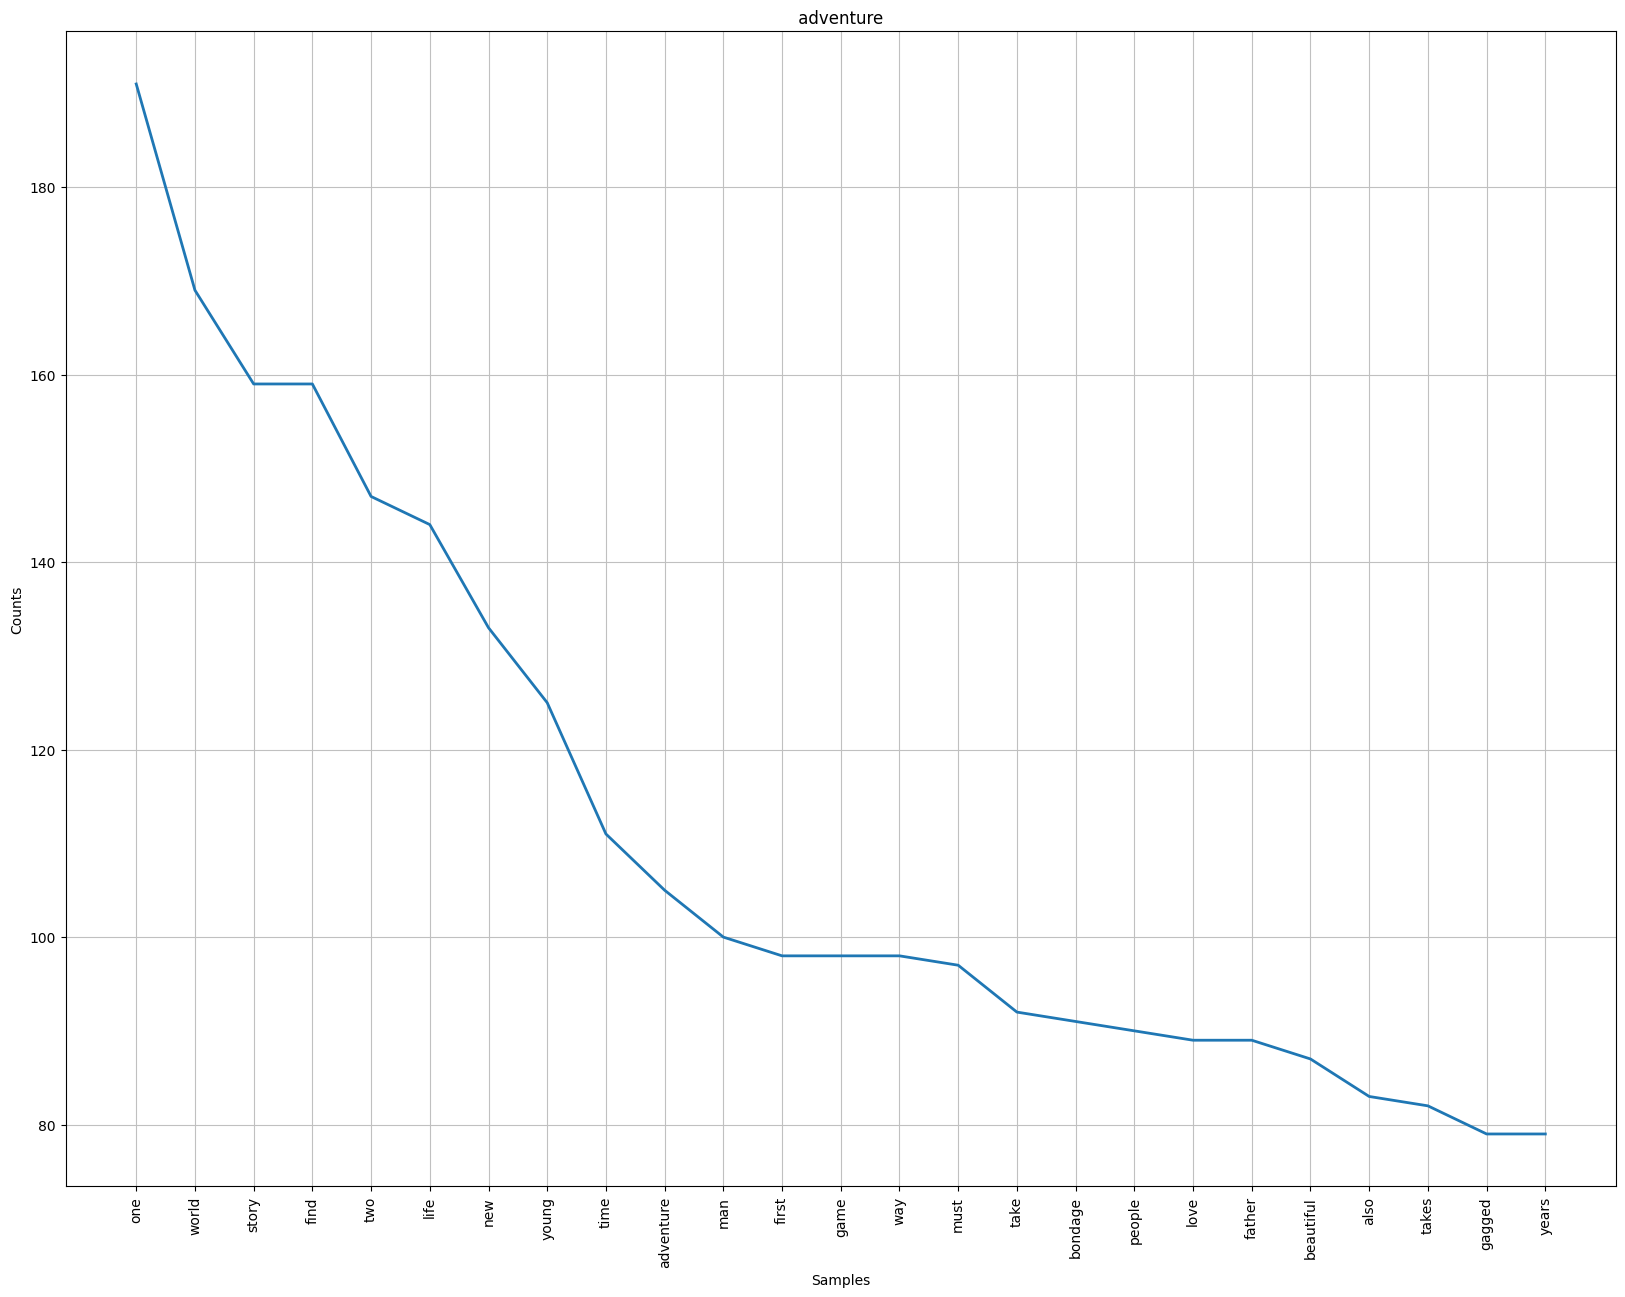

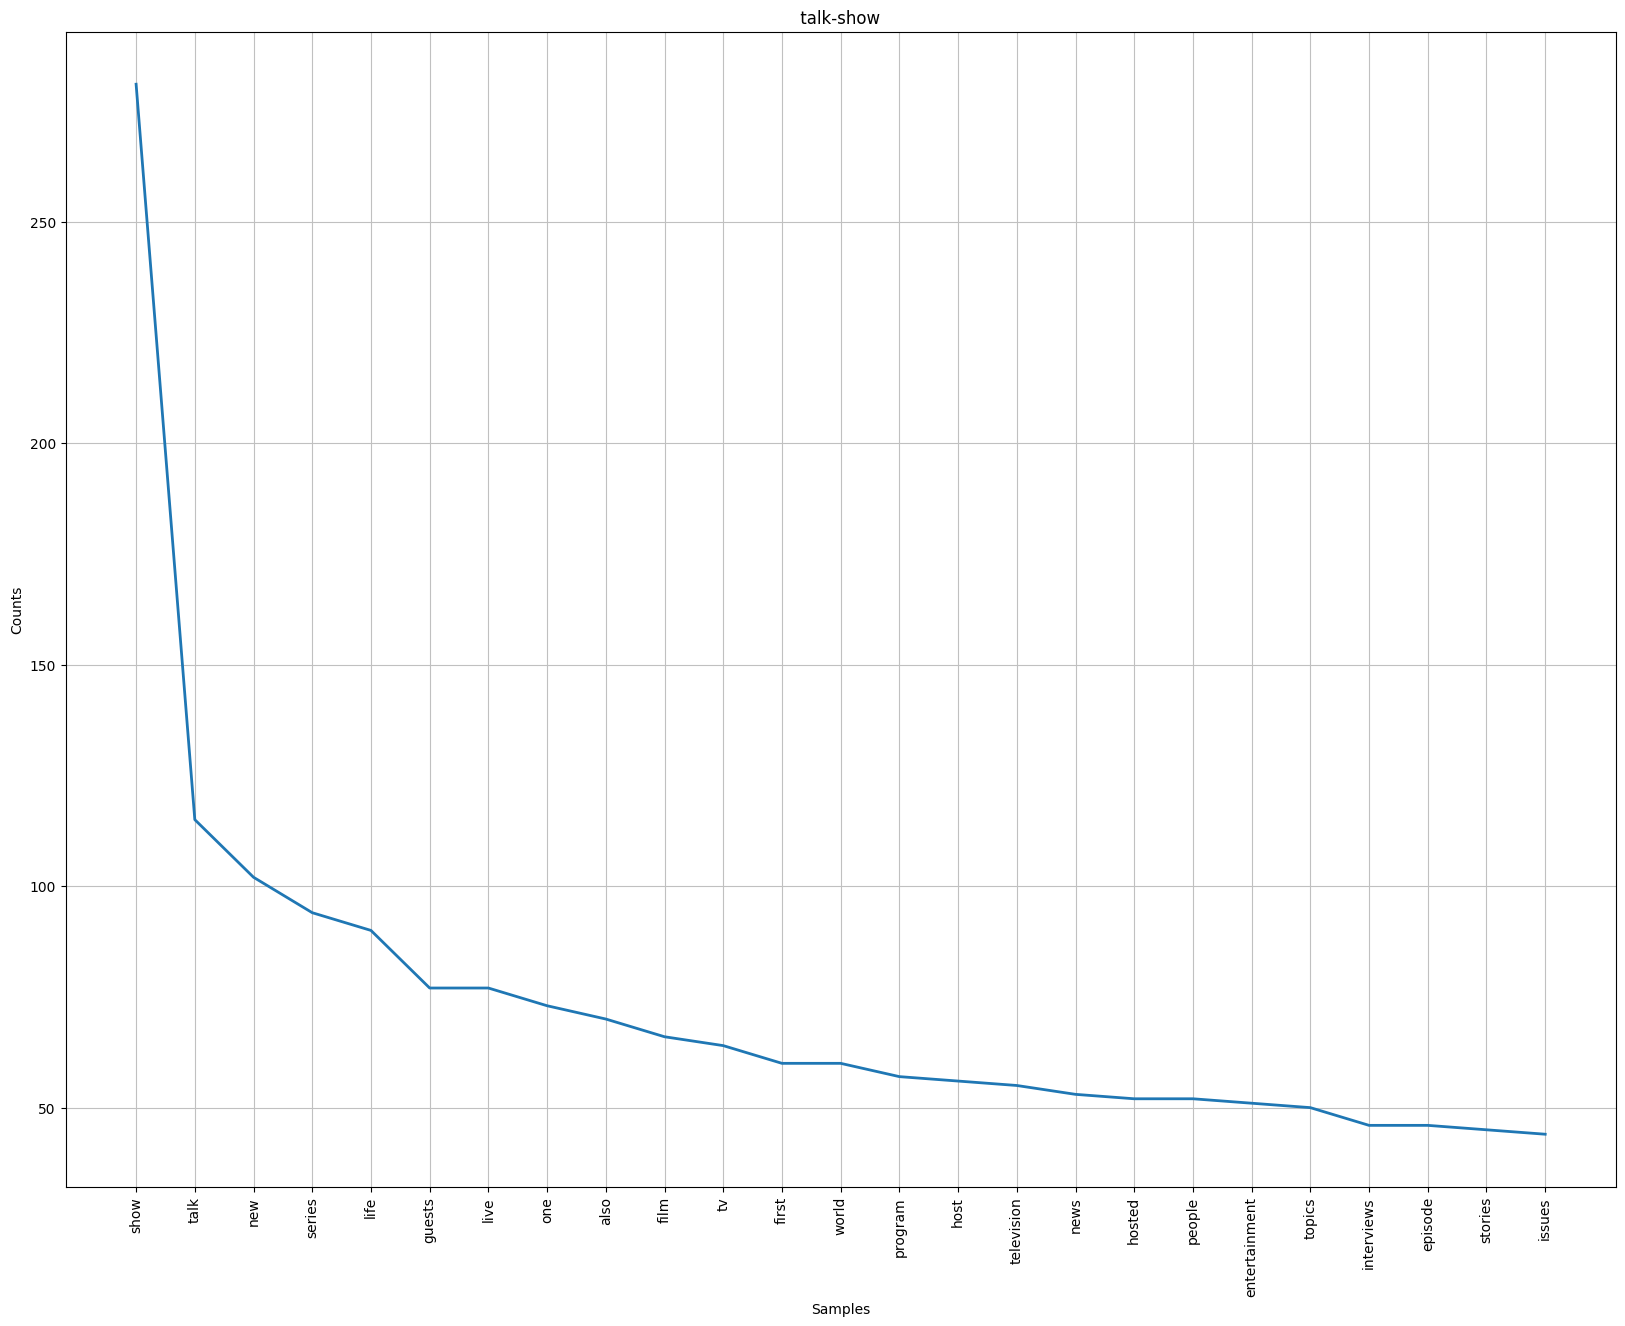

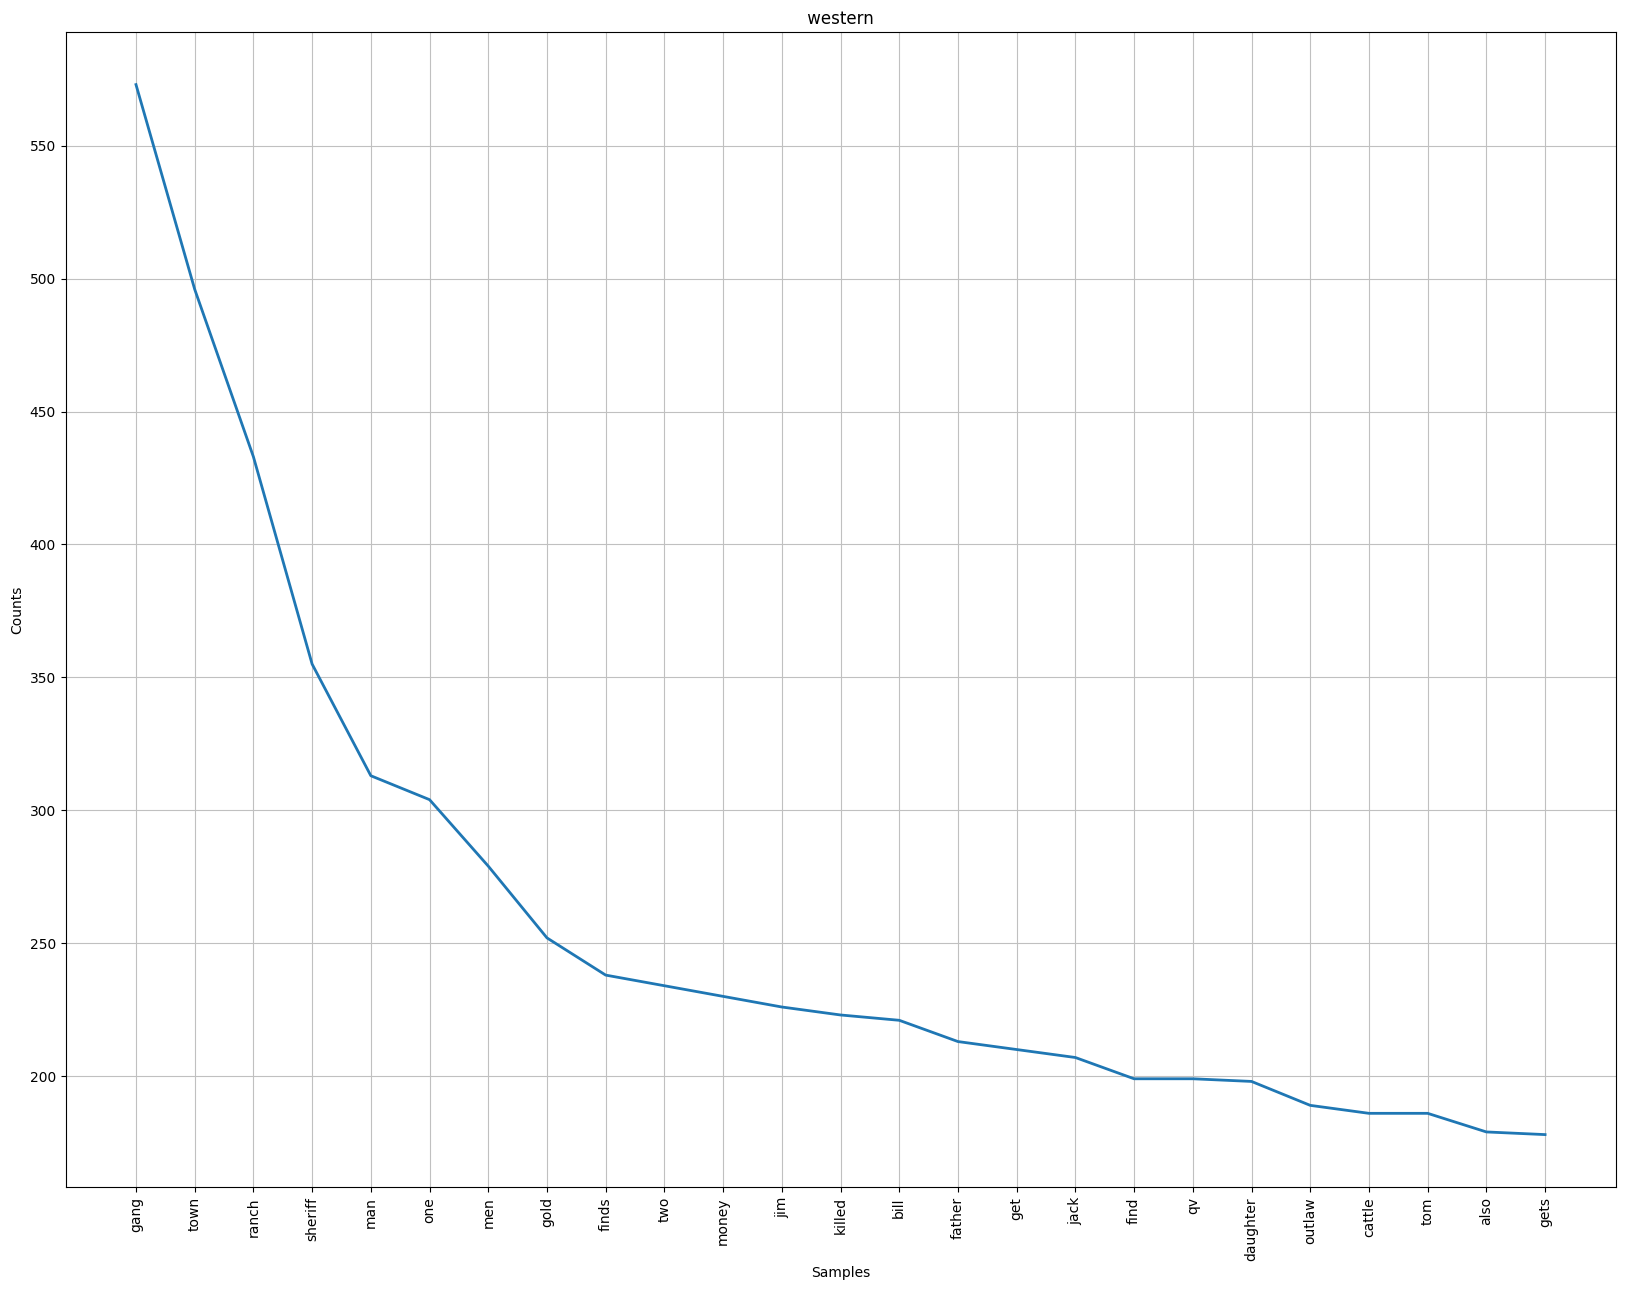

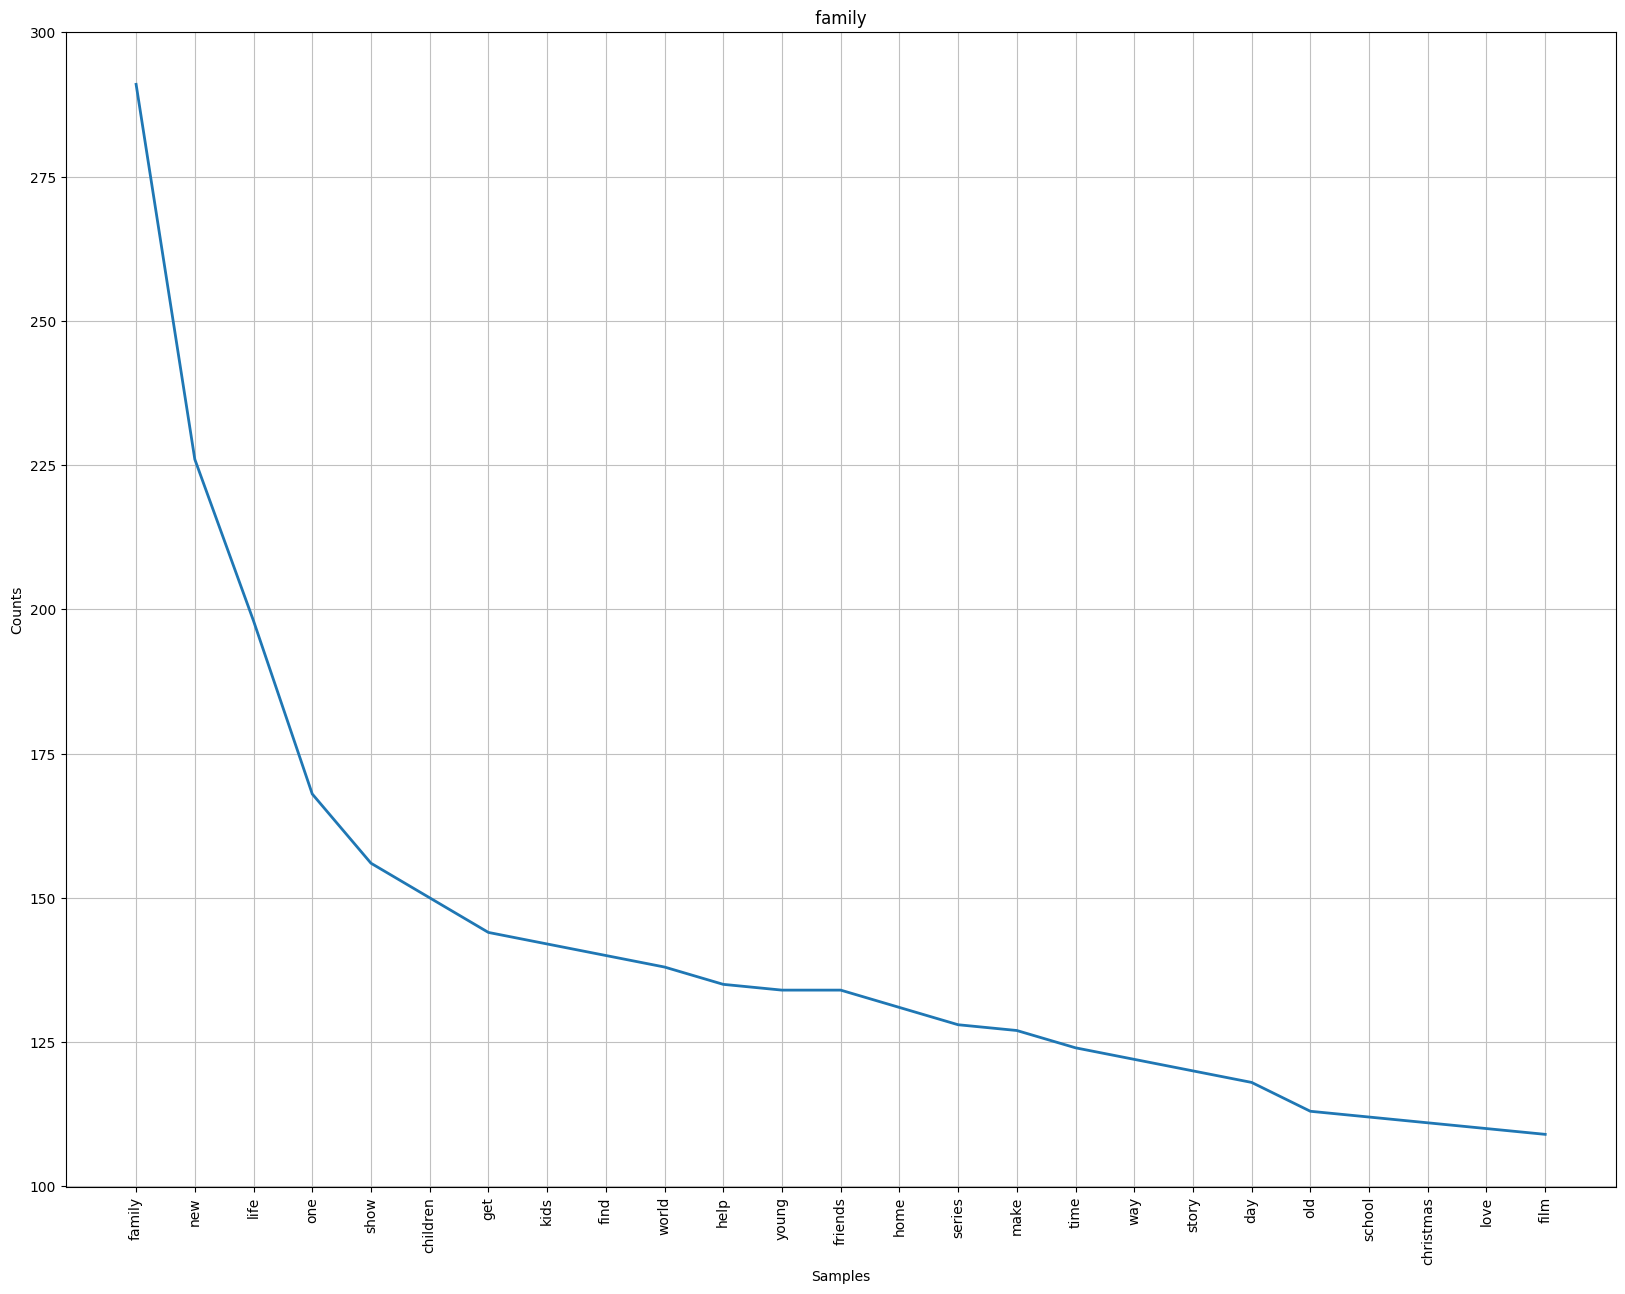

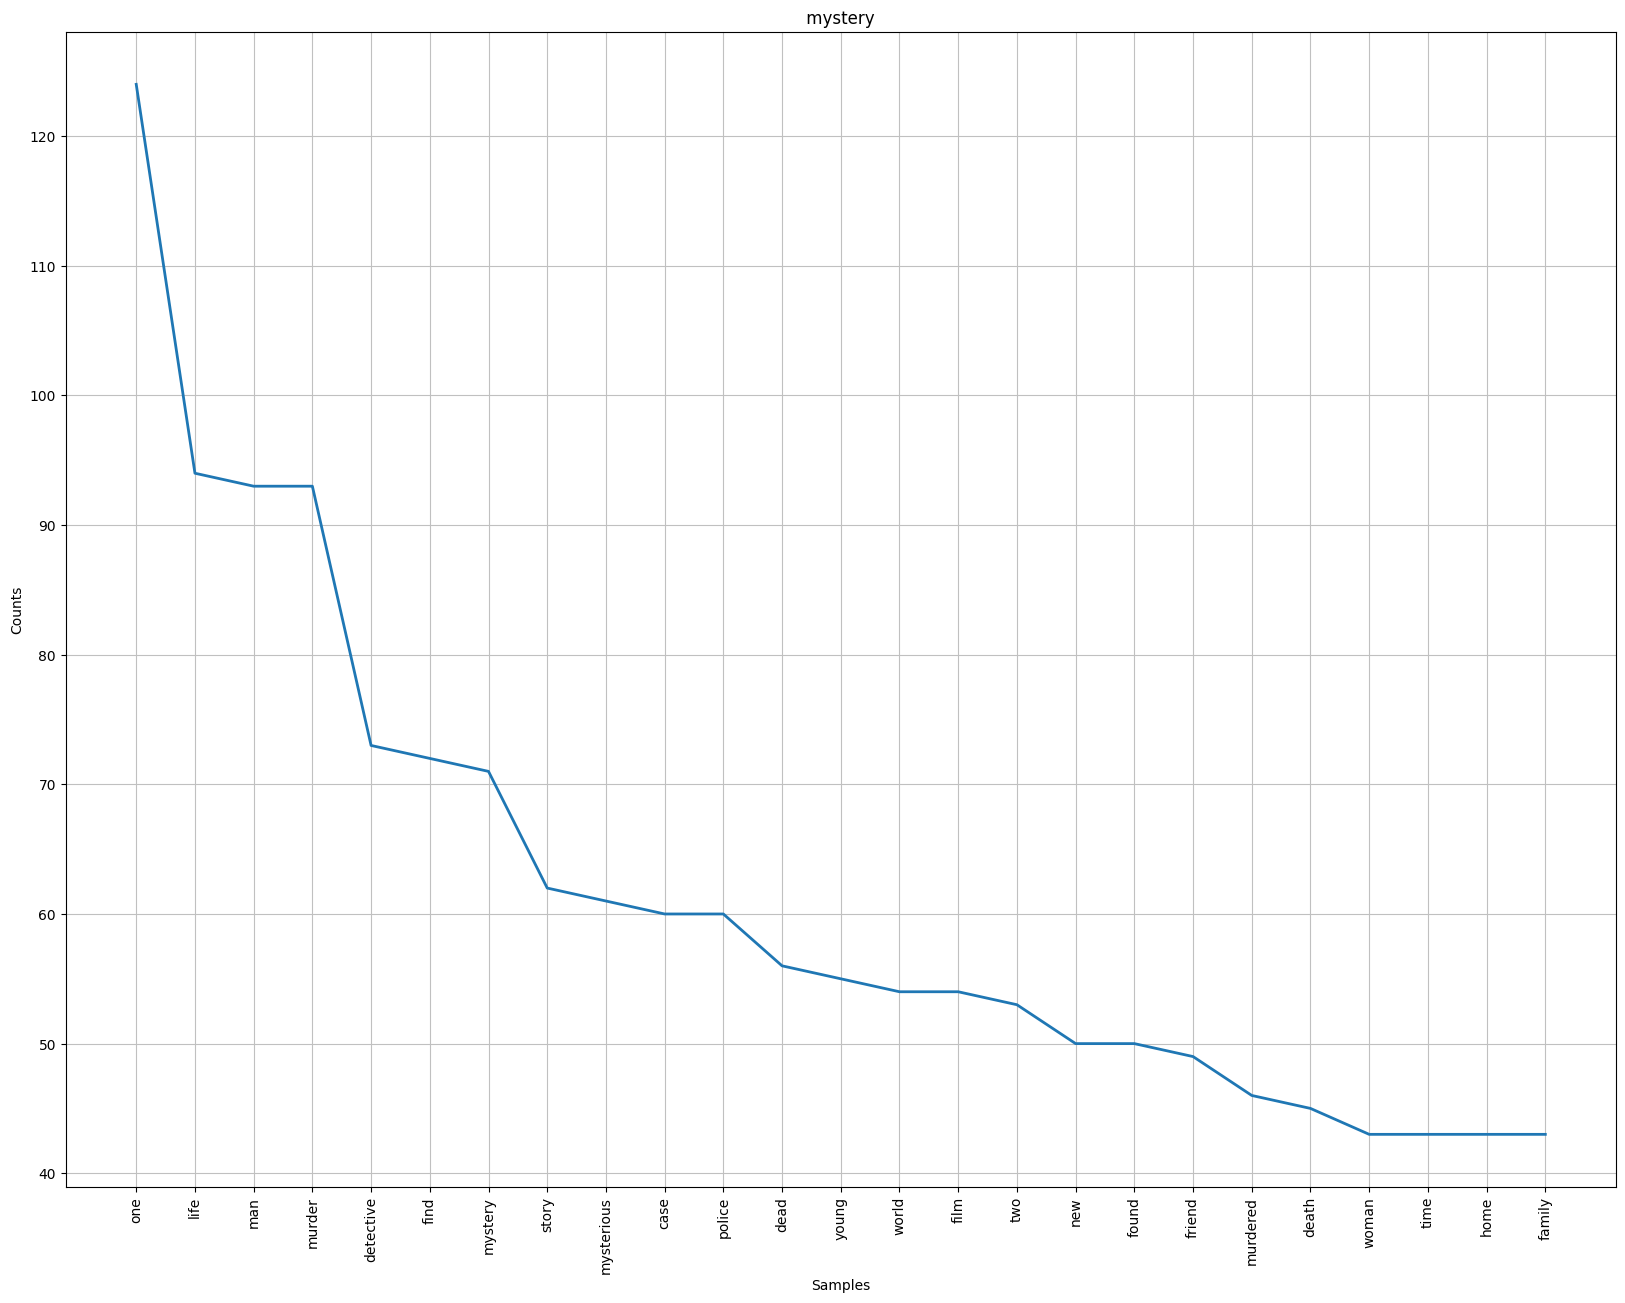

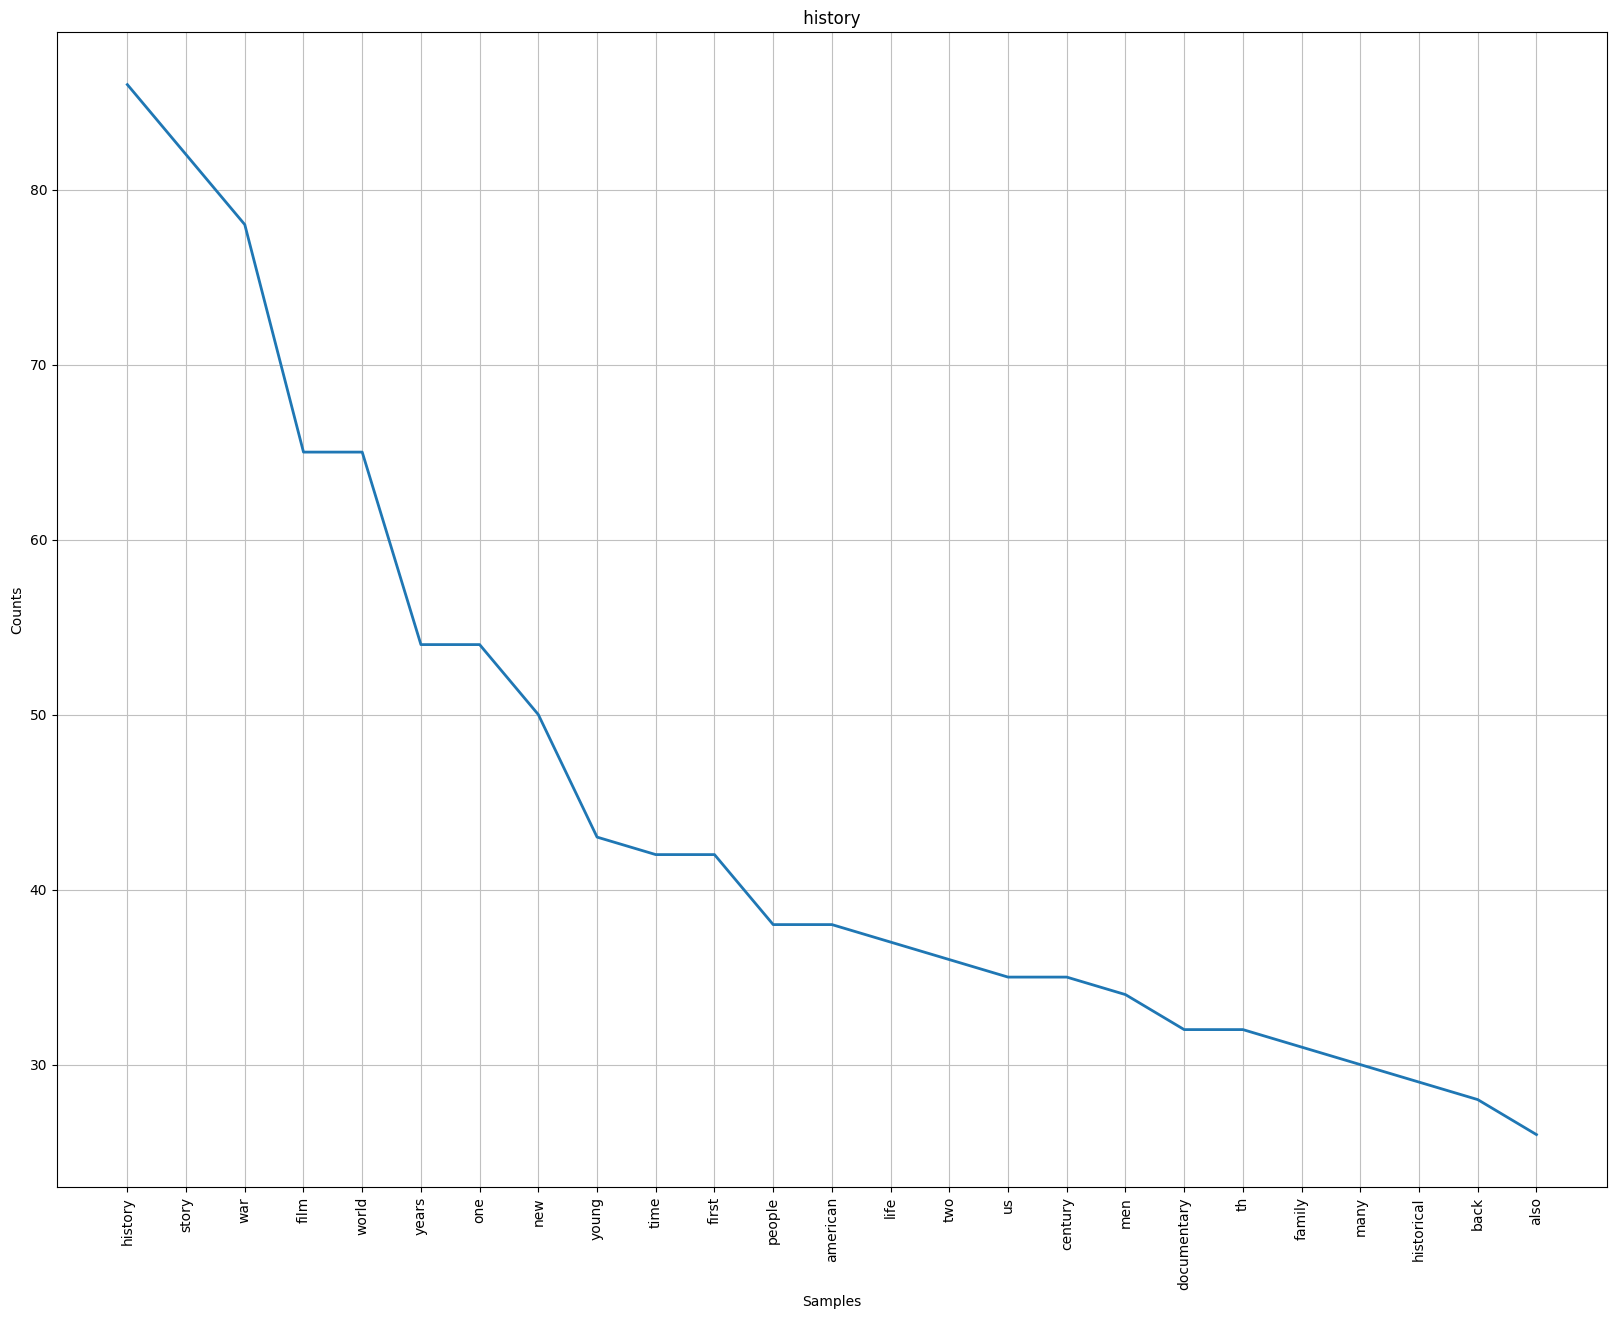

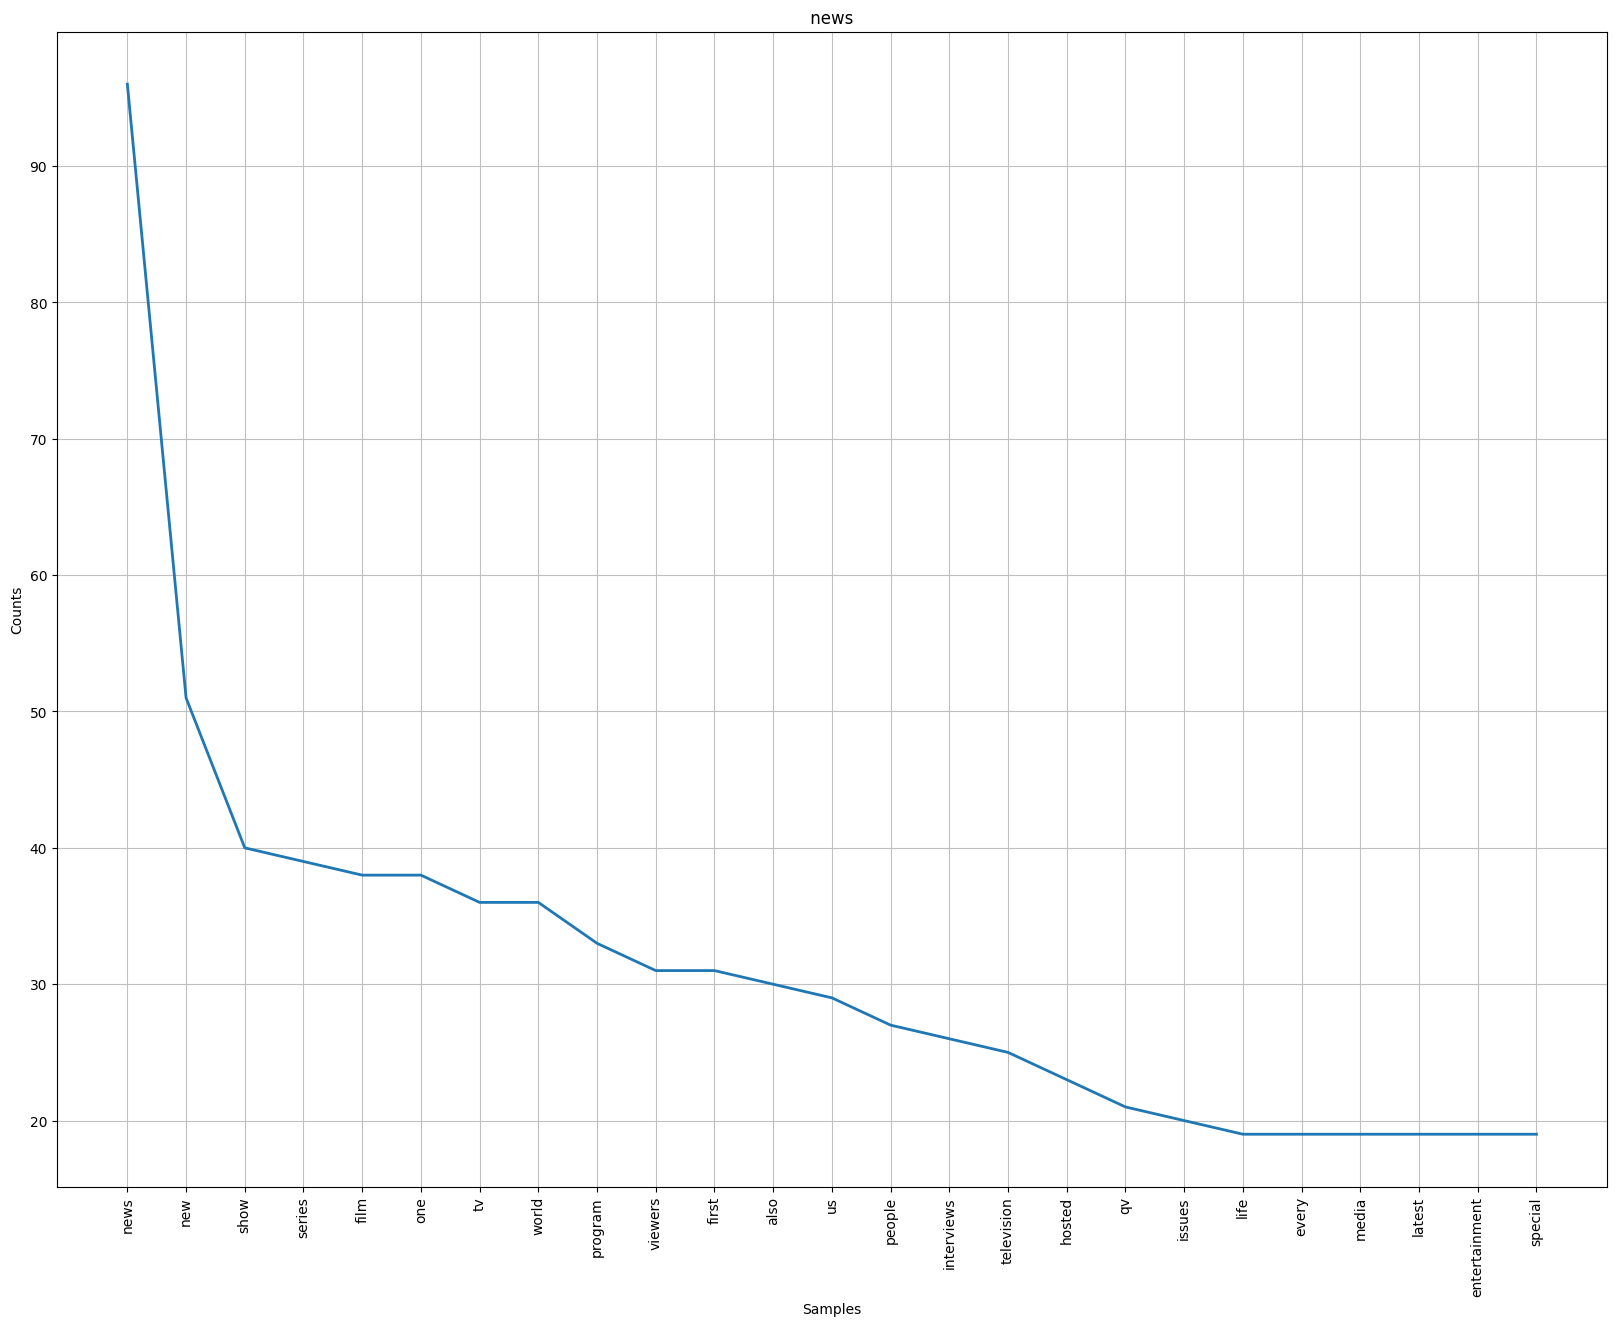

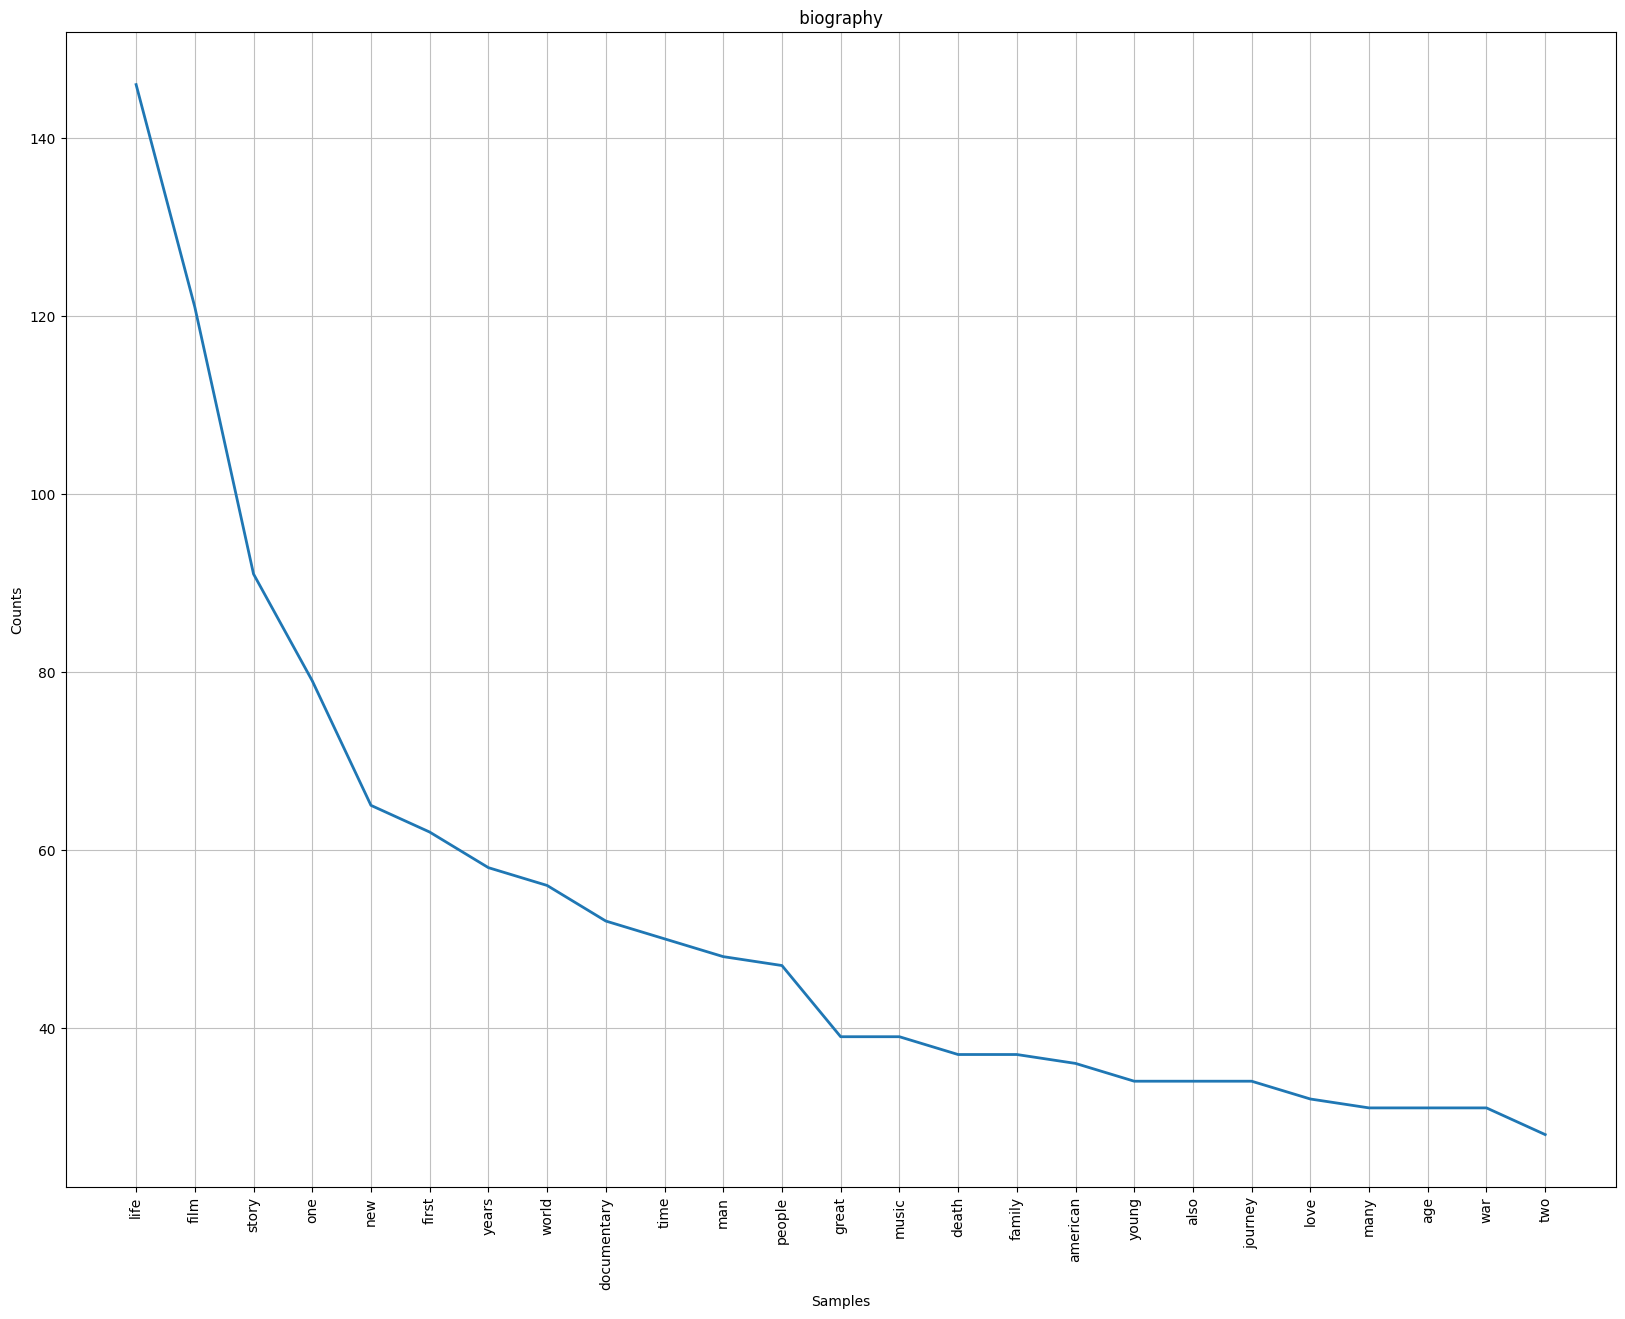

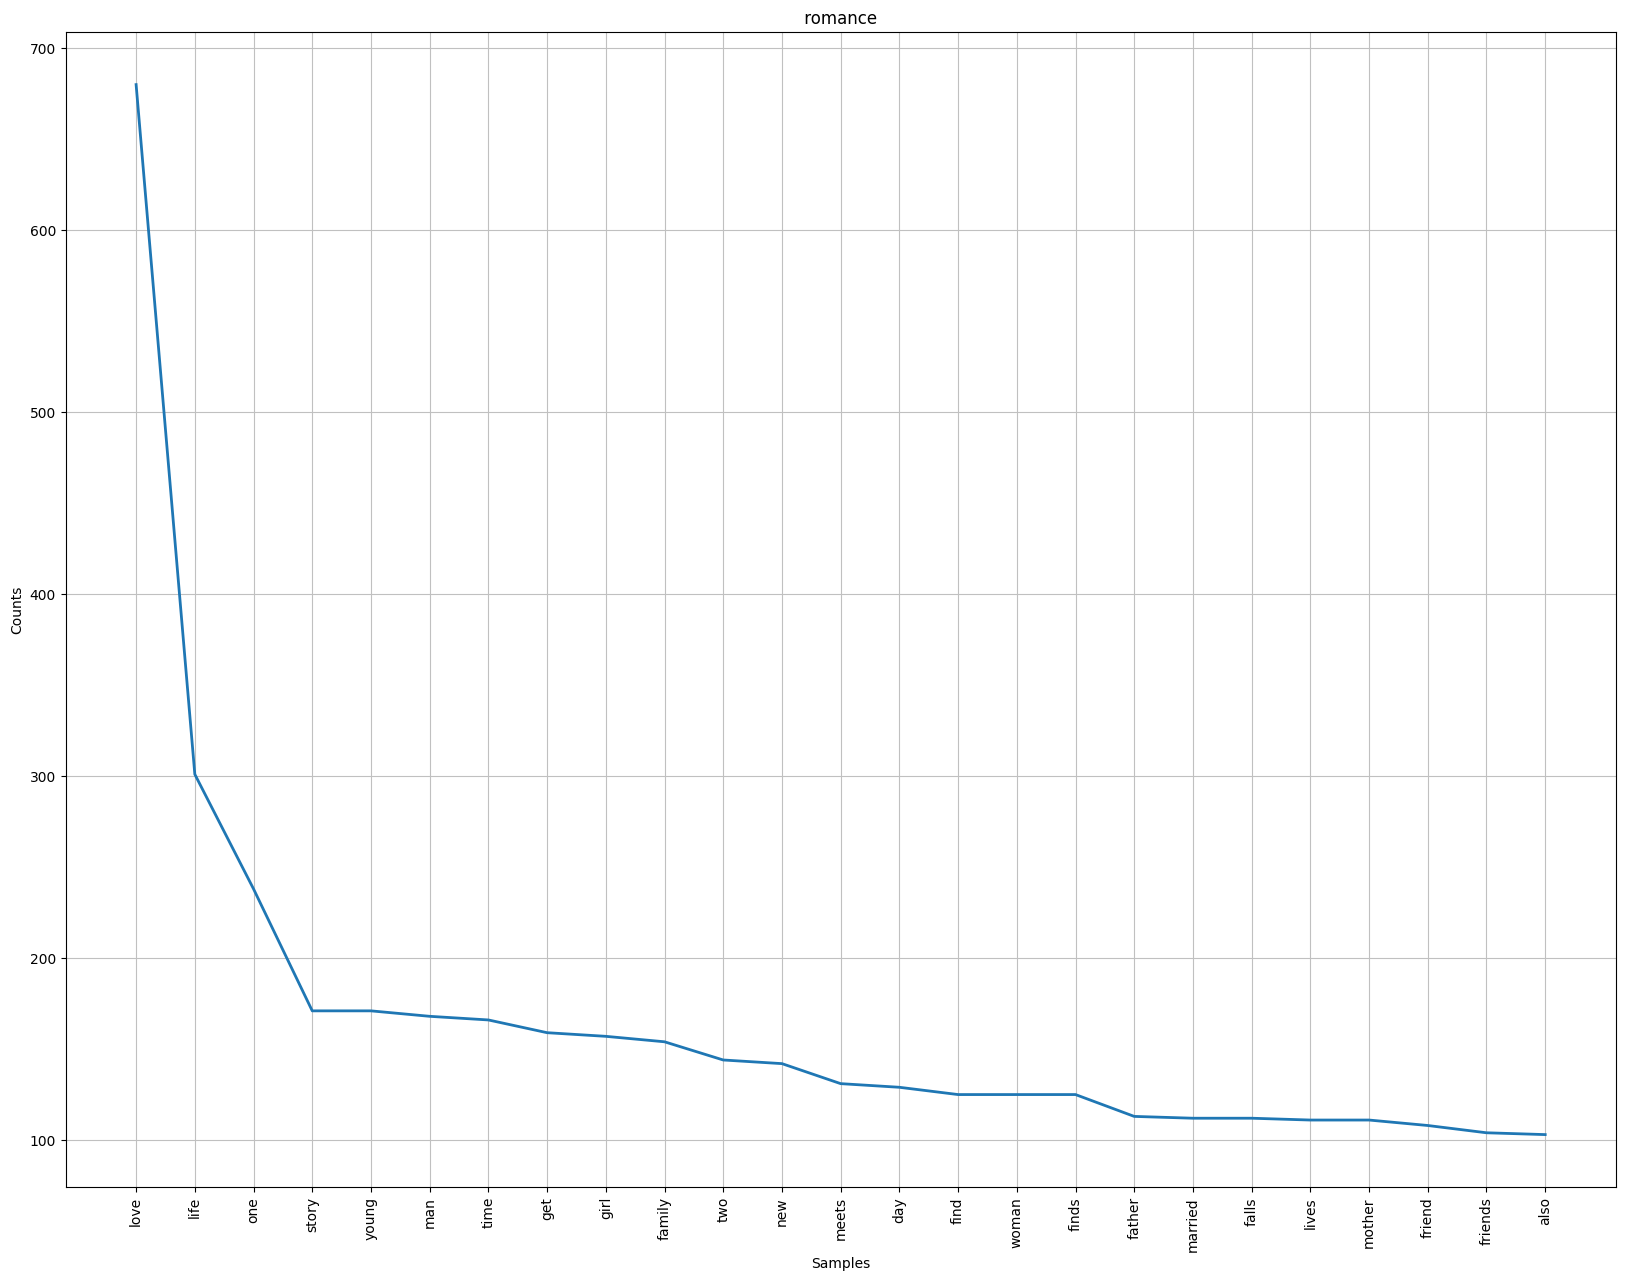

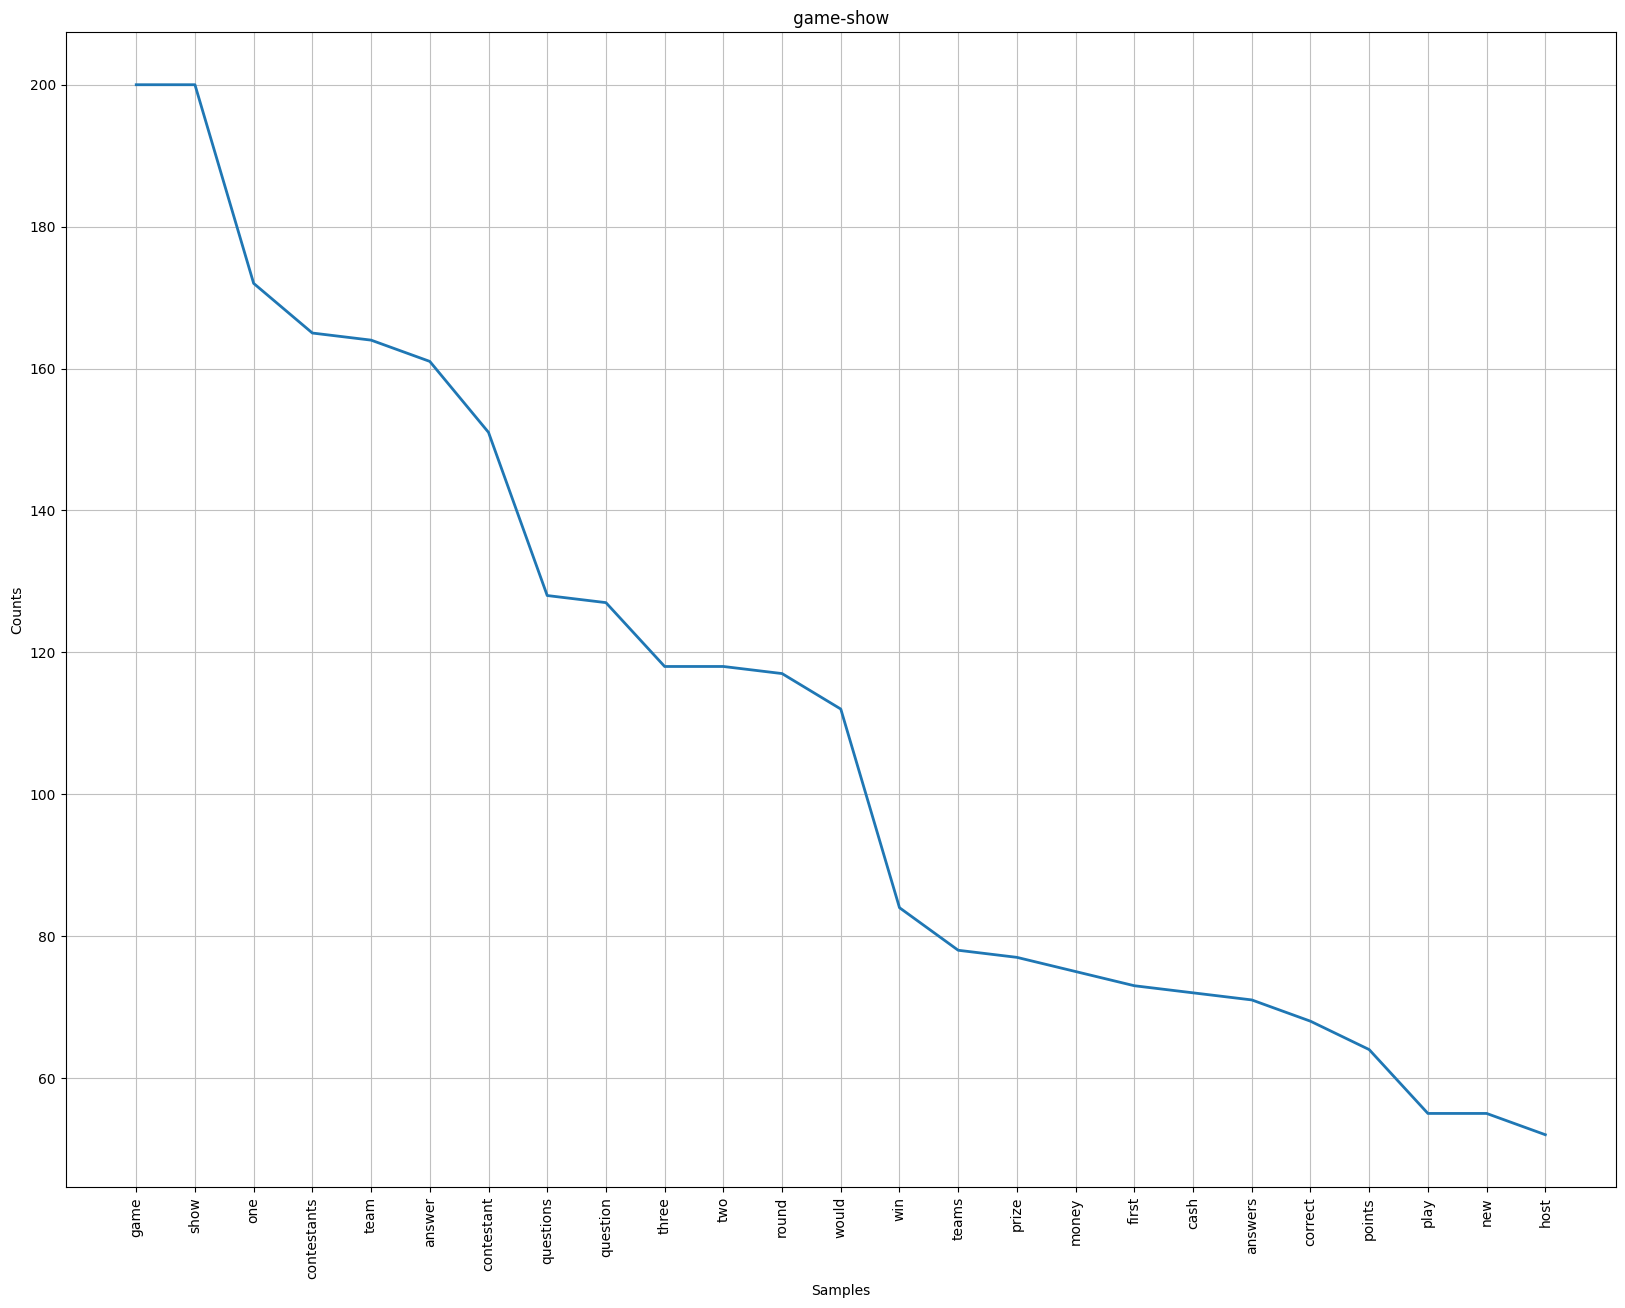

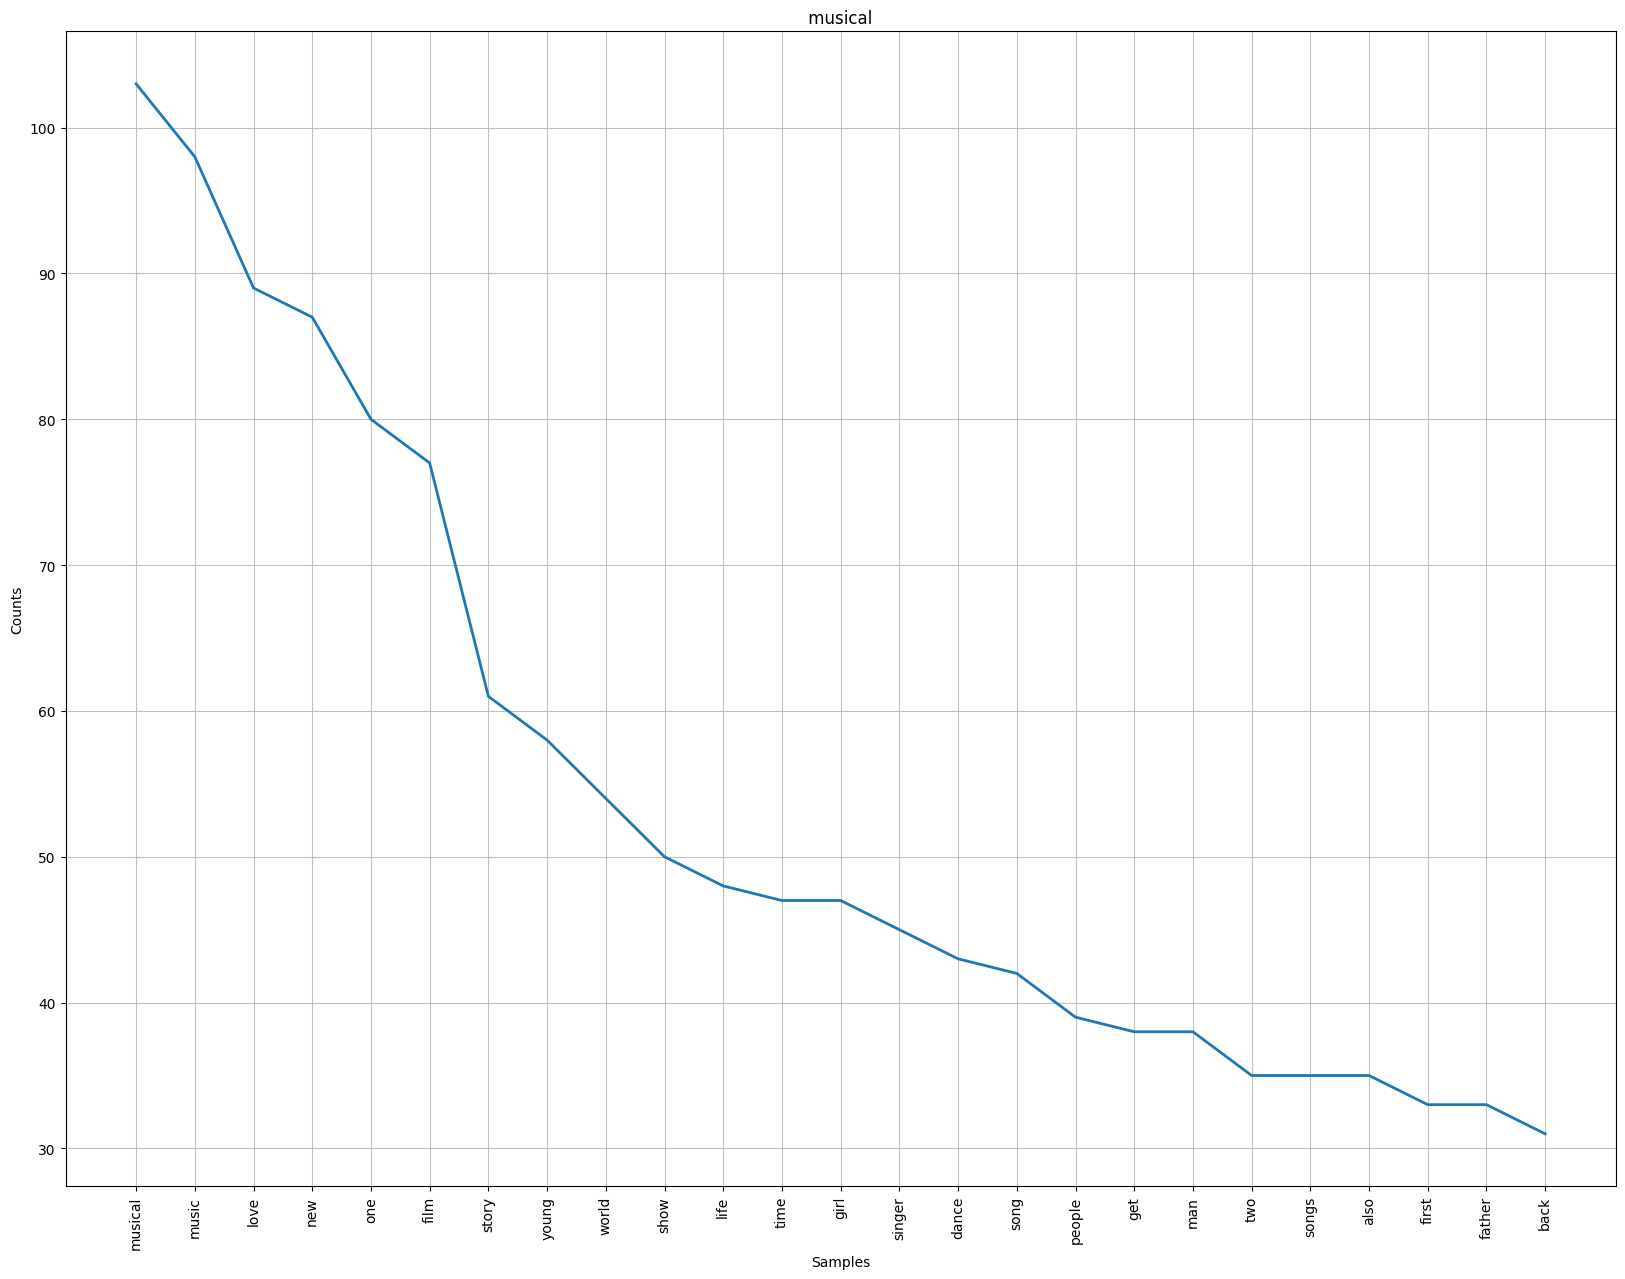

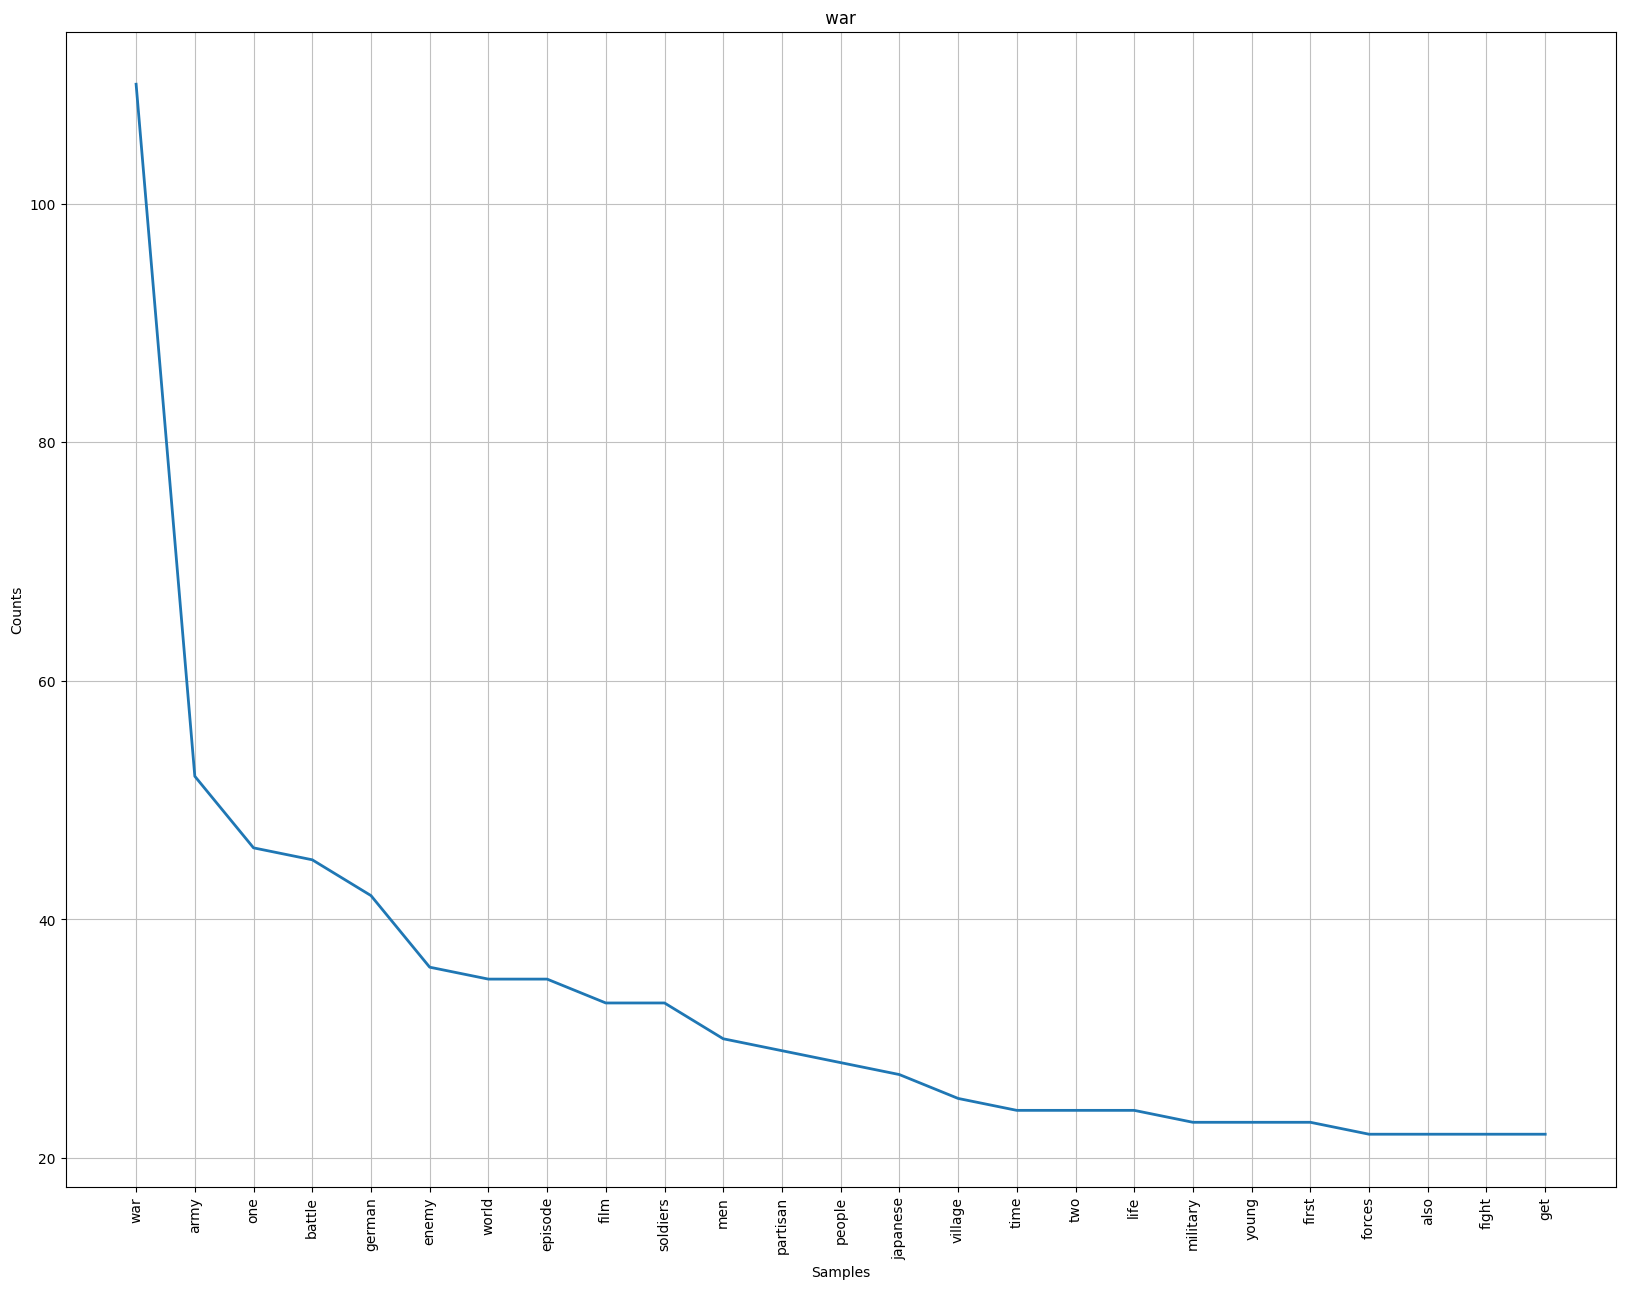

In [9]:
genres=movies.genre.unique().tolist()

for genre in genres:
    gen_data=movies.description.loc[movies.genre==genre]
    desc = gen_data.str.cat(sep=' ')
    #function to split text into word
    tokens = word_tokenize(desc)
    vocabulary = set(tokens)
    frequency_dist = nltk.FreqDist(tokens)
    plt.figure(figsize=(20,15))
    frequency_dist.plot(25,title=genre)

The plots show that some genres have very specific word tied to them i.e. that often appear in descriptions of movies of that genre but scarcely appear in descriptions of of movies of other genres. For example, "western" movies descriptions often have the word "gang", and "sport" movies often have the word "vs". On the other hand, there are "words" that are common for many genres, for example "life" is common in "drama", "thriller", "documentary" and "comedy" movies descriptions. Taken this into account, together with the fact that some movie genres descriptions greatly outnumber the rest we form the vocabulary with which we will encode the data out of the $n$ most common words of each genre. That's the objective of the next function. 

# Vocabulary generation and encoding

In [10]:
#This function creates a general vocabulary (set of words) out of the n most common words of each genre 
def voc_generator(n):
    vocabulary=set()
    genres=movies.genre.unique().tolist()
    for genre in genres:
        gen_data=movies.description.loc[movies.genre==genre]
        desc = gen_data.str.cat(sep=' ')
        tokens = word_tokenize(desc)
        genre_voc = set(tokens)
        frequency_dist = nltk.FreqDist(tokens)
        comm_genre_voc=set([tuple[0] for tuple in frequency_dist.most_common(n)])
        vocabulary=vocabulary.union(comm_genre_voc)
    return sorted(vocabulary)


# Model testing

To test the different models we split the training data into a test set with which we will calculate the classifier's generalization error, and a train set. To keep the original proportions of the data stratified sampling is used for the split.

In [11]:
X = movies.description
y = movies.genre

#Stratified sampling based on the category 'genre' for splitting data to preserve the original proportions in the
#train and test sets
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42) #Determines splitting characteristics
for train_index, test_index in split.split(movies, movies["genre"]): 
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]

We make the following function for quickly testing different models that receives the training and test sets (with inputs and targets in different arrays), a vectorizer and a model, and adjusts the model to the training set, tests it on the test set, displays each class performace, recall and F1 scores and the confusion matrix, and returns the fitted model.

In [12]:
def model_generator(X_train, y_train, X_test, y_test, vectorizer=CountVectorizer(vocabulary=voc_generator(100)), 
                    model=MultinomialNB()):
    
    model= Pipeline([('vectorizer', vectorizer),
                   ('classifier', model),
                   ])
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    vname=str(model.get_params()['vectorizer']).split('(')[0]
    cname=str(model.get_params()['classifier'])
    print('vectorizer: '+str(vname))
    print('classifier: '+str(cname))
    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))
    cm=confusion_matrix(y_test,y_pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    fig, ax = plt.subplots(figsize=(15, 15))
    disp.plot(include_values=False,xticks_rotation='vertical',ax=ax)
    plt.title(vname+' '+cname)
    plt.show()
    
    return model


Now multinomial naive bayes, one vs. all logistic regression and multinomial logistic regression classifiers are tested for a genre-vocabulary size of 500, 1000, 1500 and 2000. 

voc. size: 500
vectorizer: CountVectorizer
classifier: MultinomialNB()
accuracy 0.5305727197270128
               precision    recall  f1-score   support

      action        0.35      0.43      0.39       263
       adult        0.54      0.63      0.58       118
   adventure        0.27      0.21      0.23       155
   animation        0.27      0.23      0.25       100
   biography        0.00      0.00      0.00        53
      comedy        0.54      0.46      0.50      1490
       crime        0.19      0.25      0.22       101
 documentary        0.71      0.70      0.70      2619
       drama        0.59      0.58      0.59      2723
      family        0.27      0.18      0.22       157
     fantasy        0.27      0.26      0.26        65
   game-show        0.68      0.67      0.68        39
     history        0.14      0.18      0.16        49
      horror        0.58      0.65      0.61       441
       music        0.34      0.81      0.48       146
     musical        

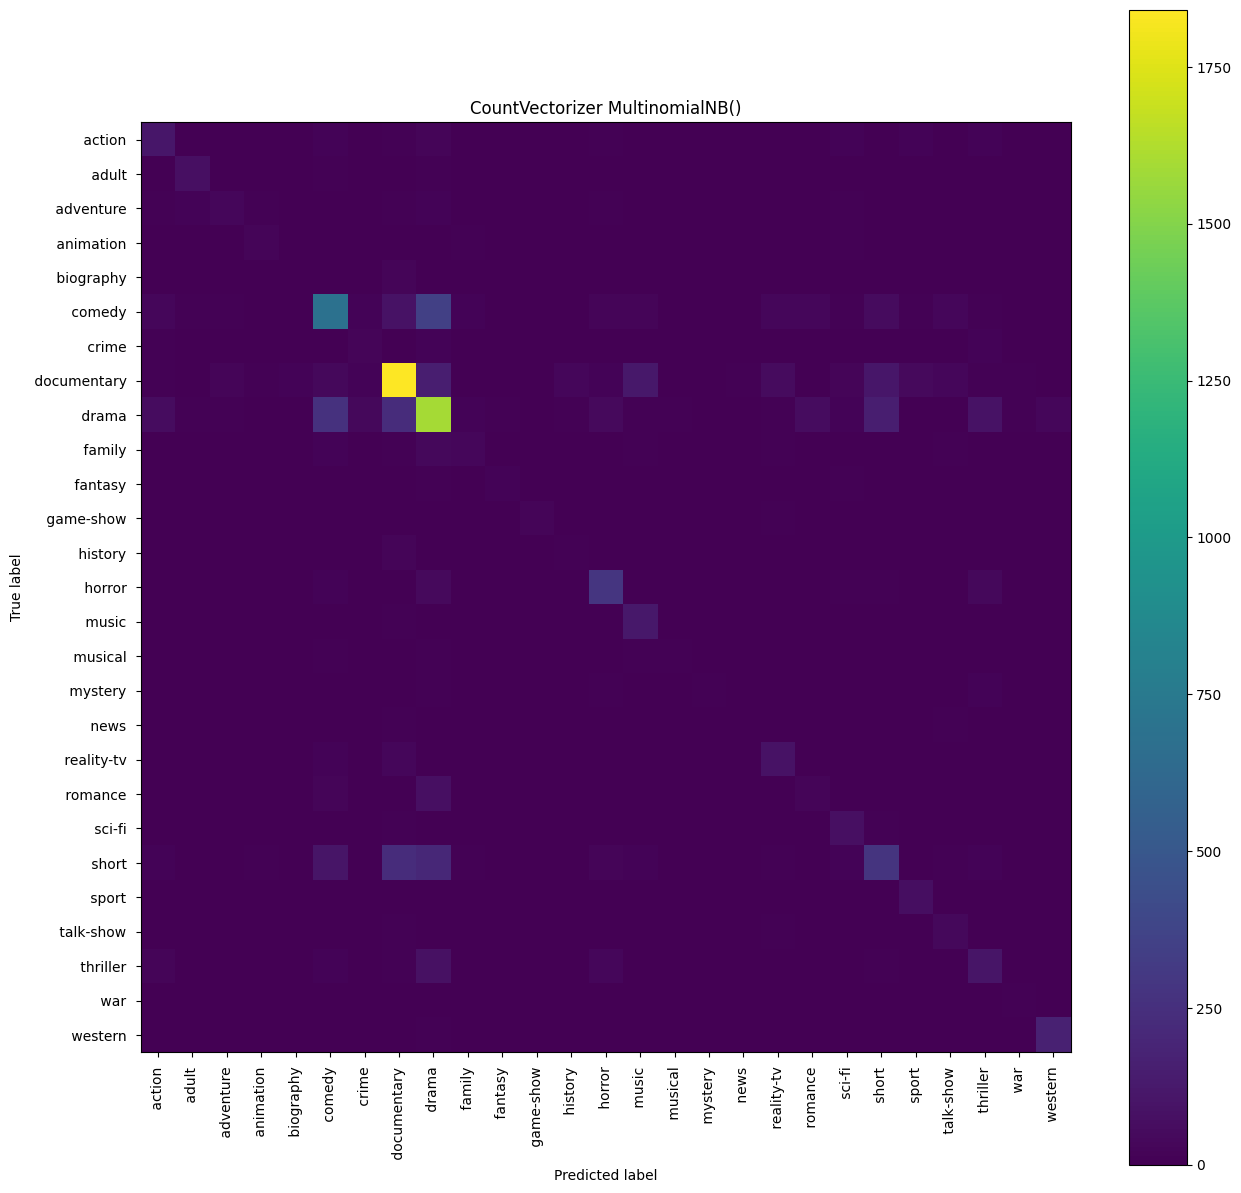

voc. size: 500
vectorizer: CountVectorizer
classifier: LogisticRegression(max_iter=1000, multi_class='ovr')
accuracy 0.5523379138614775
               precision    recall  f1-score   support

      action        0.42      0.35      0.38       263
       adult        0.62      0.47      0.53       118
   adventure        0.27      0.15      0.20       155
   animation        0.24      0.16      0.19       100
   biography        0.00      0.00      0.00        53
      comedy        0.51      0.52      0.52      1490
       crime        0.21      0.07      0.10       101
 documentary        0.68      0.79      0.73      2619
       drama        0.54      0.69      0.61      2723
      family        0.32      0.18      0.23       157
     fantasy        0.09      0.05      0.06        65
   game-show        0.80      0.51      0.62        39
     history        0.21      0.06      0.10        49
      horror        0.59      0.55      0.57       441
       music        0.61      0.49    

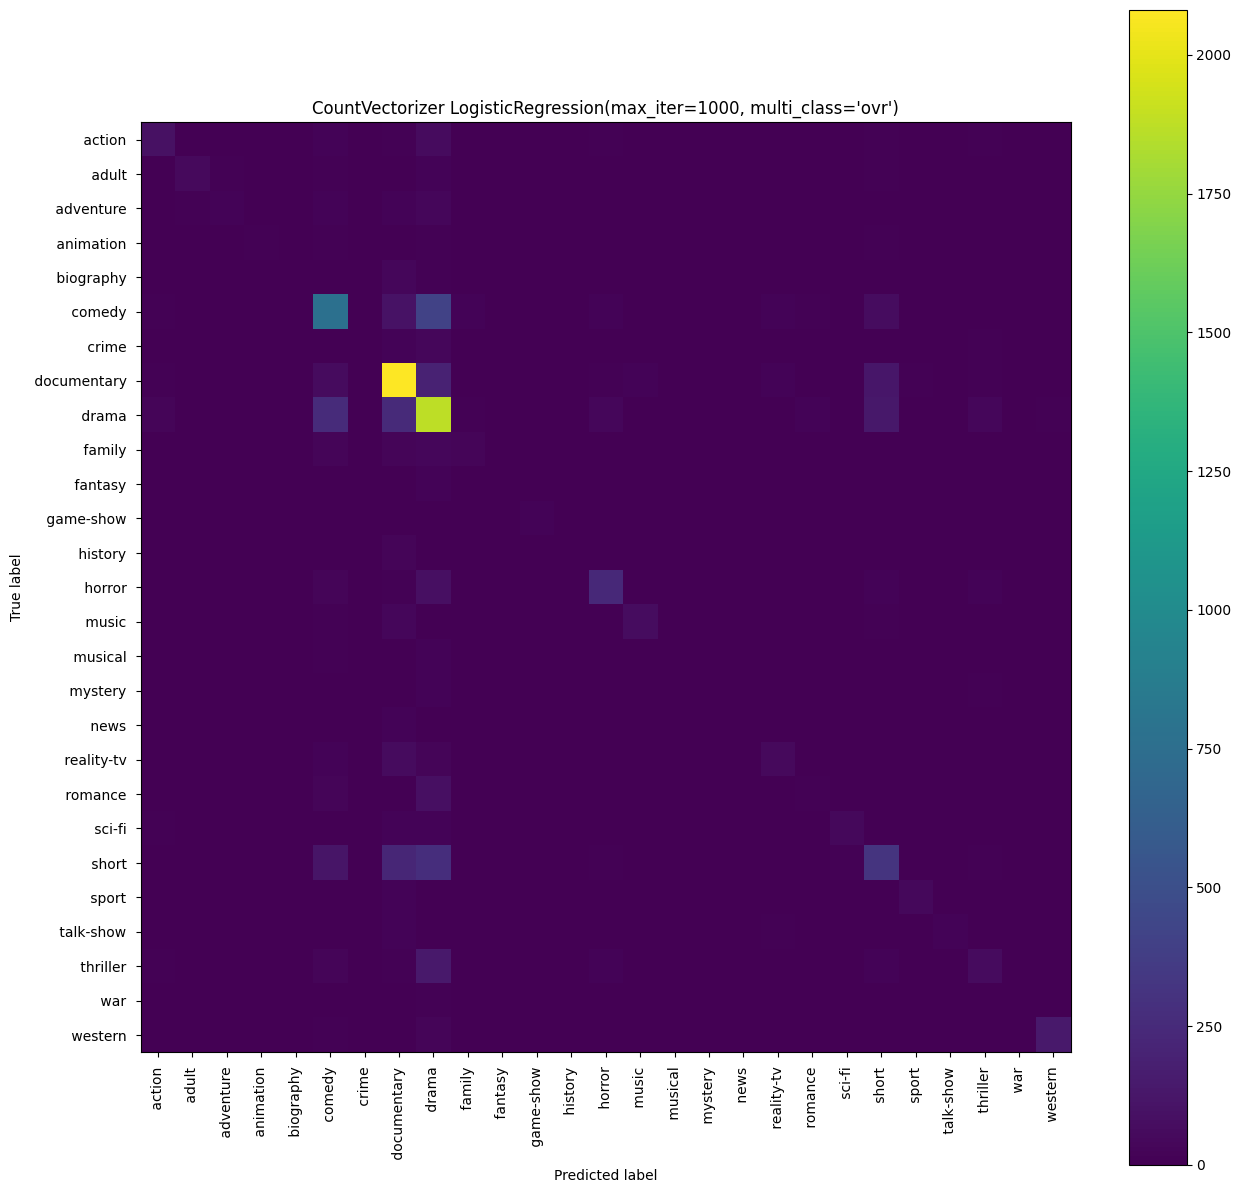

voc. size: 500
vectorizer: CountVectorizer
classifier: LogisticRegression(max_iter=1000, multi_class='multinomial')
accuracy 0.5379507516370008
               precision    recall  f1-score   support

      action        0.40      0.38      0.39       263
       adult        0.60      0.49      0.54       118
   adventure        0.22      0.17      0.19       155
   animation        0.23      0.20      0.21       100
   biography        0.07      0.02      0.03        53
      comedy        0.50      0.52      0.51      1490
       crime        0.16      0.09      0.11       101
 documentary        0.69      0.76      0.72      2619
       drama        0.55      0.64      0.59      2723
      family        0.24      0.20      0.22       157
     fantasy        0.13      0.08      0.10        65
   game-show        0.75      0.54      0.63        39
     history        0.14      0.06      0.08        49
      horror        0.58      0.56      0.57       441
       music        0.57      

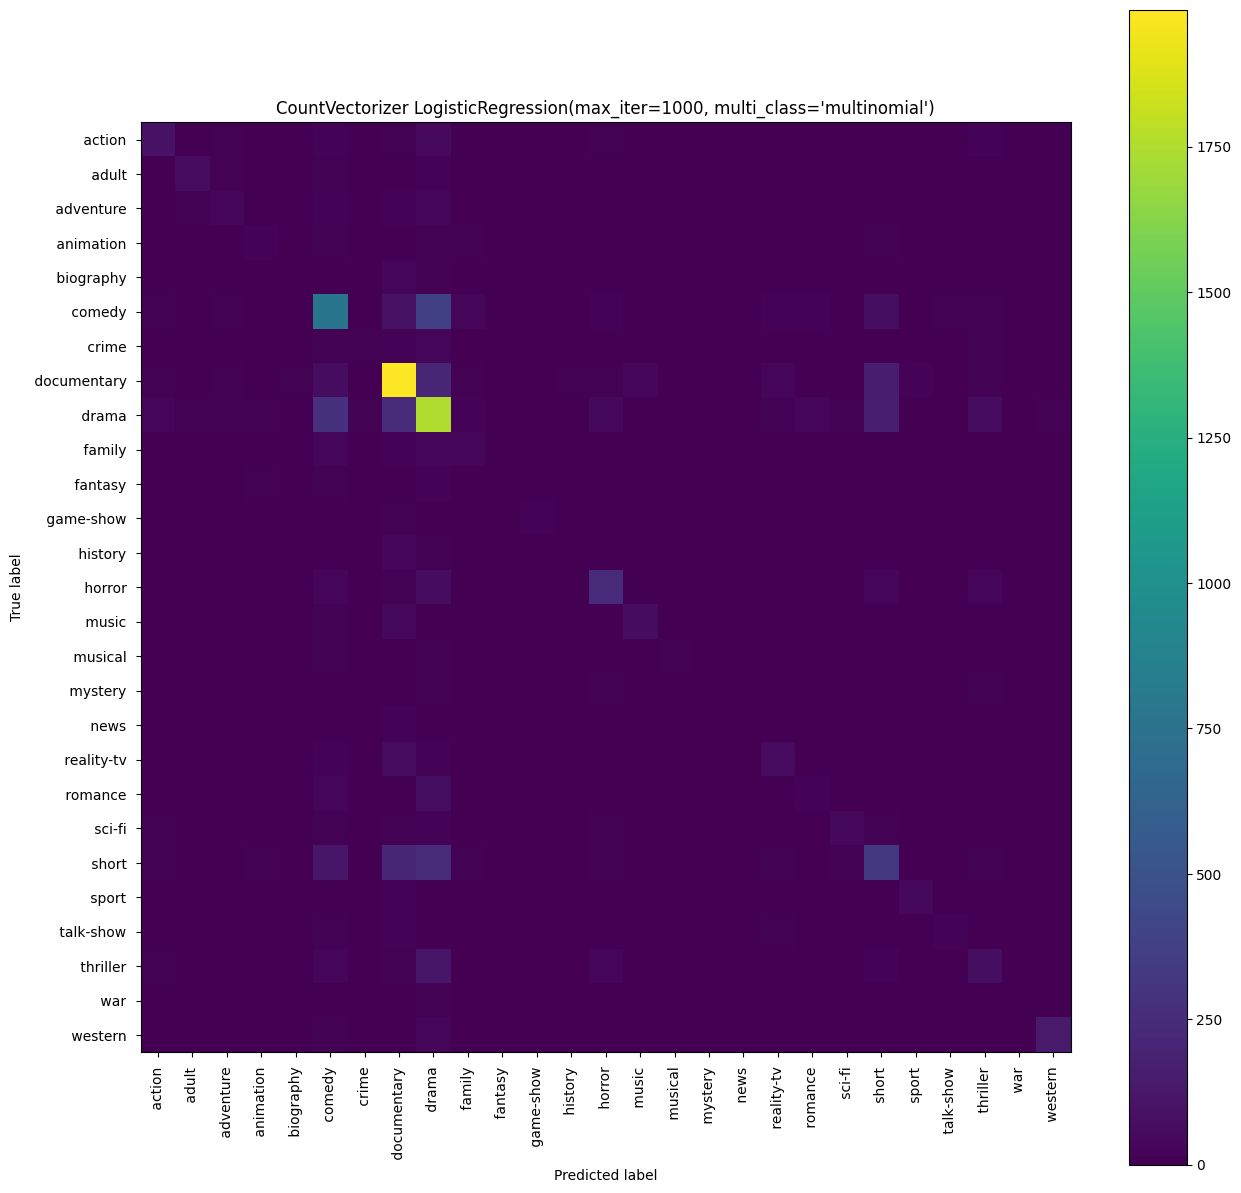

voc. size: 1000
vectorizer: CountVectorizer
classifier: MultinomialNB()
accuracy 0.5555658028220972
               precision    recall  f1-score   support

      action        0.37      0.49      0.42       263
       adult        0.59      0.60      0.59       118
   adventure        0.31      0.23      0.27       155
   animation        0.33      0.22      0.26       100
   biography        0.05      0.02      0.03        53
      comedy        0.55      0.50      0.53      1490
       crime        0.18      0.16      0.17       101
 documentary        0.72      0.74      0.73      2619
       drama        0.61      0.62      0.61      2723
      family        0.32      0.18      0.23       157
     fantasy        0.27      0.23      0.25        65
   game-show        0.76      0.64      0.69        39
     history        0.24      0.14      0.18        49
      horror        0.58      0.68      0.63       441
       music        0.37      0.82      0.51       146
     musical       

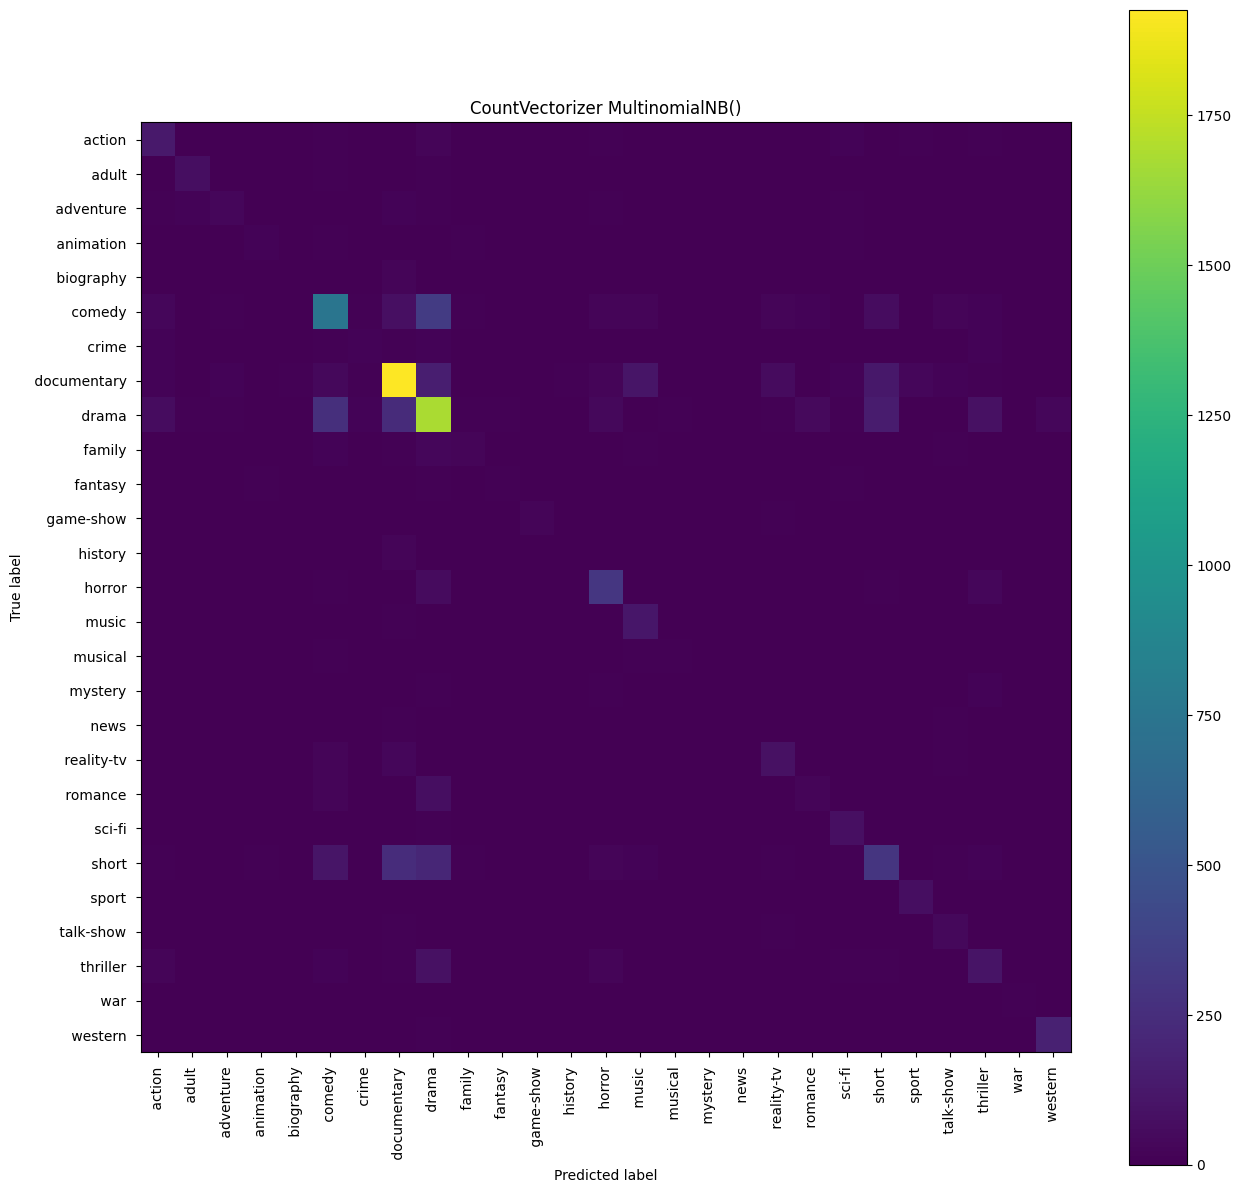

voc. size: 1000
vectorizer: CountVectorizer
classifier: LogisticRegression(max_iter=1000, multi_class='ovr')
accuracy 0.5538135202434751
               precision    recall  f1-score   support

      action        0.41      0.36      0.38       263
       adult        0.68      0.43      0.53       118
   adventure        0.30      0.19      0.23       155
   animation        0.31      0.18      0.23       100
   biography        0.00      0.00      0.00        53
      comedy        0.52      0.55      0.53      1490
       crime        0.28      0.08      0.12       101
 documentary        0.69      0.77      0.73      2619
       drama        0.55      0.68      0.61      2723
      family        0.34      0.19      0.25       157
     fantasy        0.15      0.06      0.09        65
   game-show        0.95      0.51      0.67        39
     history        0.27      0.06      0.10        49
      horror        0.61      0.56      0.59       441
       music        0.61      0.45   

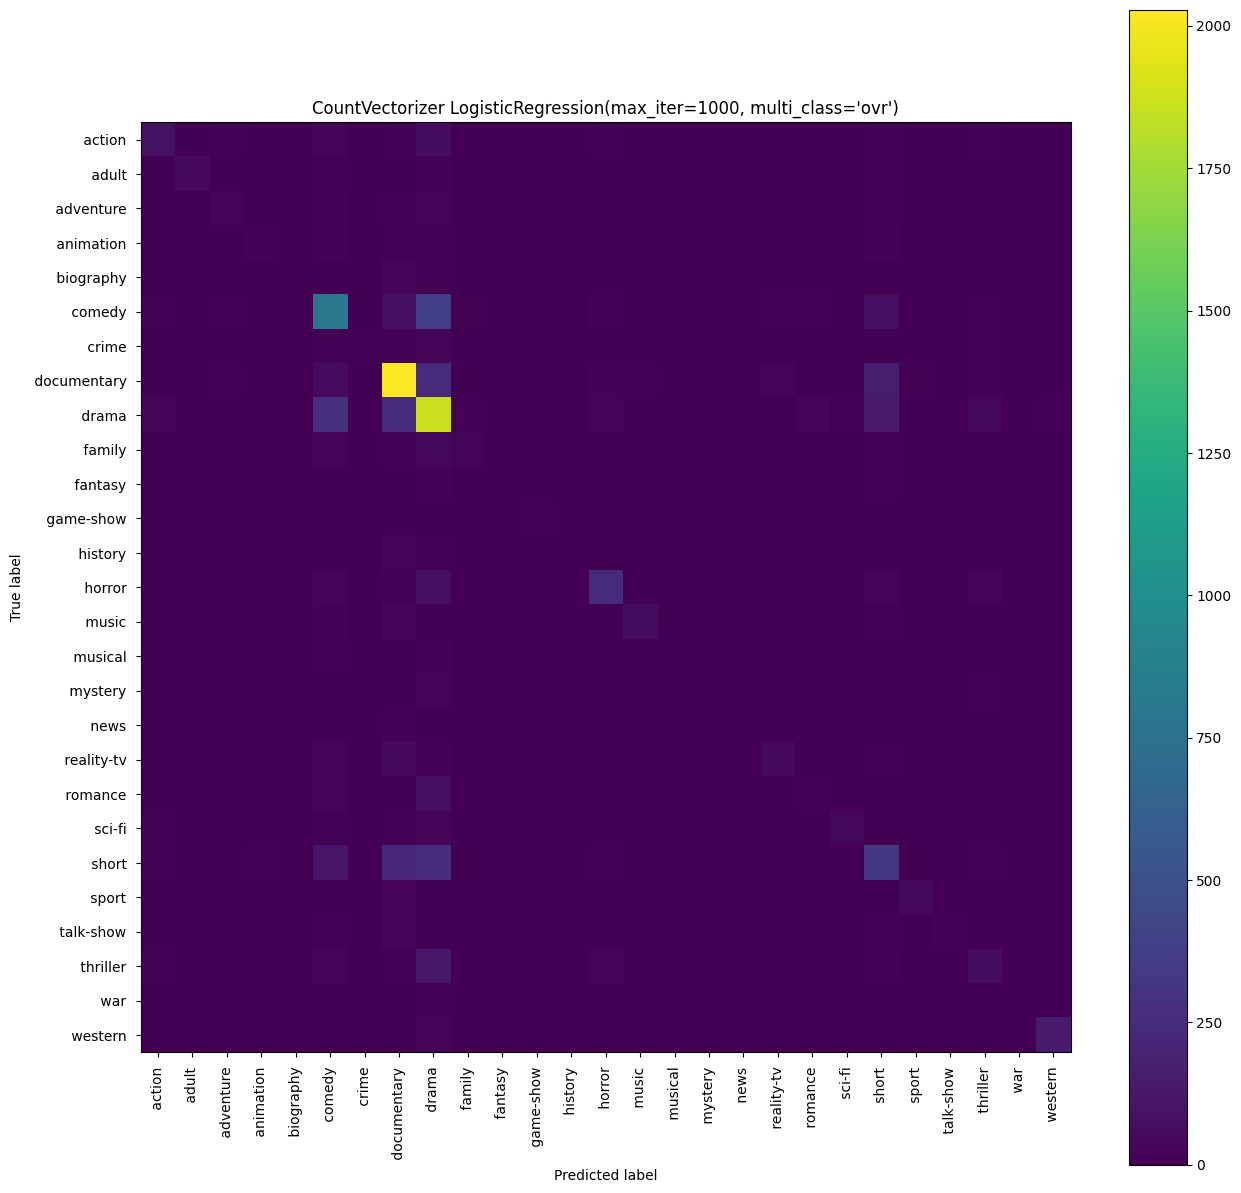

voc. size: 1000
vectorizer: CountVectorizer
classifier: LogisticRegression(max_iter=1000, multi_class='multinomial')
accuracy 0.5438531771649913
               precision    recall  f1-score   support

      action        0.40      0.39      0.40       263
       adult        0.66      0.48      0.56       118
   adventure        0.24      0.19      0.21       155
   animation        0.25      0.17      0.20       100
   biography        0.11      0.02      0.03        53
      comedy        0.51      0.55      0.53      1490
       crime        0.17      0.07      0.10       101
 documentary        0.69      0.76      0.72      2619
       drama        0.55      0.64      0.59      2723
      family        0.30      0.20      0.24       157
     fantasy        0.19      0.08      0.11        65
   game-show        0.87      0.51      0.65        39
     history        0.17      0.06      0.09        49
      horror        0.59      0.56      0.58       441
       music        0.59     

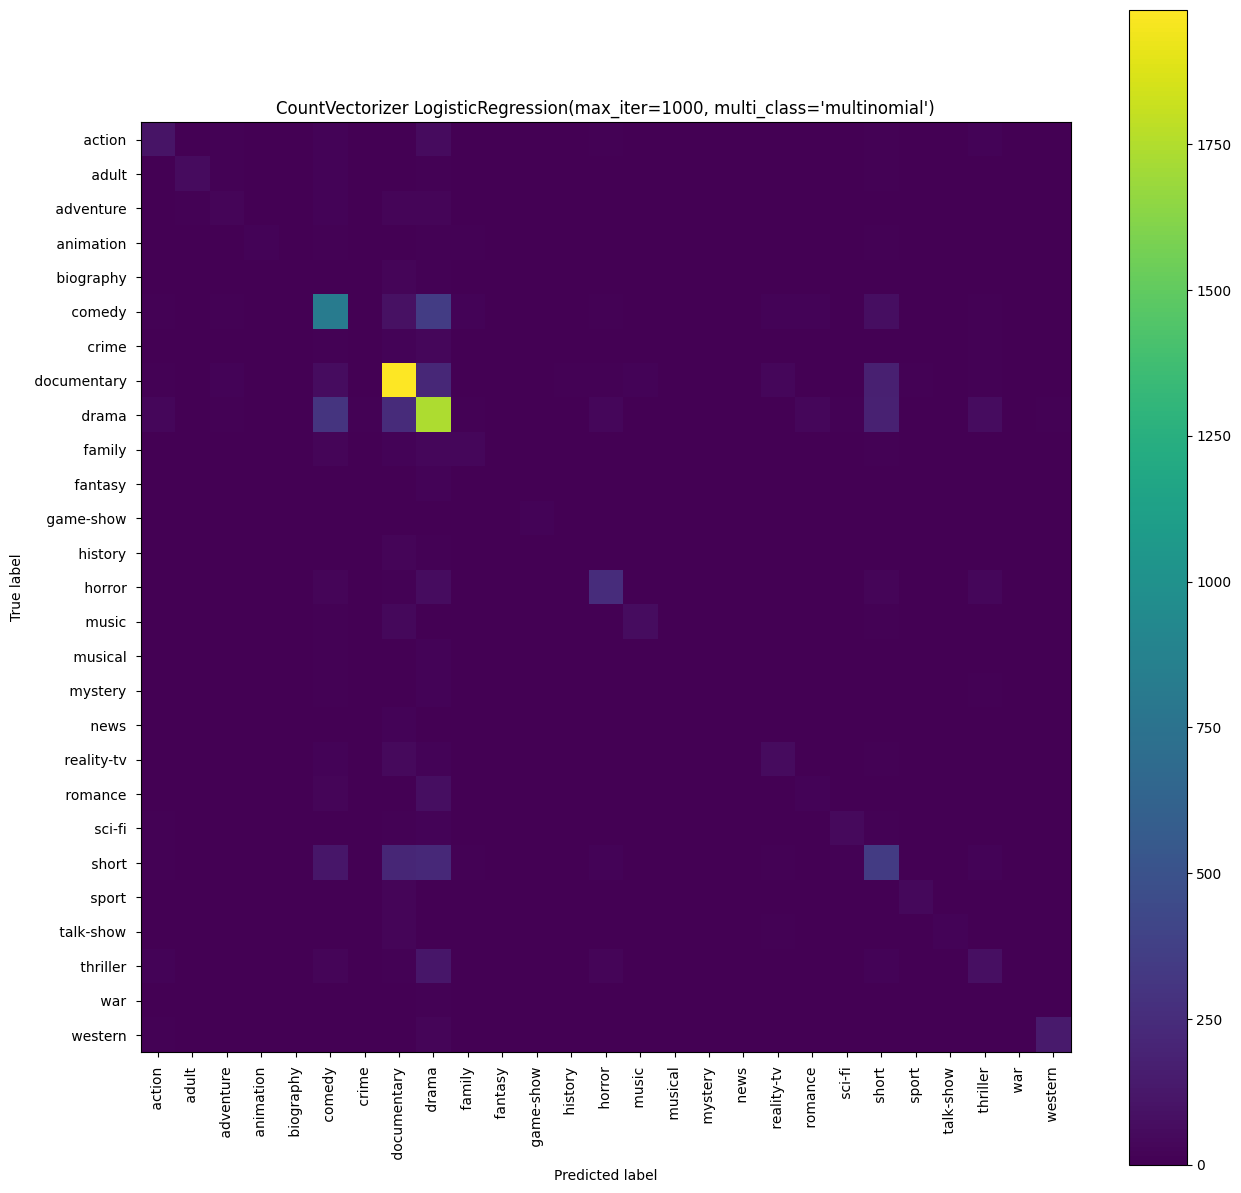

voc. size: 1500
vectorizer: CountVectorizer
classifier: MultinomialNB()
accuracy 0.5659872728949553
               precision    recall  f1-score   support

      action        0.39      0.47      0.42       263
       adult        0.61      0.59      0.60       118
   adventure        0.29      0.22      0.25       155
   animation        0.42      0.20      0.27       100
   biography        0.18      0.04      0.06        53
      comedy        0.56      0.54      0.55      1490
       crime        0.16      0.08      0.11       101
 documentary        0.71      0.76      0.73      2619
       drama        0.61      0.64      0.62      2723
      family        0.32      0.18      0.23       157
     fantasy        0.29      0.17      0.21        65
   game-show        0.77      0.59      0.67        39
     history        0.37      0.14      0.21        49
      horror        0.57      0.69      0.62       441
       music        0.38      0.82      0.52       146
     musical       

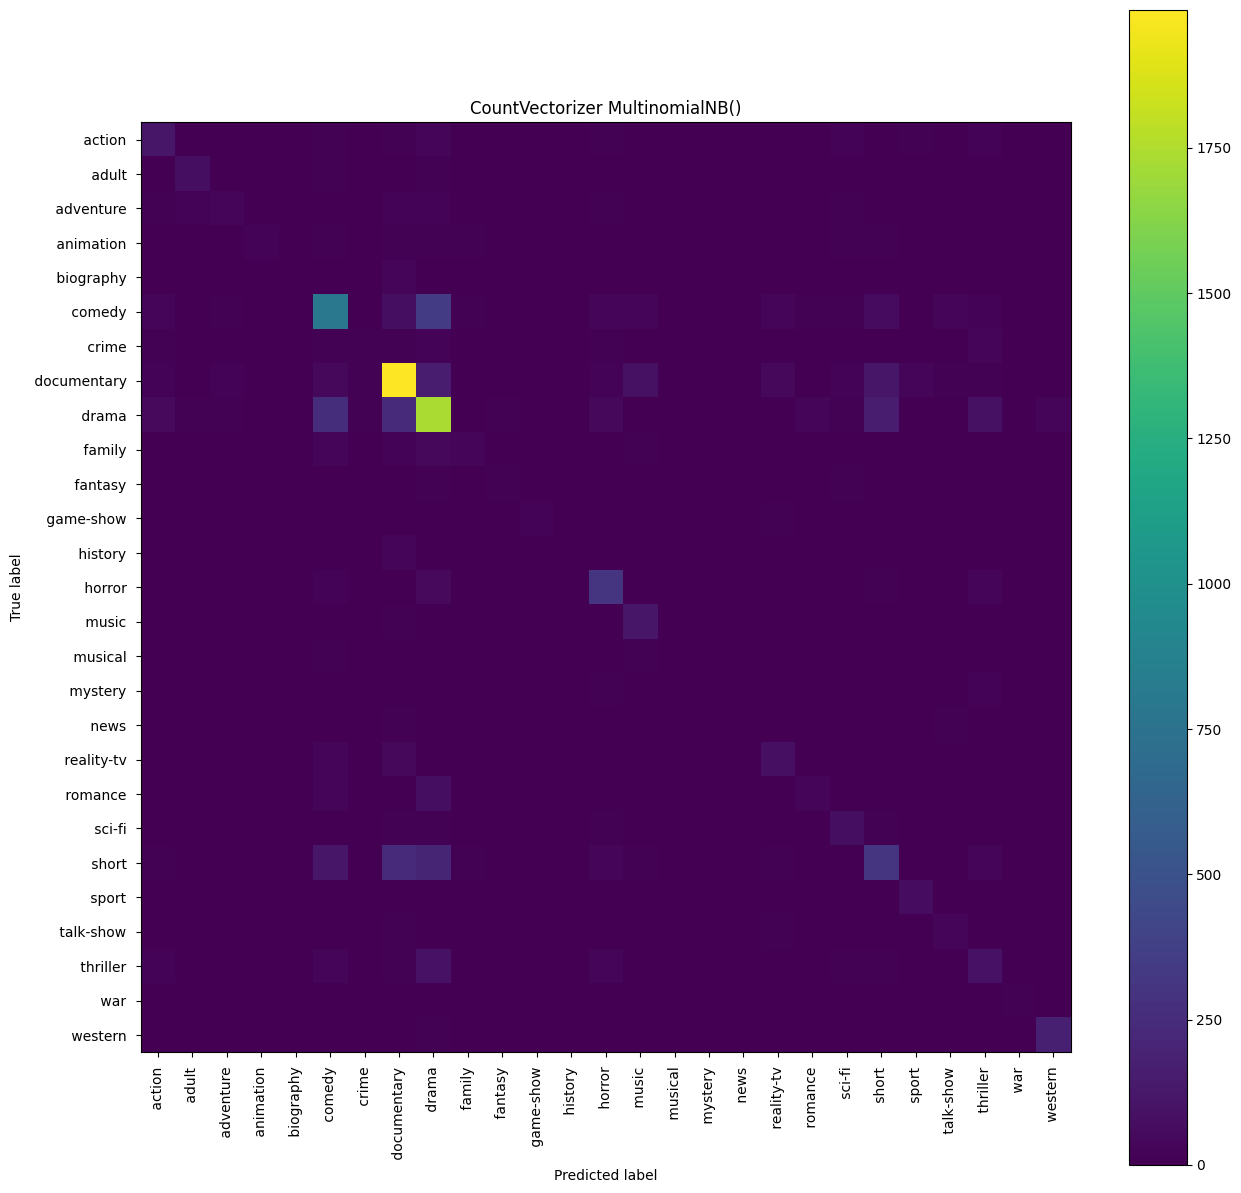

voc. size: 1500
vectorizer: CountVectorizer
classifier: LogisticRegression(max_iter=1000, multi_class='ovr')
accuracy 0.5537212948446002
               precision    recall  f1-score   support

      action        0.44      0.38      0.41       263
       adult        0.72      0.42      0.53       118
   adventure        0.33      0.19      0.24       155
   animation        0.33      0.19      0.24       100
   biography        0.00      0.00      0.00        53
      comedy        0.52      0.57      0.54      1490
       crime        0.27      0.10      0.14       101
 documentary        0.69      0.78      0.73      2619
       drama        0.55      0.67      0.60      2723
      family        0.37      0.18      0.25       157
     fantasy        0.10      0.03      0.05        65
   game-show        0.90      0.49      0.63        39
     history        0.38      0.06      0.11        49
      horror        0.61      0.56      0.58       441
       music        0.61      0.45   

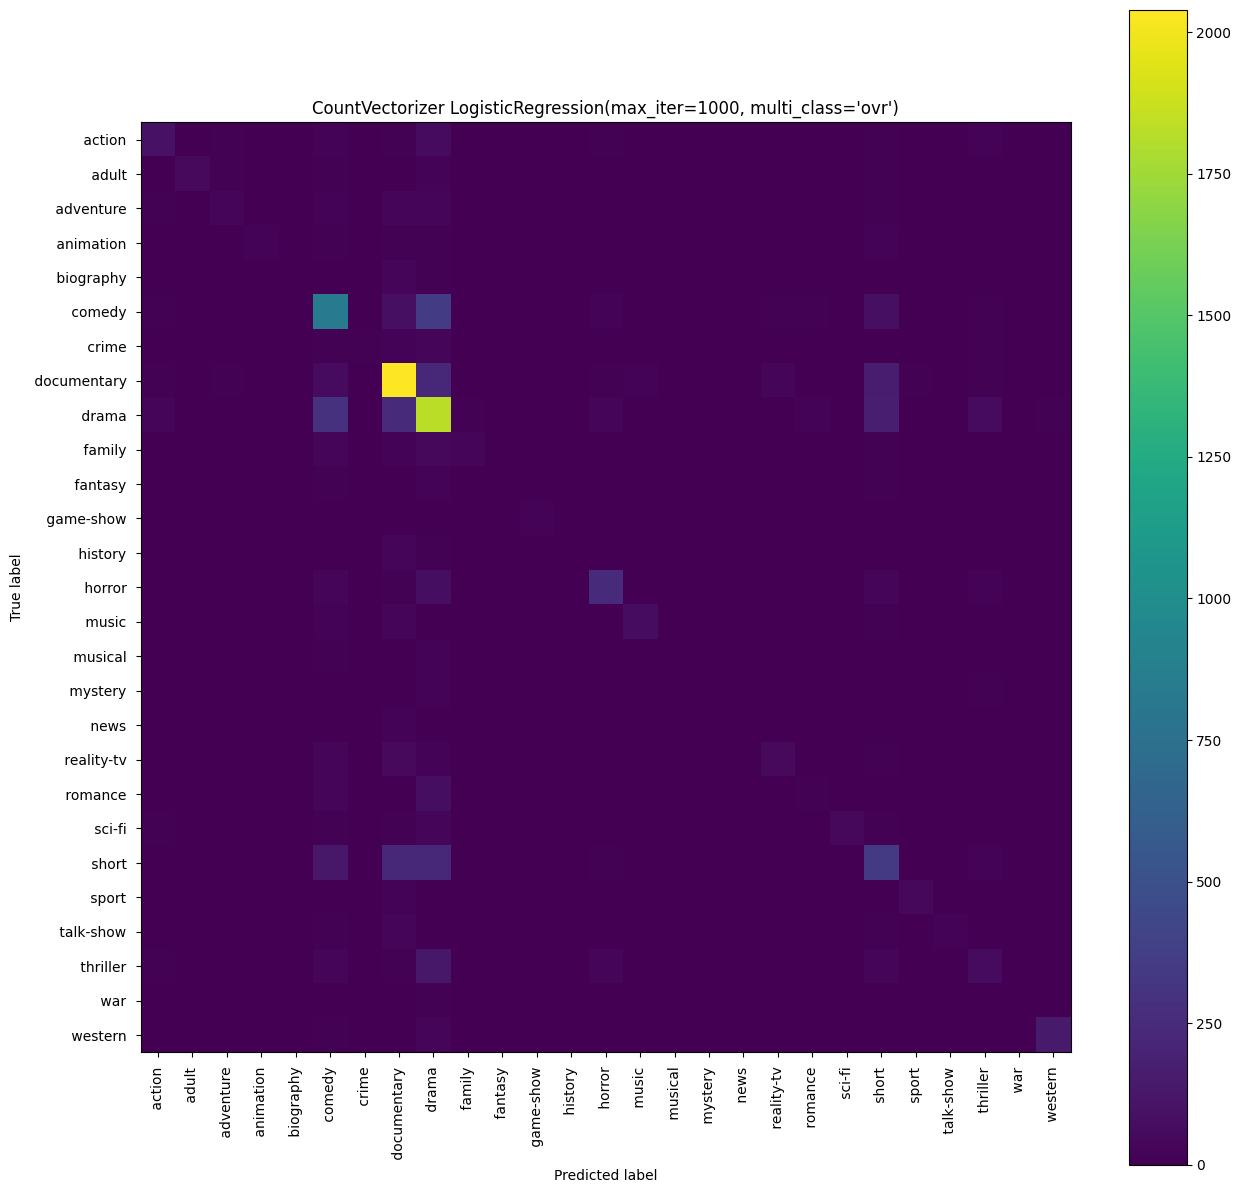

voc. size: 1500
vectorizer: CountVectorizer
classifier: LogisticRegression(max_iter=1000, multi_class='multinomial')
accuracy 0.5448676565526146
               precision    recall  f1-score   support

      action        0.42      0.38      0.40       263
       adult        0.63      0.45      0.52       118
   adventure        0.28      0.19      0.23       155
   animation        0.26      0.18      0.21       100
   biography        0.17      0.02      0.03        53
      comedy        0.52      0.58      0.55      1490
       crime        0.18      0.09      0.12       101
 documentary        0.69      0.76      0.72      2619
       drama        0.55      0.63      0.59      2723
      family        0.34      0.21      0.26       157
     fantasy        0.20      0.06      0.09        65
   game-show        0.95      0.54      0.69        39
     history        0.20      0.06      0.09        49
      horror        0.60      0.55      0.57       441
       music        0.63     

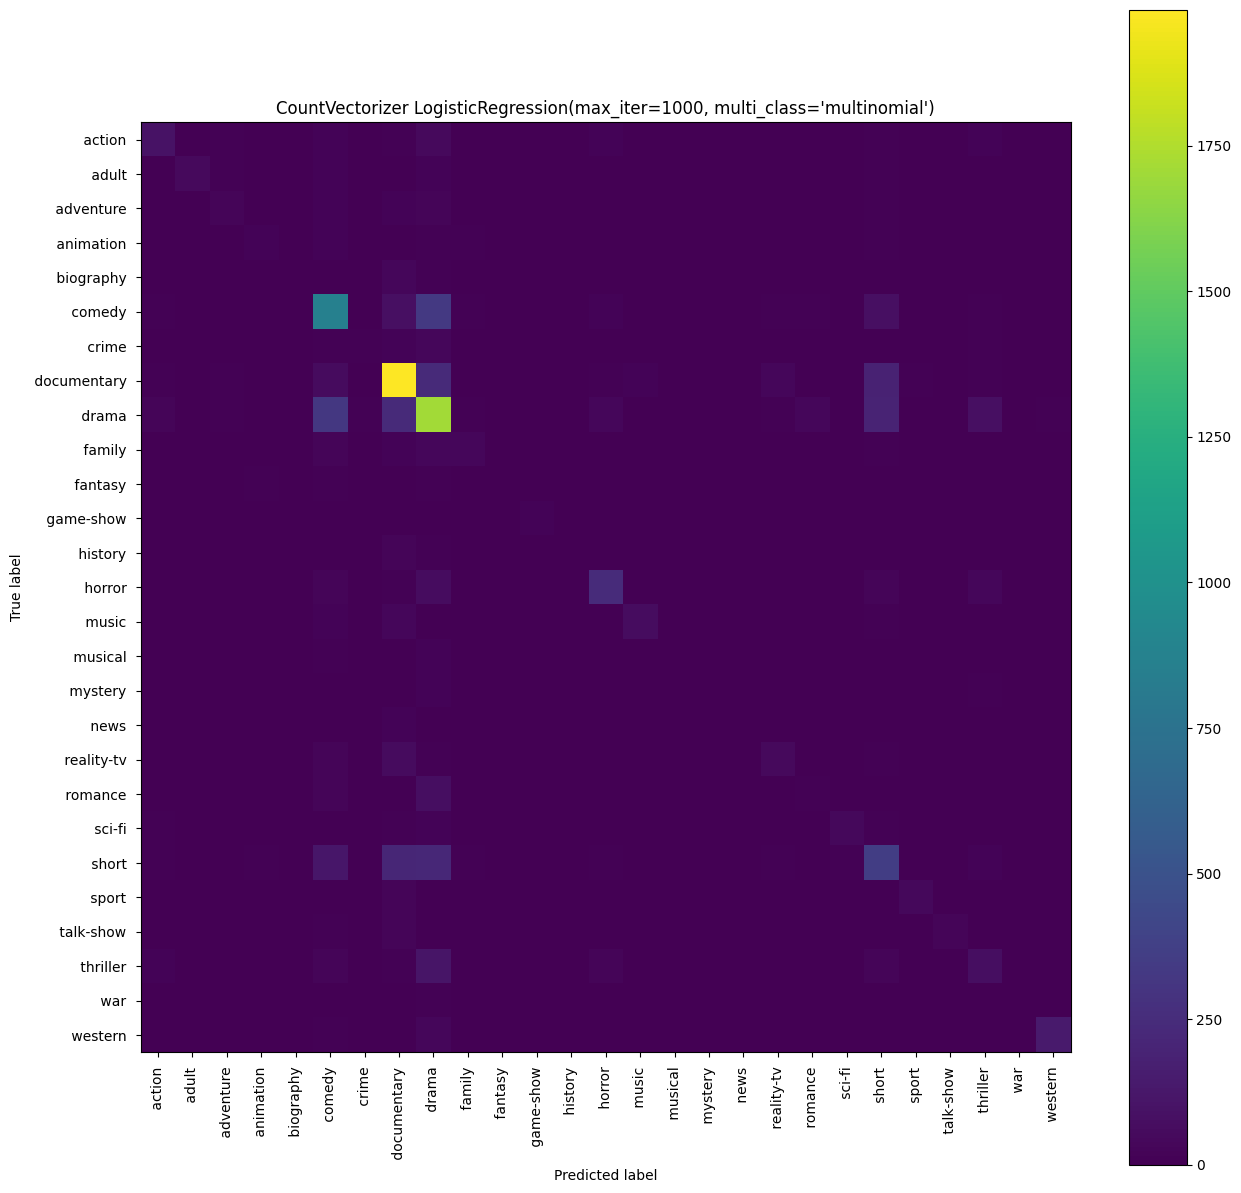

voc. size: 2000
vectorizer: CountVectorizer
classifier: MultinomialNB()
accuracy 0.5763165175689385
               precision    recall  f1-score   support

      action        0.39      0.46      0.42       263
       adult        0.62      0.56      0.59       118
   adventure        0.32      0.22      0.26       155
   animation        0.40      0.16      0.23       100
   biography        0.29      0.04      0.07        53
      comedy        0.55      0.56      0.56      1490
       crime        0.19      0.06      0.09       101
 documentary        0.70      0.79      0.74      2619
       drama        0.61      0.65      0.63      2723
      family        0.43      0.18      0.26       157
     fantasy        0.30      0.11      0.16        65
   game-show        0.82      0.59      0.69        39
     history        0.55      0.12      0.20        49
      horror        0.56      0.69      0.62       441
       music        0.40      0.79      0.53       146
     musical       

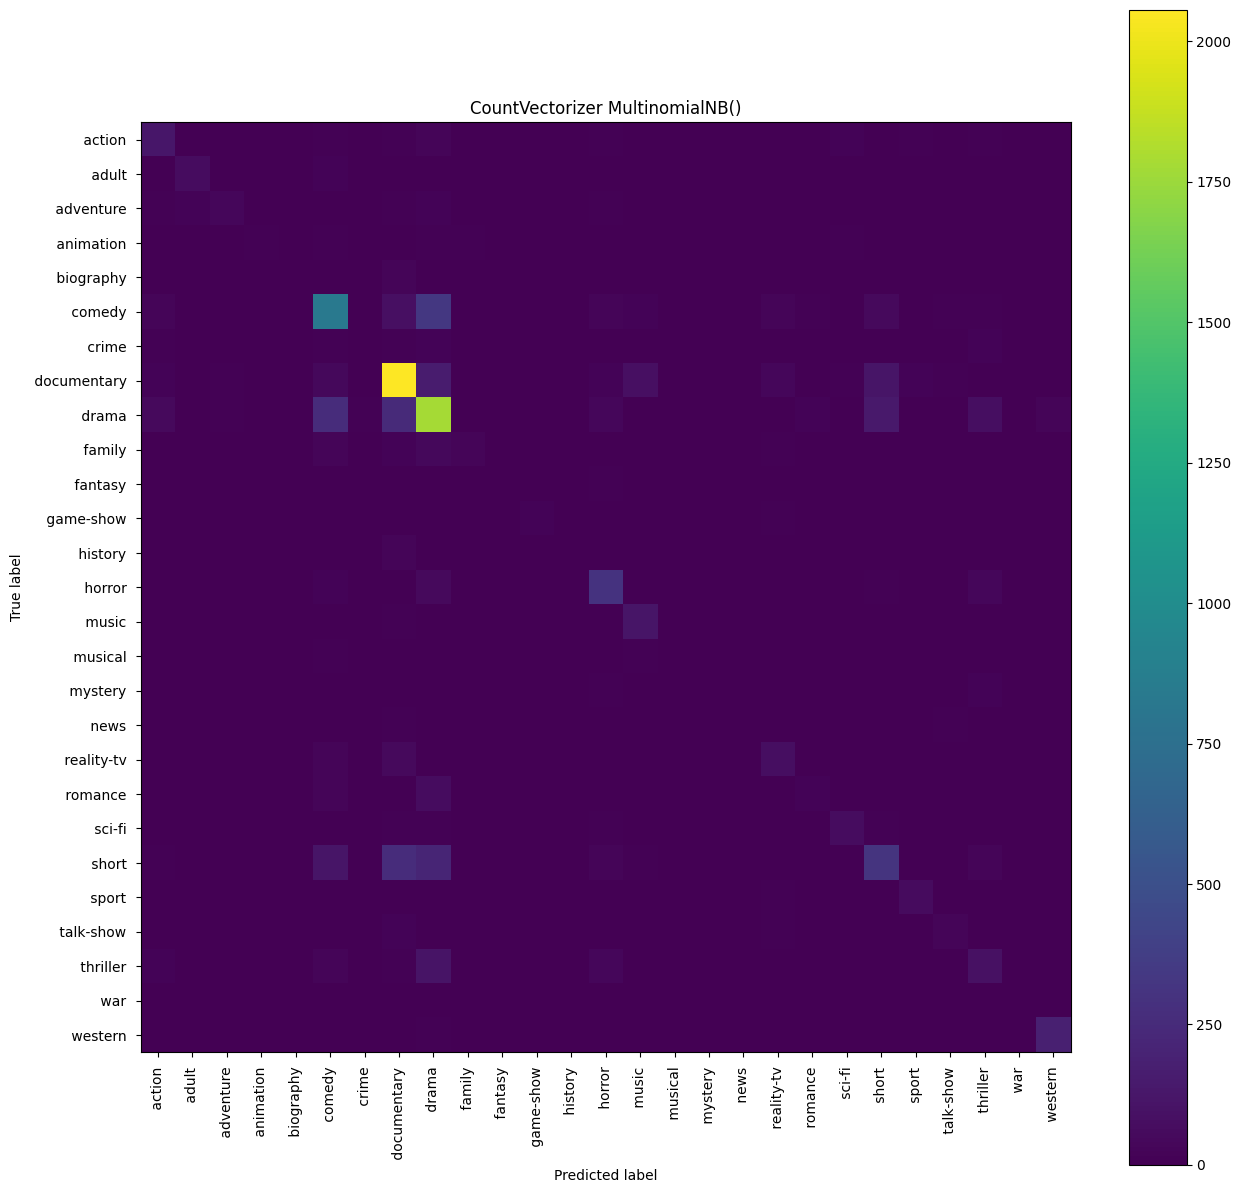

voc. size: 2000
vectorizer: CountVectorizer
classifier: LogisticRegression(max_iter=1000, multi_class='ovr')
accuracy 0.5550124504288481
               precision    recall  f1-score   support

      action        0.42      0.35      0.38       263
       adult        0.64      0.42      0.51       118
   adventure        0.33      0.19      0.24       155
   animation        0.38      0.20      0.26       100
   biography        0.00      0.00      0.00        53
      comedy        0.51      0.57      0.54      1490
       crime        0.28      0.09      0.14       101
 documentary        0.69      0.78      0.73      2619
       drama        0.55      0.67      0.61      2723
      family        0.34      0.16      0.22       157
     fantasy        0.15      0.05      0.07        65
   game-show        0.91      0.51      0.66        39
     history        0.33      0.06      0.10        49
      horror        0.63      0.56      0.59       441
       music        0.61      0.45   

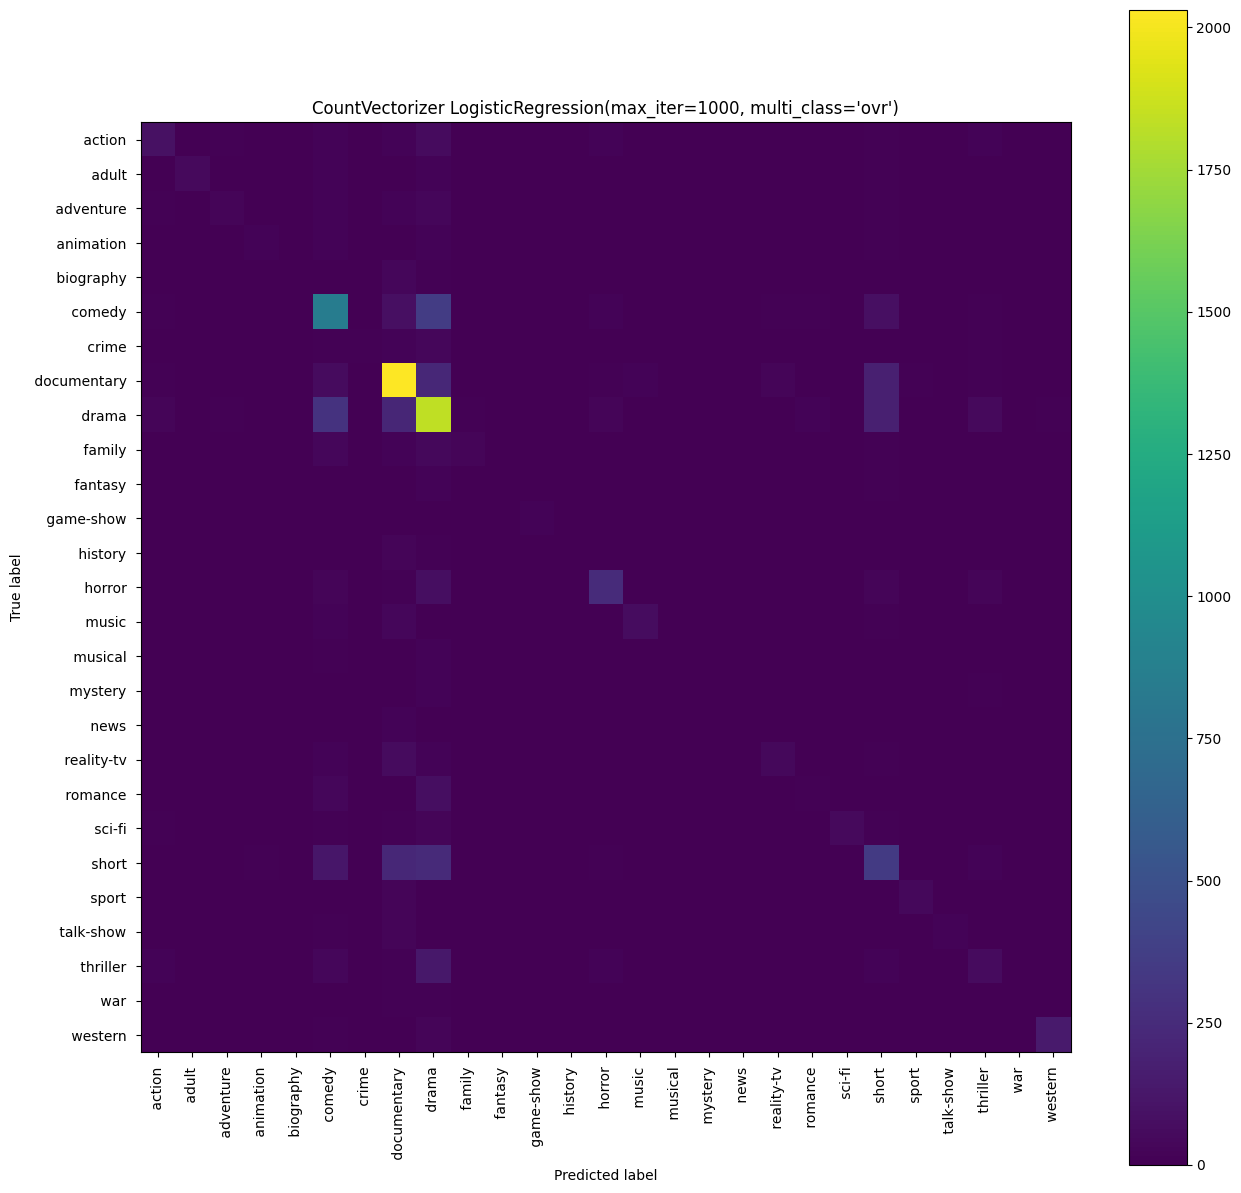

voc. size: 2000
vectorizer: CountVectorizer
classifier: LogisticRegression(max_iter=1000, multi_class='multinomial')
accuracy 0.549571151895232
               precision    recall  f1-score   support

      action        0.41      0.37      0.39       263
       adult        0.67      0.47      0.55       118
   adventure        0.31      0.20      0.24       155
   animation        0.30      0.18      0.22       100
   biography        0.00      0.00      0.00        53
      comedy        0.51      0.58      0.54      1490
       crime        0.20      0.09      0.12       101
 documentary        0.69      0.76      0.72      2619
       drama        0.56      0.64      0.60      2723
      family        0.31      0.17      0.22       157
     fantasy        0.13      0.05      0.07        65
   game-show        0.91      0.54      0.68        39
     history        0.23      0.06      0.10        49
      horror        0.61      0.56      0.59       441
       music        0.62      

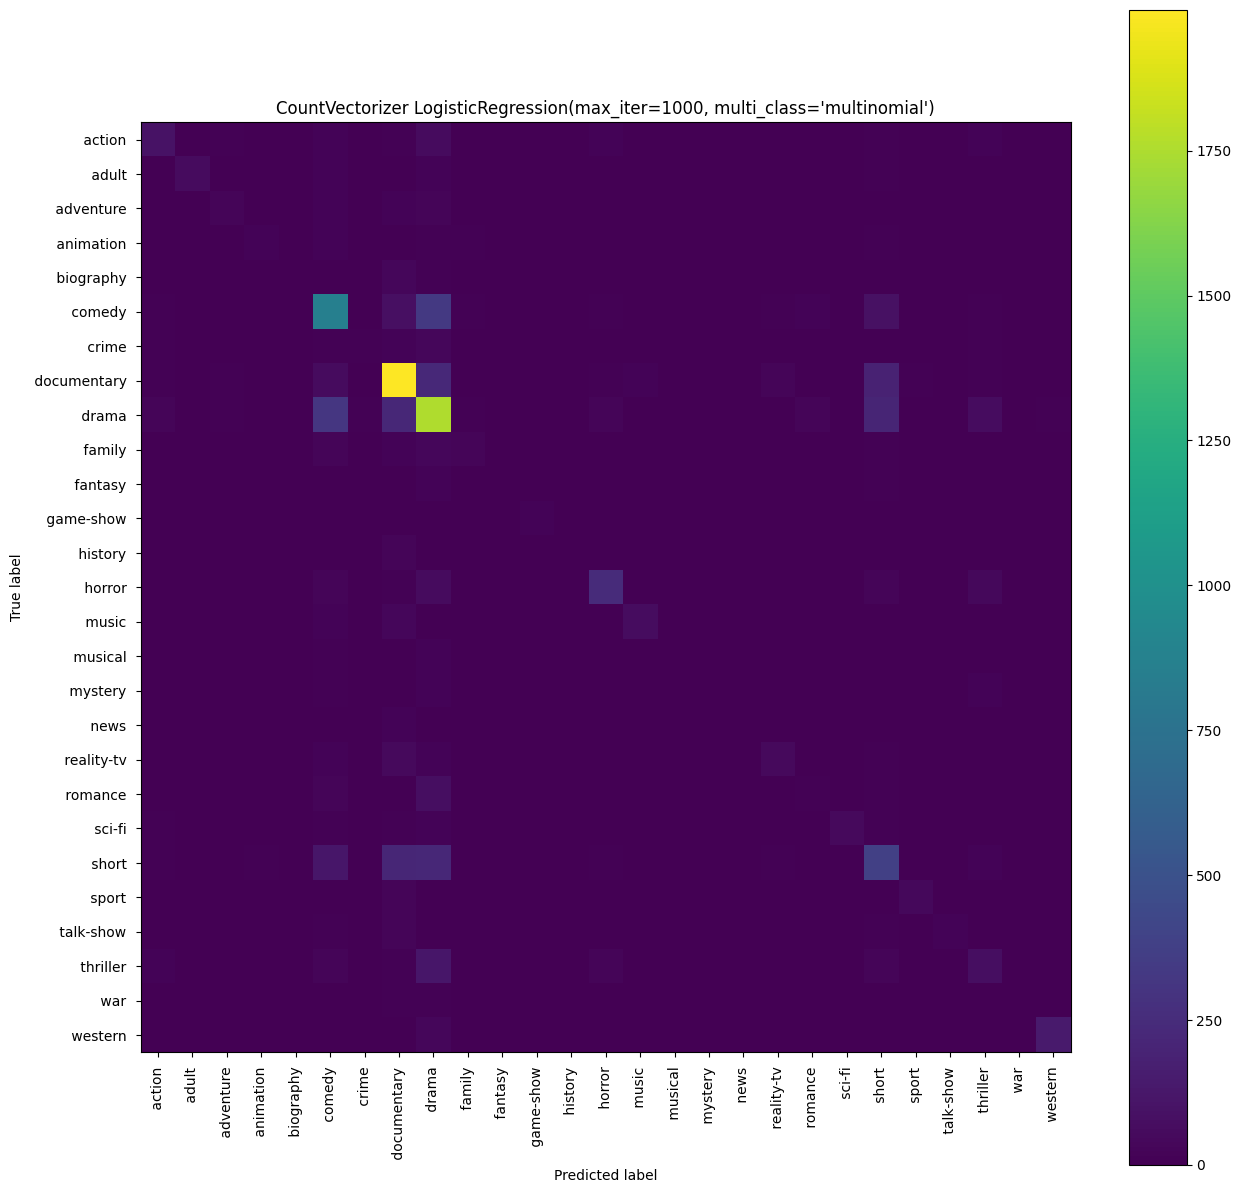

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

voc_size=[500,1000,1500,2000]
classifiers=[MultinomialNB(), LogisticRegression(max_iter=1000, multi_class='ovr'),
             LogisticRegression(max_iter=1000, multi_class='multinomial')]
models=[]
for vsize in voc_size:
    gen_voc=voc_generator(vsize)
    vectorizer=CountVectorizer(vocabulary=gen_voc)
    for clf in classifiers:
        print("voc. size: "+str(vsize))
        models.append(model_generator(X_train, y_train, X_test, y_test, vectorizer, clf))


Since classifying most descriptions correctly is our primary objective we focus on the recall of each model. The multinomial naive bayes classifiers outscore the recall of logistic regression classifiers so we choose naive bayes over the others. Although the accuracy incrases with the size of vocabulary the recall decreases accordinigly. This means that the naive bayes classifier with the highest recall corresponds to the lowest vocabulary size. However we choose a vocabulary size of $1000$ instead of the lowest size ($500$) and the multinomial naive bayes classifier. 

It only remains the tunning of the $\alpha$ hyperparameter of the naive bayes model.

# Hyperparameter tuning

voc. size: 1000
vectorizer: CountVectorizer
classifier: MultinomialNB(alpha=0.7)
accuracy 0.5500322788896062
               precision    recall  f1-score   support

      action        0.36      0.48      0.41       263
       adult        0.57      0.64      0.60       118
   adventure        0.30      0.25      0.27       155
   animation        0.32      0.23      0.27       100
   biography        0.06      0.04      0.05        53
      comedy        0.56      0.49      0.52      1490
       crime        0.20      0.19      0.19       101
 documentary        0.72      0.73      0.72      2619
       drama        0.61      0.60      0.61      2723
      family        0.31      0.19      0.24       157
     fantasy        0.24      0.23      0.23        65
   game-show        0.76      0.64      0.69        39
     history        0.22      0.20      0.21        49
      horror        0.58      0.66      0.62       441
       music        0.37      0.82      0.51       146
     music

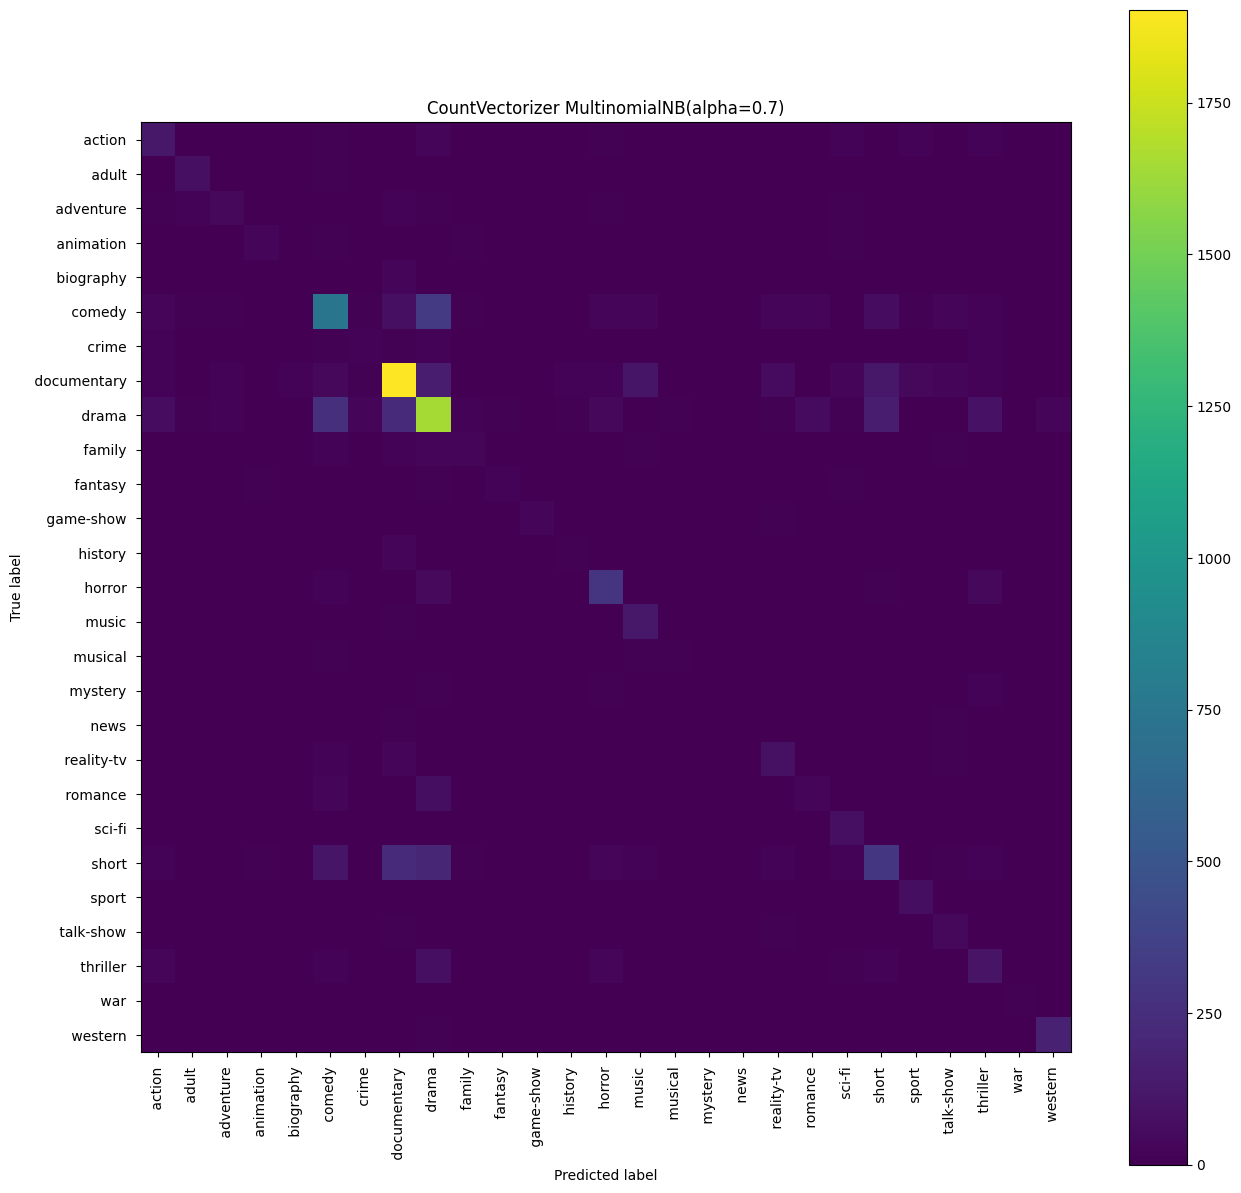

voc. size: 1000
vectorizer: CountVectorizer
classifier: MultinomialNB(alpha=0.7999999999999999)
accuracy 0.5517845614682283
               precision    recall  f1-score   support

      action        0.36      0.49      0.42       263
       adult        0.57      0.62      0.60       118
   adventure        0.30      0.25      0.27       155
   animation        0.32      0.23      0.27       100
   biography        0.07      0.04      0.05        53
      comedy        0.56      0.49      0.52      1490
       crime        0.21      0.19      0.20       101
 documentary        0.72      0.73      0.72      2619
       drama        0.61      0.61      0.61      2723
      family        0.31      0.19      0.24       157
     fantasy        0.25      0.23      0.24        65
   game-show        0.76      0.64      0.69        39
     history        0.24      0.20      0.22        49
      horror        0.58      0.67      0.62       441
       music        0.36      0.82      0.50      

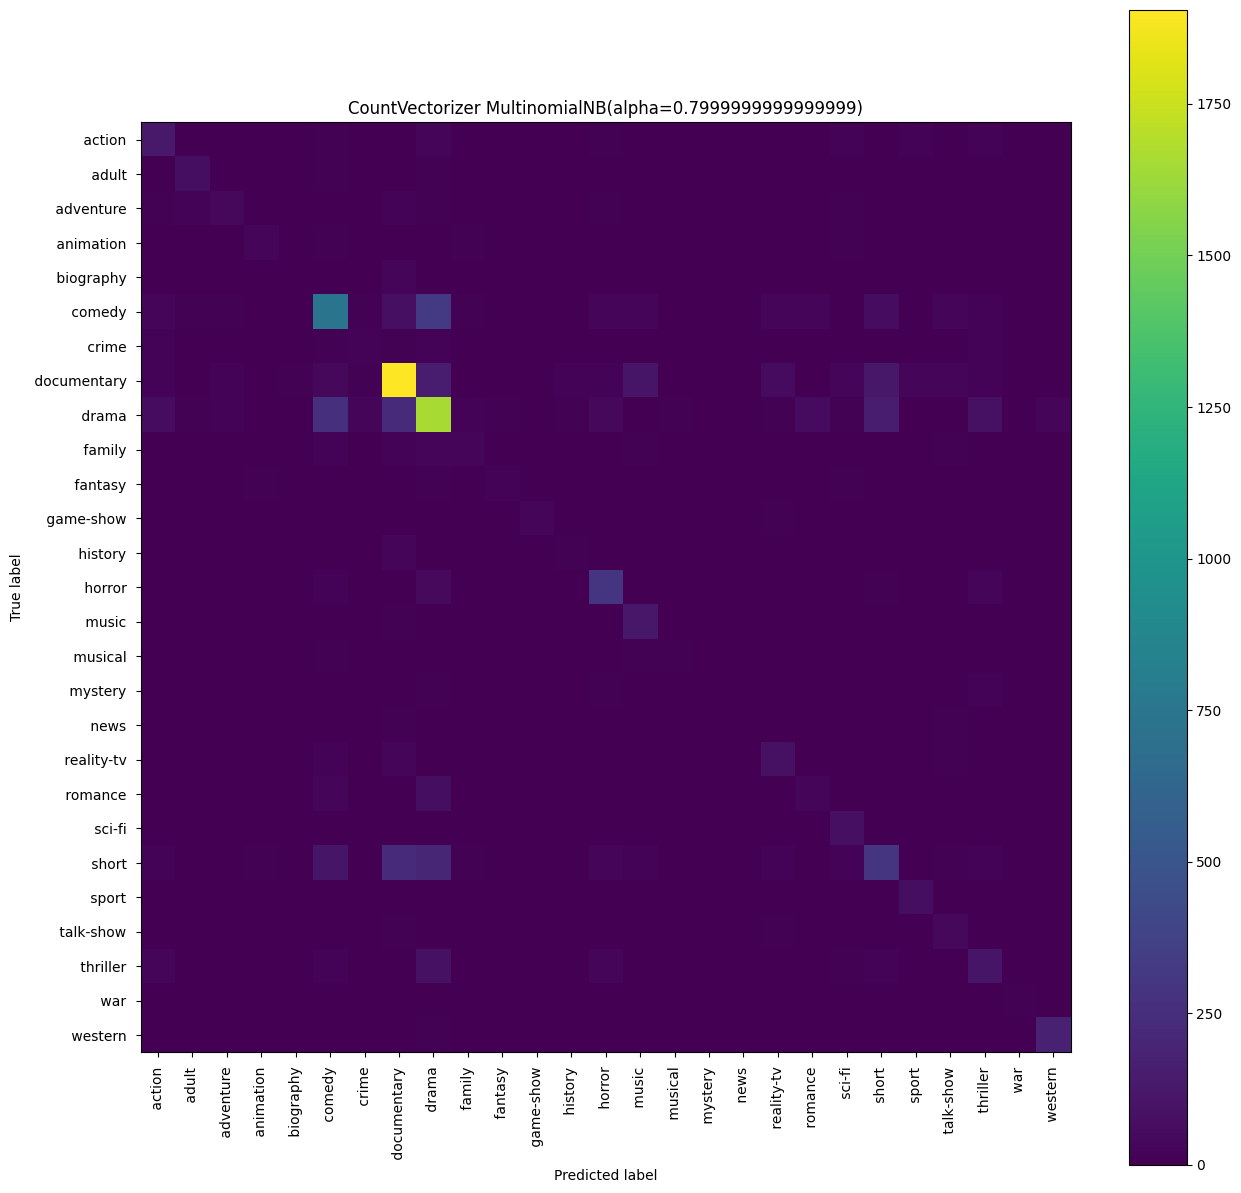

voc. size: 1000
vectorizer: CountVectorizer
classifier: MultinomialNB(alpha=0.8999999999999999)
accuracy 0.5531679424513511
               precision    recall  f1-score   support

      action        0.37      0.49      0.42       263
       adult        0.58      0.62      0.60       118
   adventure        0.30      0.23      0.26       155
   animation        0.31      0.22      0.26       100
   biography        0.09      0.04      0.05        53
      comedy        0.55      0.50      0.52      1490
       crime        0.19      0.17      0.18       101
 documentary        0.72      0.73      0.72      2619
       drama        0.61      0.61      0.61      2723
      family        0.32      0.18      0.23       157
     fantasy        0.26      0.23      0.24        65
   game-show        0.76      0.64      0.69        39
     history        0.21      0.14      0.17        49
      horror        0.58      0.68      0.63       441
       music        0.36      0.82      0.50      

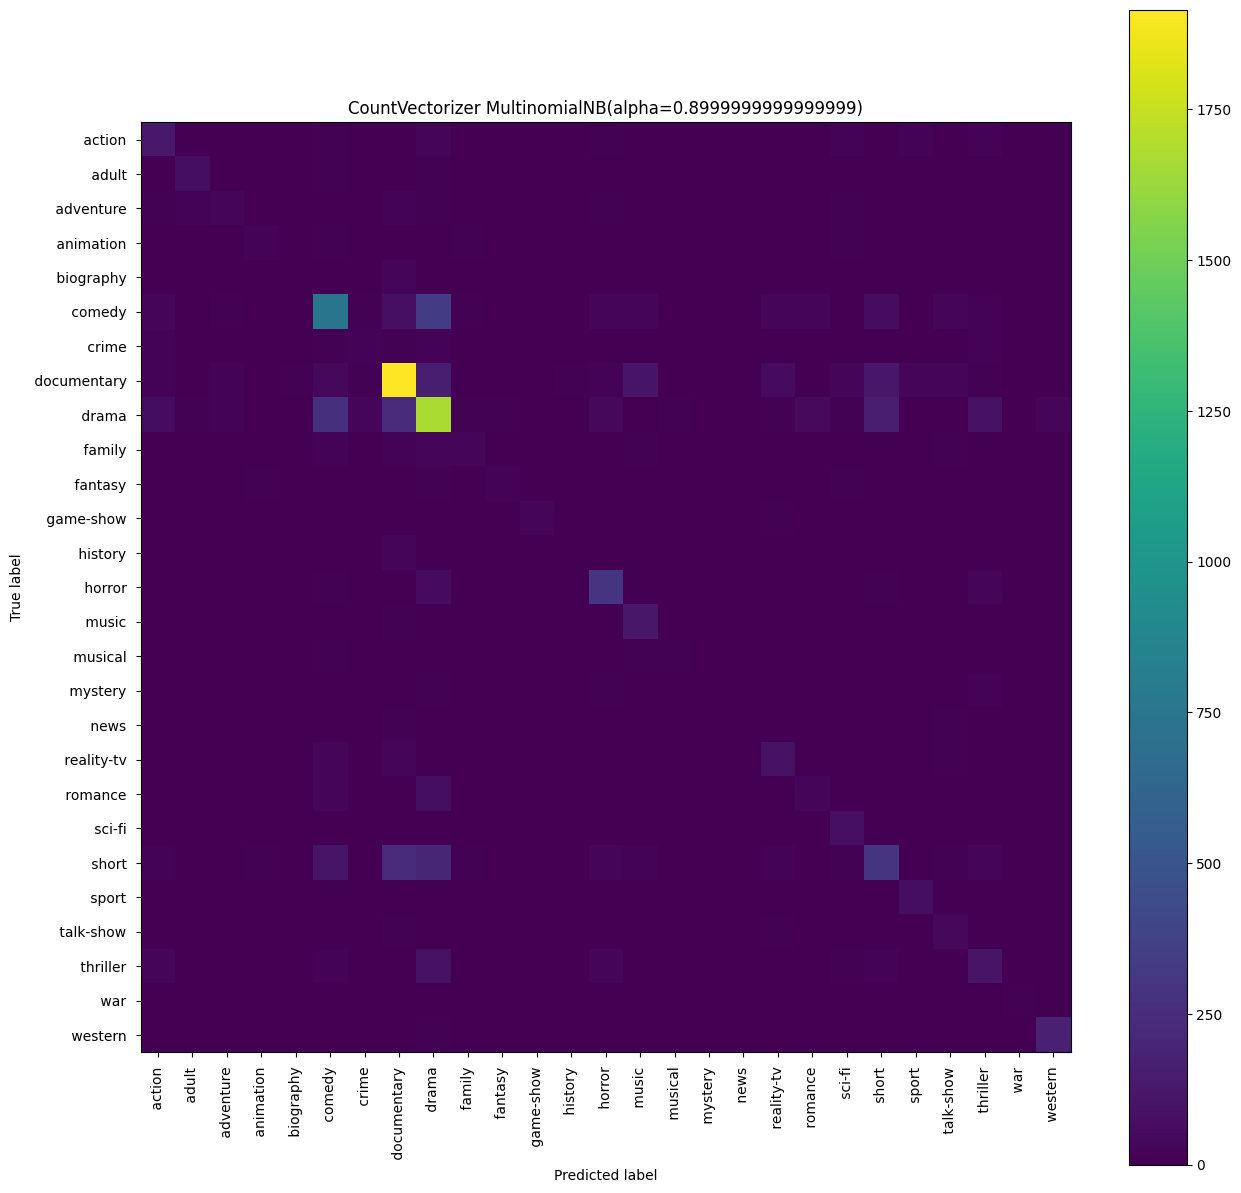

voc. size: 1000
vectorizer: CountVectorizer
classifier: MultinomialNB(alpha=0.9999999999999999)
accuracy 0.5555658028220972
               precision    recall  f1-score   support

      action        0.37      0.49      0.42       263
       adult        0.59      0.60      0.59       118
   adventure        0.31      0.23      0.27       155
   animation        0.33      0.22      0.26       100
   biography        0.05      0.02      0.03        53
      comedy        0.55      0.50      0.53      1490
       crime        0.18      0.16      0.17       101
 documentary        0.72      0.74      0.73      2619
       drama        0.61      0.62      0.61      2723
      family        0.32      0.18      0.23       157
     fantasy        0.27      0.23      0.25        65
   game-show        0.76      0.64      0.69        39
     history        0.24      0.14      0.18        49
      horror        0.58      0.68      0.63       441
       music        0.37      0.82      0.51      

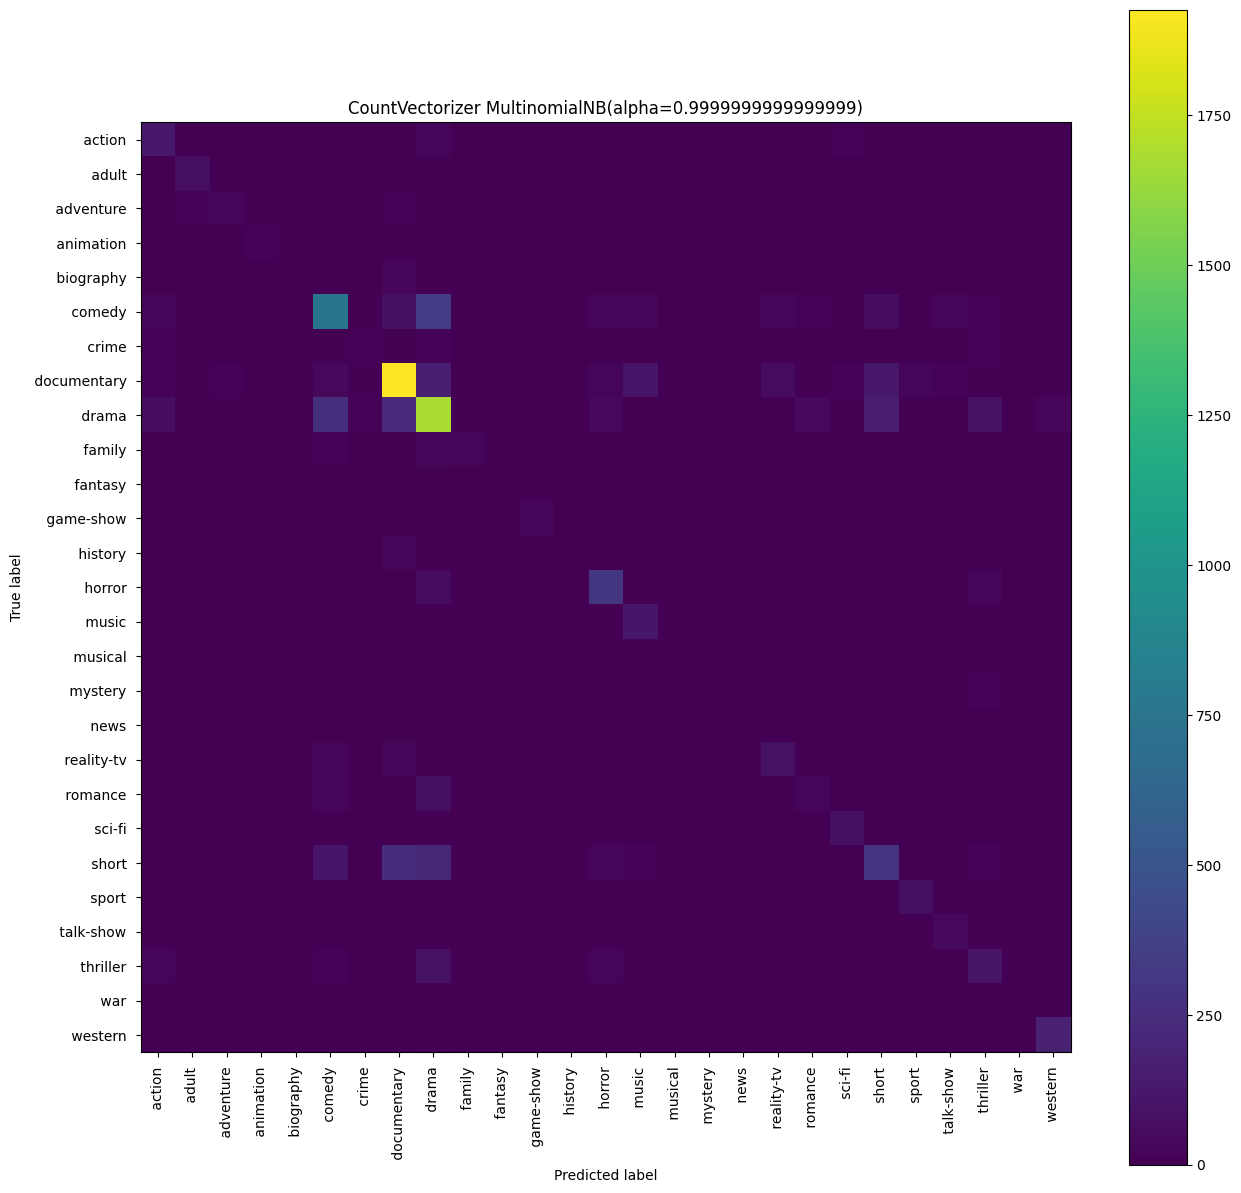

voc. size: 1000
vectorizer: CountVectorizer
classifier: MultinomialNB(alpha=1.0999999999999999)
accuracy 0.557502536198469
               precision    recall  f1-score   support

      action        0.37      0.49      0.42       263
       adult        0.58      0.59      0.59       118
   adventure        0.33      0.24      0.28       155
   animation        0.34      0.22      0.27       100
   biography        0.06      0.02      0.03        53
      comedy        0.56      0.50      0.53      1490
       crime        0.17      0.14      0.15       101
 documentary        0.72      0.74      0.73      2619
       drama        0.61      0.62      0.62      2723
      family        0.33      0.18      0.24       157
     fantasy        0.28      0.23      0.25        65
   game-show        0.76      0.64      0.69        39
     history        0.26      0.14      0.18        49
      horror        0.58      0.69      0.63       441
       music        0.37      0.82      0.50       

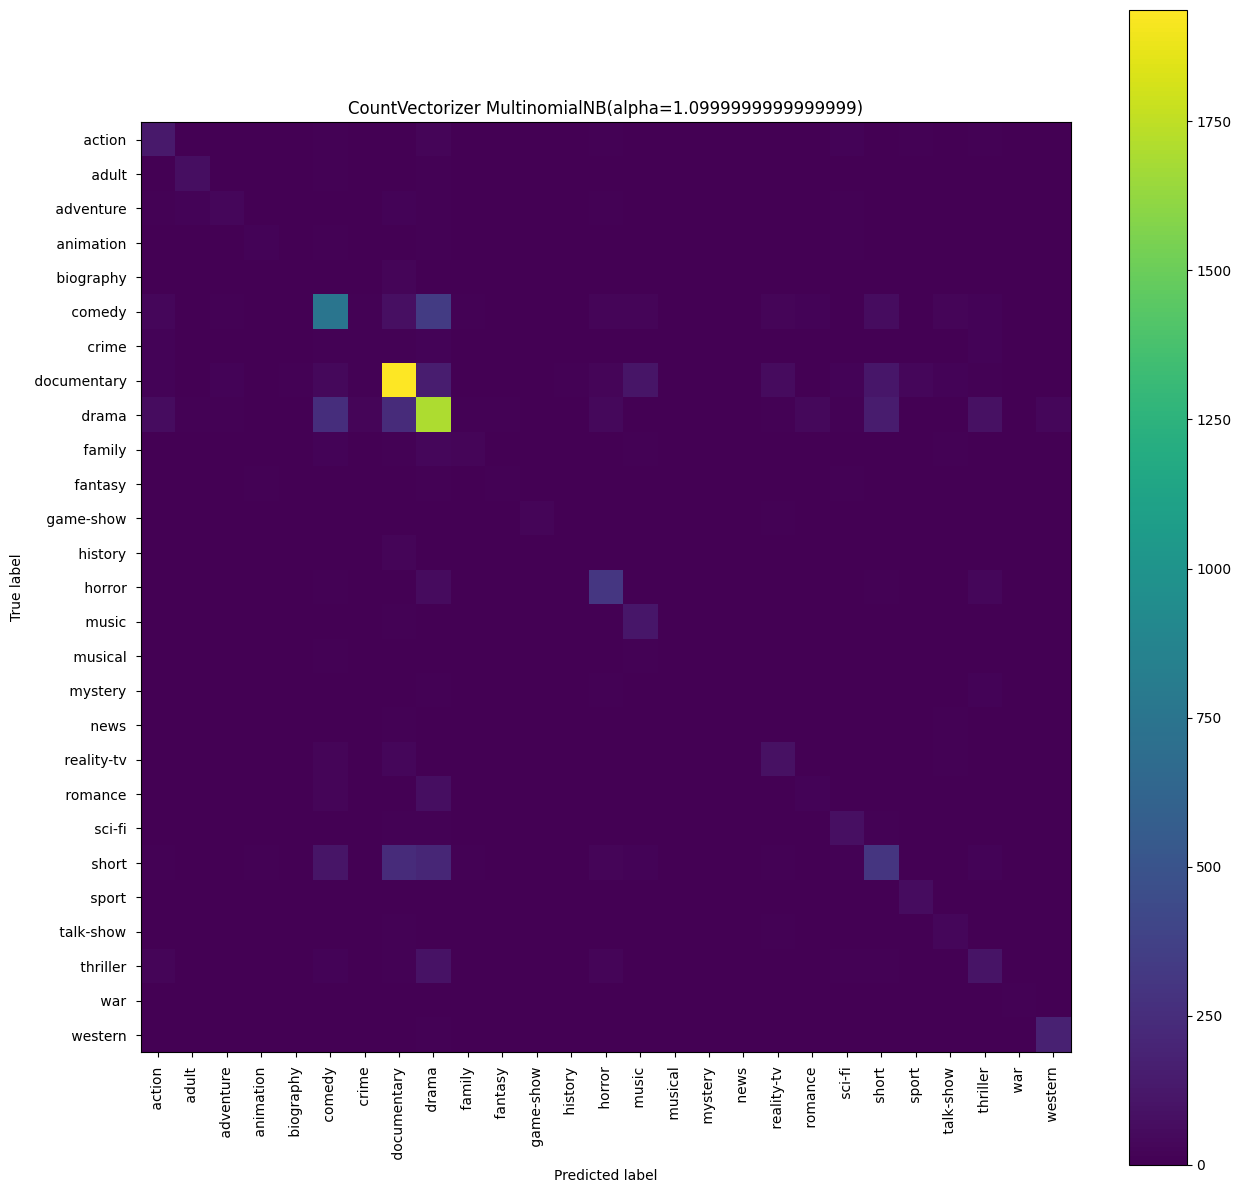

In [14]:
classifiers=[MultinomialNB(alpha=a) for a in np.arange(0.7,1.2,0.1)]
vectorizer=CountVectorizer(vocabulary=voc_generator(1000))

multinomialNBs = []
for clf in classifiers:
    print("voc. size: "+str(1000))
    multinomialNBs.append(model_generator(X_train, y_train, X_test, y_test, vectorizer, clf))


We can see that the multinomial naive bayes classifier achieves maximum recall score with $\alpha$ equal to $0.7$ and $0.8$. Hence we choose we choose a multinomial naive bayes classifier with $\alpha = 0.7$ as our final classifier.

In [15]:
vectorizer=multinomialNBs[0]['vectorizer']
multinomialNB=multinomialNBs[0]['classifier']
multinomialNB.predict(vectorizer.transform(movies.loc[:10,'description']))


array([' drama ', ' thriller ', ' adult ', ' drama ', ' documentary ',
       ' short ', ' comedy ', ' comedy ', ' documentary ', ' horror '],
      dtype='<U13')

# Final predictions

Finally we test the model on the original test set

######################### FINAL RESULTS ##############################
classifier: MultinomialNB(alpha=0.7)
accuracy 0.5303505535055351
               precision    recall  f1-score   support

      action        0.36      0.47      0.41      1314
       adult        0.46      0.54      0.50       590
   adventure        0.28      0.22      0.25       775
   animation        0.30      0.23      0.26       498
   biography        0.06      0.04      0.05       264
      comedy        0.56      0.47      0.51      7446
       crime        0.16      0.19      0.17       505
 documentary        0.71      0.70      0.71     13096
       drama        0.62      0.57      0.59     13612
      family        0.27      0.21      0.24       783
     fantasy        0.20      0.19      0.19       322
   game-show        0.68      0.69      0.69       193
     history        0.10      0.07      0.08       243
      horror        0.55      0.65      0.60      2204
       music        0.35      0.75    

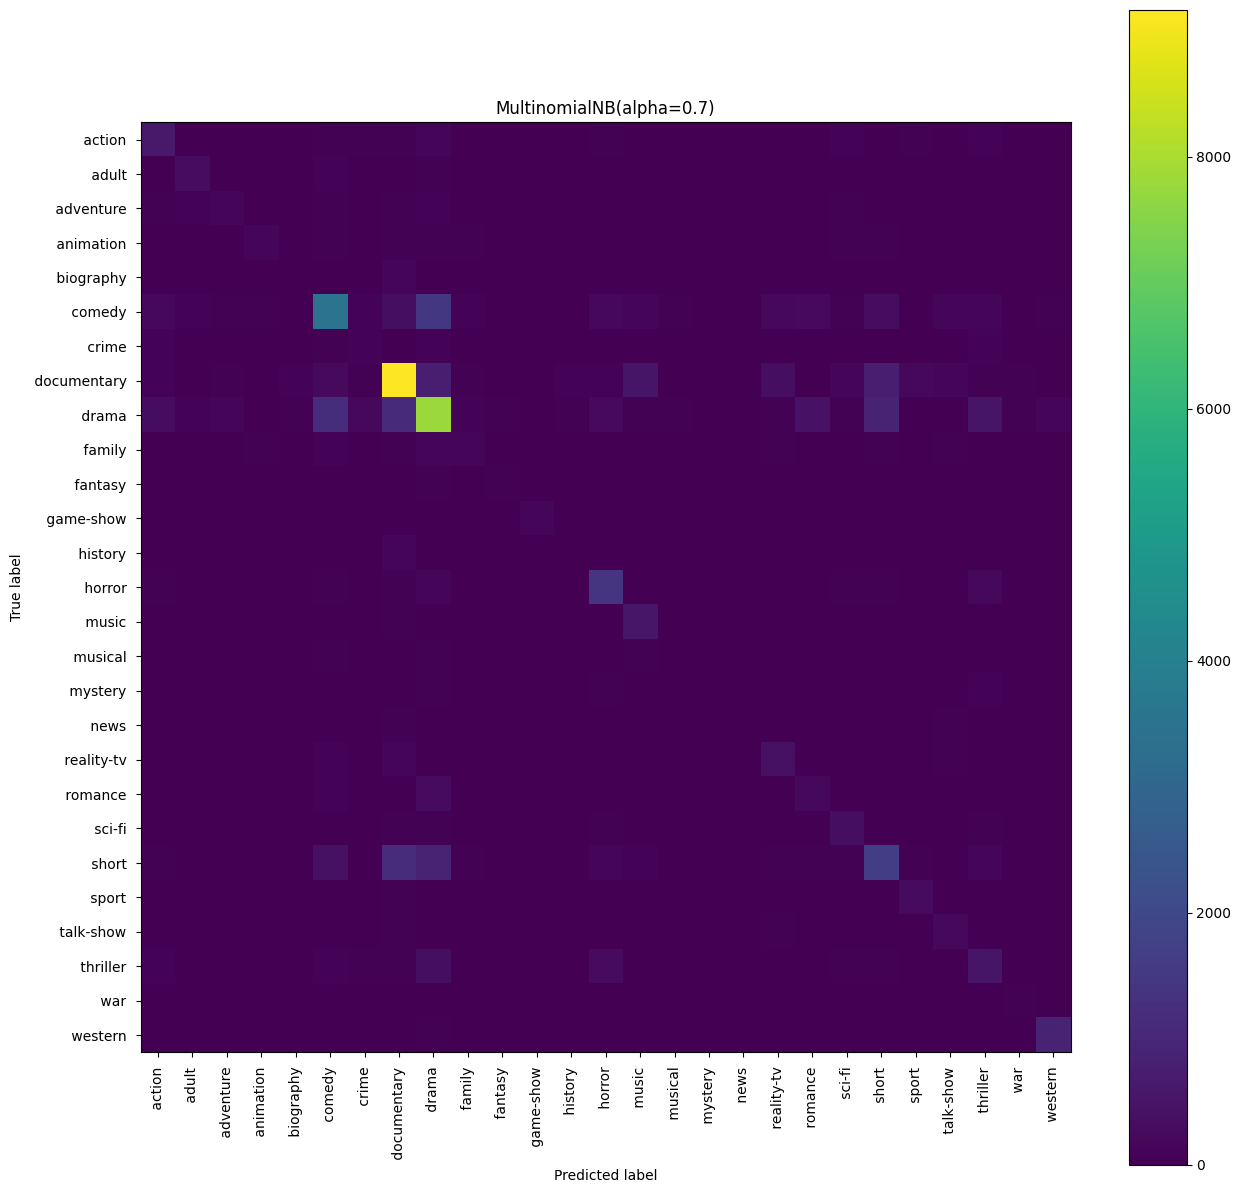

In [16]:
X_test=movies_test.loc[:,'description']
y_test=movies_test.loc[:,'genre']

y_pred = multinomialNB.predict(vectorizer.transform(X_test))
cname=str(multinomialNBs[0].get_params()['classifier'])
print('######################### FINAL RESULTS ##############################')
print('classifier: '+str(cname))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test,y_pred,labels=multinomialNB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multinomialNB.classes_)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(include_values=False,xticks_rotation='vertical',ax=ax)
plt.title(cname)
plt.show()


The final model has an accuracy of $0.53$ and a weighted average recall of $0.53$ as well. In both the confusion matrix of our final classifier as well as that of the other classifiers that were tested we can see that many times "drama" and
"documentary" movies were mistakenly labelled as "short" movies and viceversa. As it was previously observed movies of these genres share many of their most common words so this might be the source of such confusion. Assessing this issue would certainly lead to better classifiers in the future.